In [1]:
import argparse
import numpy as np
import sys, os

from map_reader import MapReader
from motion_model import MotionModel
from sensor_model import SensorModel
from resampling import Resampling

from matplotlib import pyplot as plt
from matplotlib import figure as fig
import time
from tqdm import tqdm

In [14]:
def visualize_map(occupancy_map):
    fig = plt.figure()
    mng = plt.get_current_fig_manager()
    plt.ion()
    plt.imshow(occupancy_map, cmap="Greys")
    plt.axis([0, 800, 0, 800])


def visualize_timestep(X_bar, tstep, output_path):
    x_locs = X_bar[:, 0] / 10.0
    y_locs = X_bar[:, 1] / 10.0
    plt.scatter(x_locs, y_locs, c="r", marker="o")
    plt.title("Particles")
    plt.xlabel("X-Axis")
    plt.ylabel("Y-Axis")
    fig.canvas.draw_idle()
    plt.pause(0.1)
    plt.show()


def init_particles_random(num_particles, occupancy_map):

    # initialize [x, y, theta] positions in world_frame for all particles
    y0_vals = np.random.uniform(0, 7000, (num_particles, 1))
    x0_vals = np.random.uniform(3000, 7000, (num_particles, 1))
    theta0_vals = np.random.uniform(-3.14, 3.14, (num_particles, 1))

    # initialize weights for all particles
    w0_vals = np.ones((num_particles, 1), dtype=np.float64)
    w0_vals = w0_vals / num_particles

    X_bar_init = np.hstack((x0_vals, y0_vals, theta0_vals, w0_vals))

    return X_bar_init


def init_particles_freespace(num_particles, occupancy_map):

    # initialize [x, y, theta] positions in world_frame for all particles
    """
    TODO : Add your code here
    This version converges faster than init_particles_random
    """
    occupancy_map = occupancy_map.T
    freespace = (np.array(occupancy_map) ==0)
    freespace_x = freespace.nonzero()[0] * 10
    freespace_y = freespace.nonzero()[1] * 10

    assert num_particles < freespace_x.shape[0], "Too many particles! No. of particles > Free space points"

    # initialize [x, y, theta] positions in world_frame for all particles
    x0_vals = np.random.choice(freespace_x, (num_particles, 1), replace=False)
    y0_vals = np.random.choice(freespace_y, (num_particles, 1), replace=False)
    theta0_vals = np.random.uniform(-3.14, 3.14, (num_particles, 1))

    # initialize weights for all particles
    w0_vals = np.ones((num_particles, 1), dtype=np.float64)
    w0_vals = w0_vals / num_particles

    X_bar_init = np.hstack((x0_vals, y0_vals, theta0_vals, w0_vals))

    return X_bar_init

In [6]:
"""
Description of variables used
u_t0 : particle state odometry reading [x, y, theta] at time (t-1) [odometry_frame]
u_t1 : particle state odometry reading [x, y, theta] at time t [odometry_frame]
x_t0 : particle state belief [x, y, theta] at time (t-1) [world_frame]
x_t1 : particle state belief [x, y, theta] at time t [world_frame]
X_bar : [num_particles x 4] sized array containing [x, y, theta, wt] values for all particles
z_t : array of 180 range measurements for each laser scan
"""
os.chdir(r"D:\CMU\Academics\SLAM\Homeworks\HW1")

src_path_map = r"hw1_code_data_assets/data/map/wean.dat"
src_path_log = r"hw1_code_data_assets/data/log/robotdata2.log"
os.makedirs(r"hw1_code_data_assets/results", exist_ok=True)

map_obj = MapReader(src_path_map)
occupancy_map = map_obj.get_map()
logfile = open(src_path_log, "r")

# * Define the models for MCL
motion_model = MotionModel()
sensor_model = SensorModel(map_obj)
resampler = Resampling()

Finished reading 2D map of size: (8000, 8000)


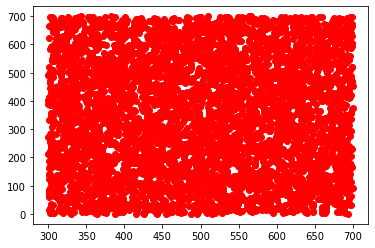

AttributeError: module 'matplotlib.figure' has no attribute 'canvas'

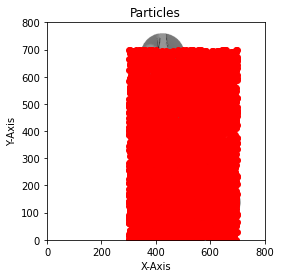

In [15]:
# * Particles and Initialization
num_particles = 5000
X_bar = init_particles_random(num_particles, occupancy_map)

# TODO
# X_bar = init_particles_freespace(num_particles, occupancy_map)

x_locs = X_bar[:, 0] / 10.0
y_locs = X_bar[:, 1] / 10.0
plt.scatter(x_locs, y_locs, c="r", marker="o")
plt.show()

visualize_map(occupancy_map)
visualize_timestep(X_bar, 1000000, r"hw1_code_data_assets/results")

<Figure size 432x288 with 0 Axes>

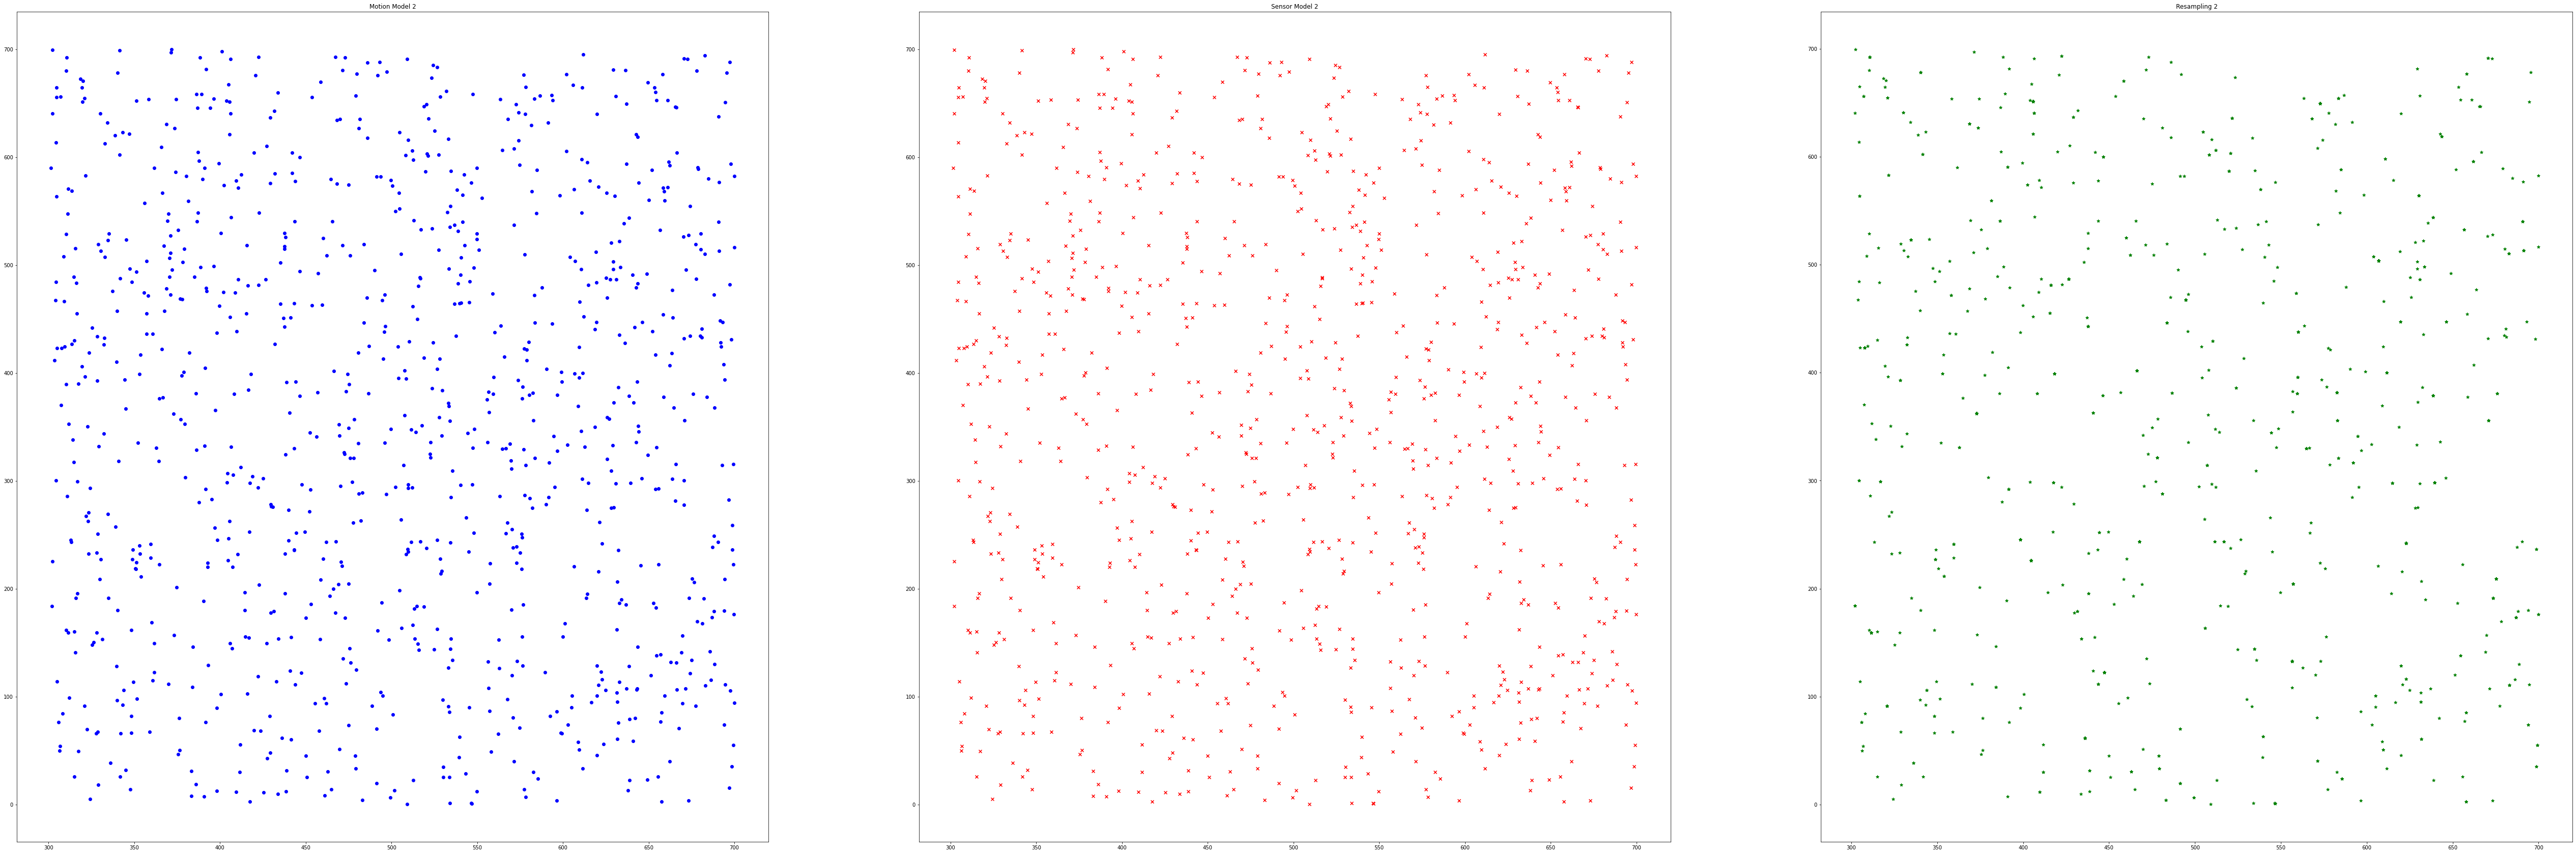

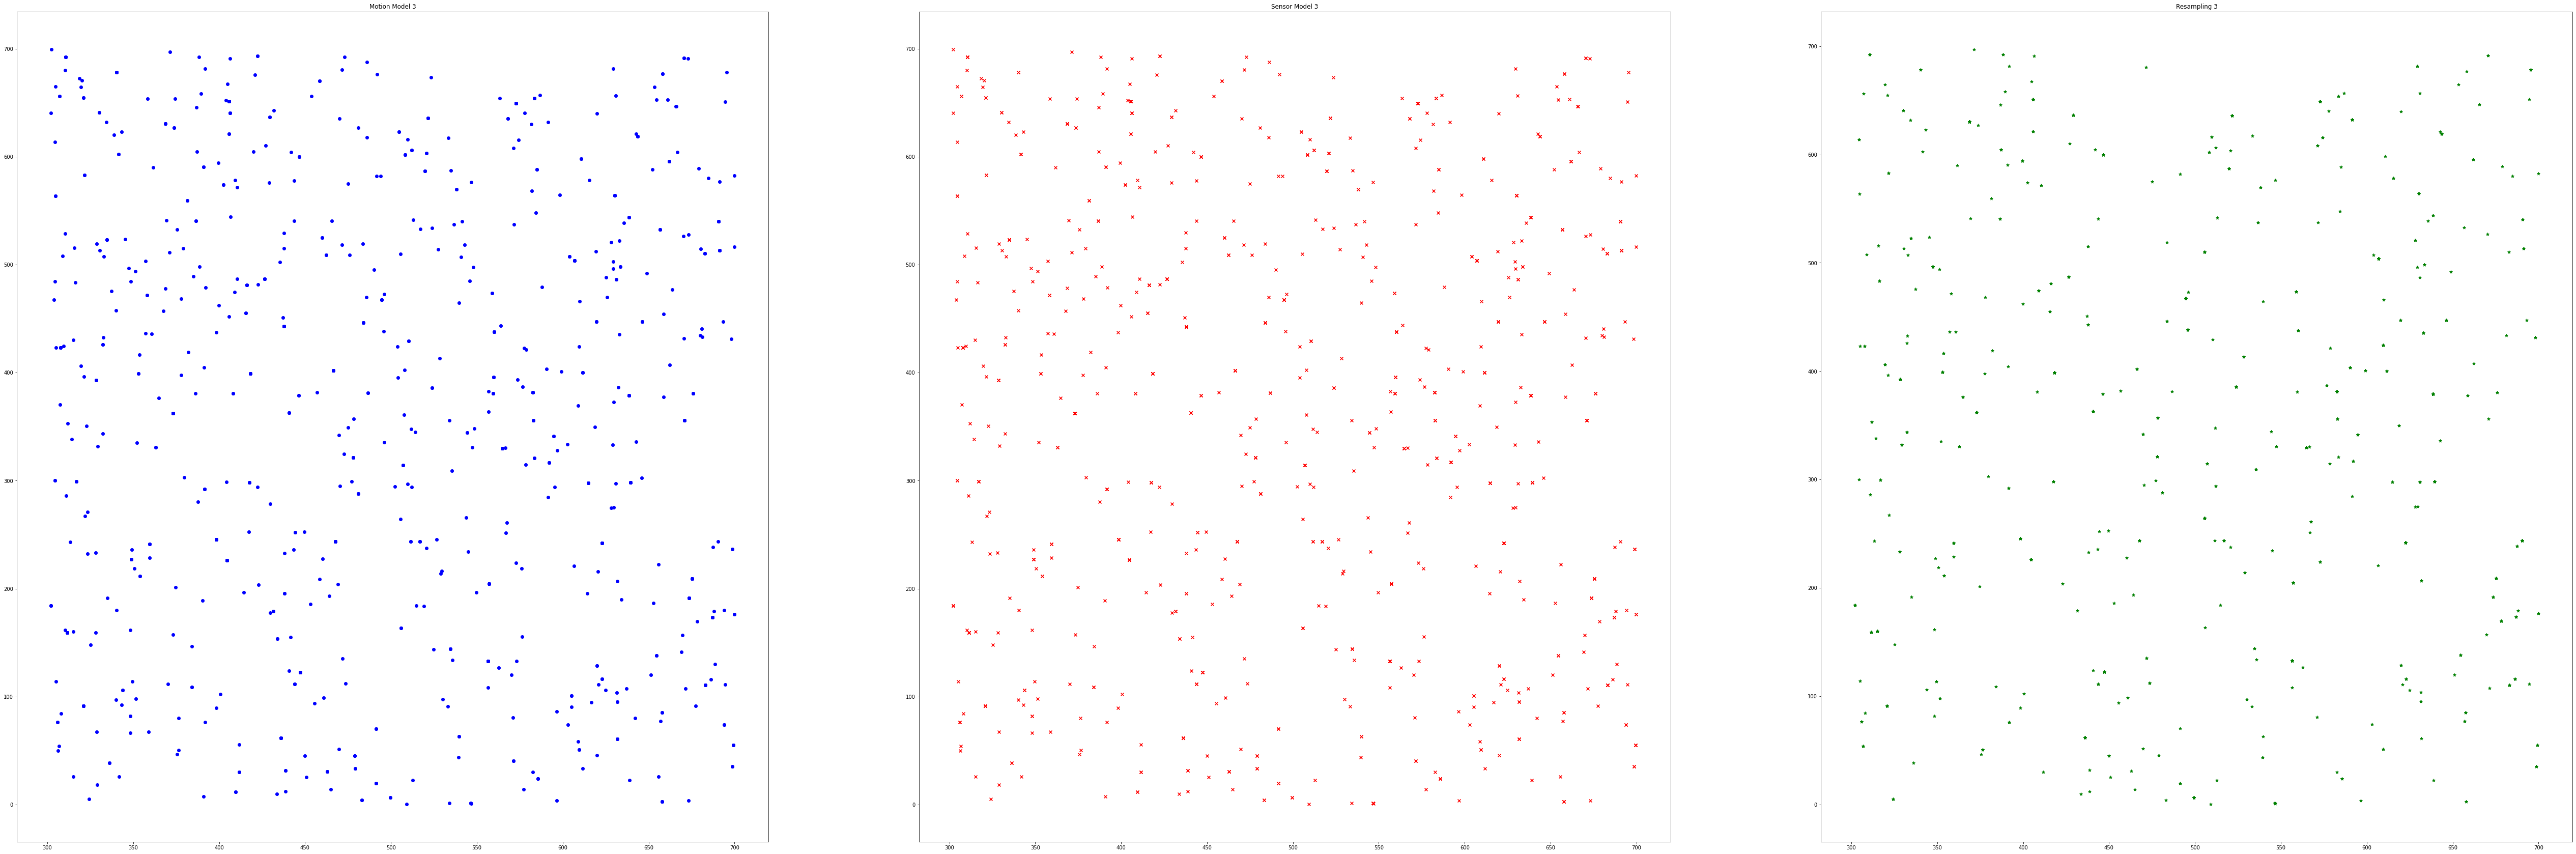

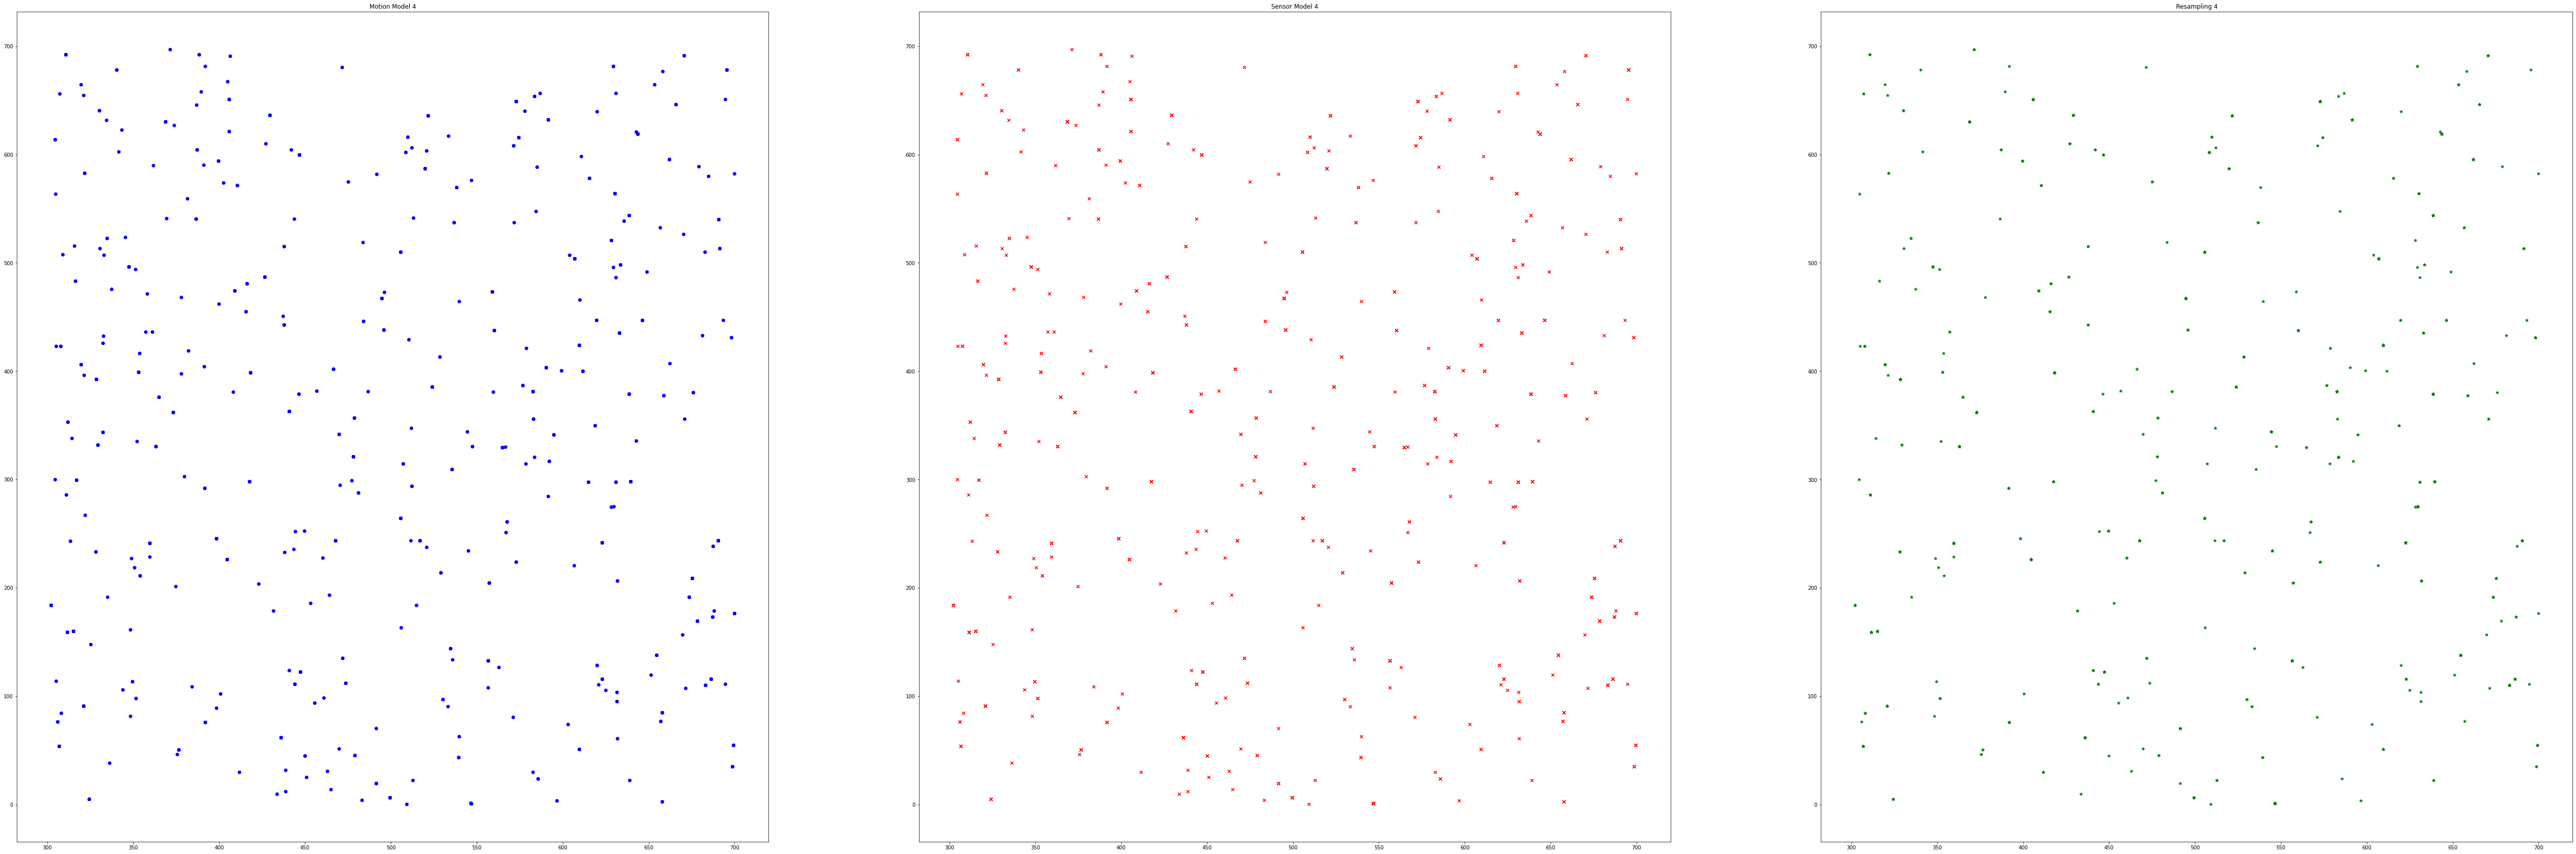

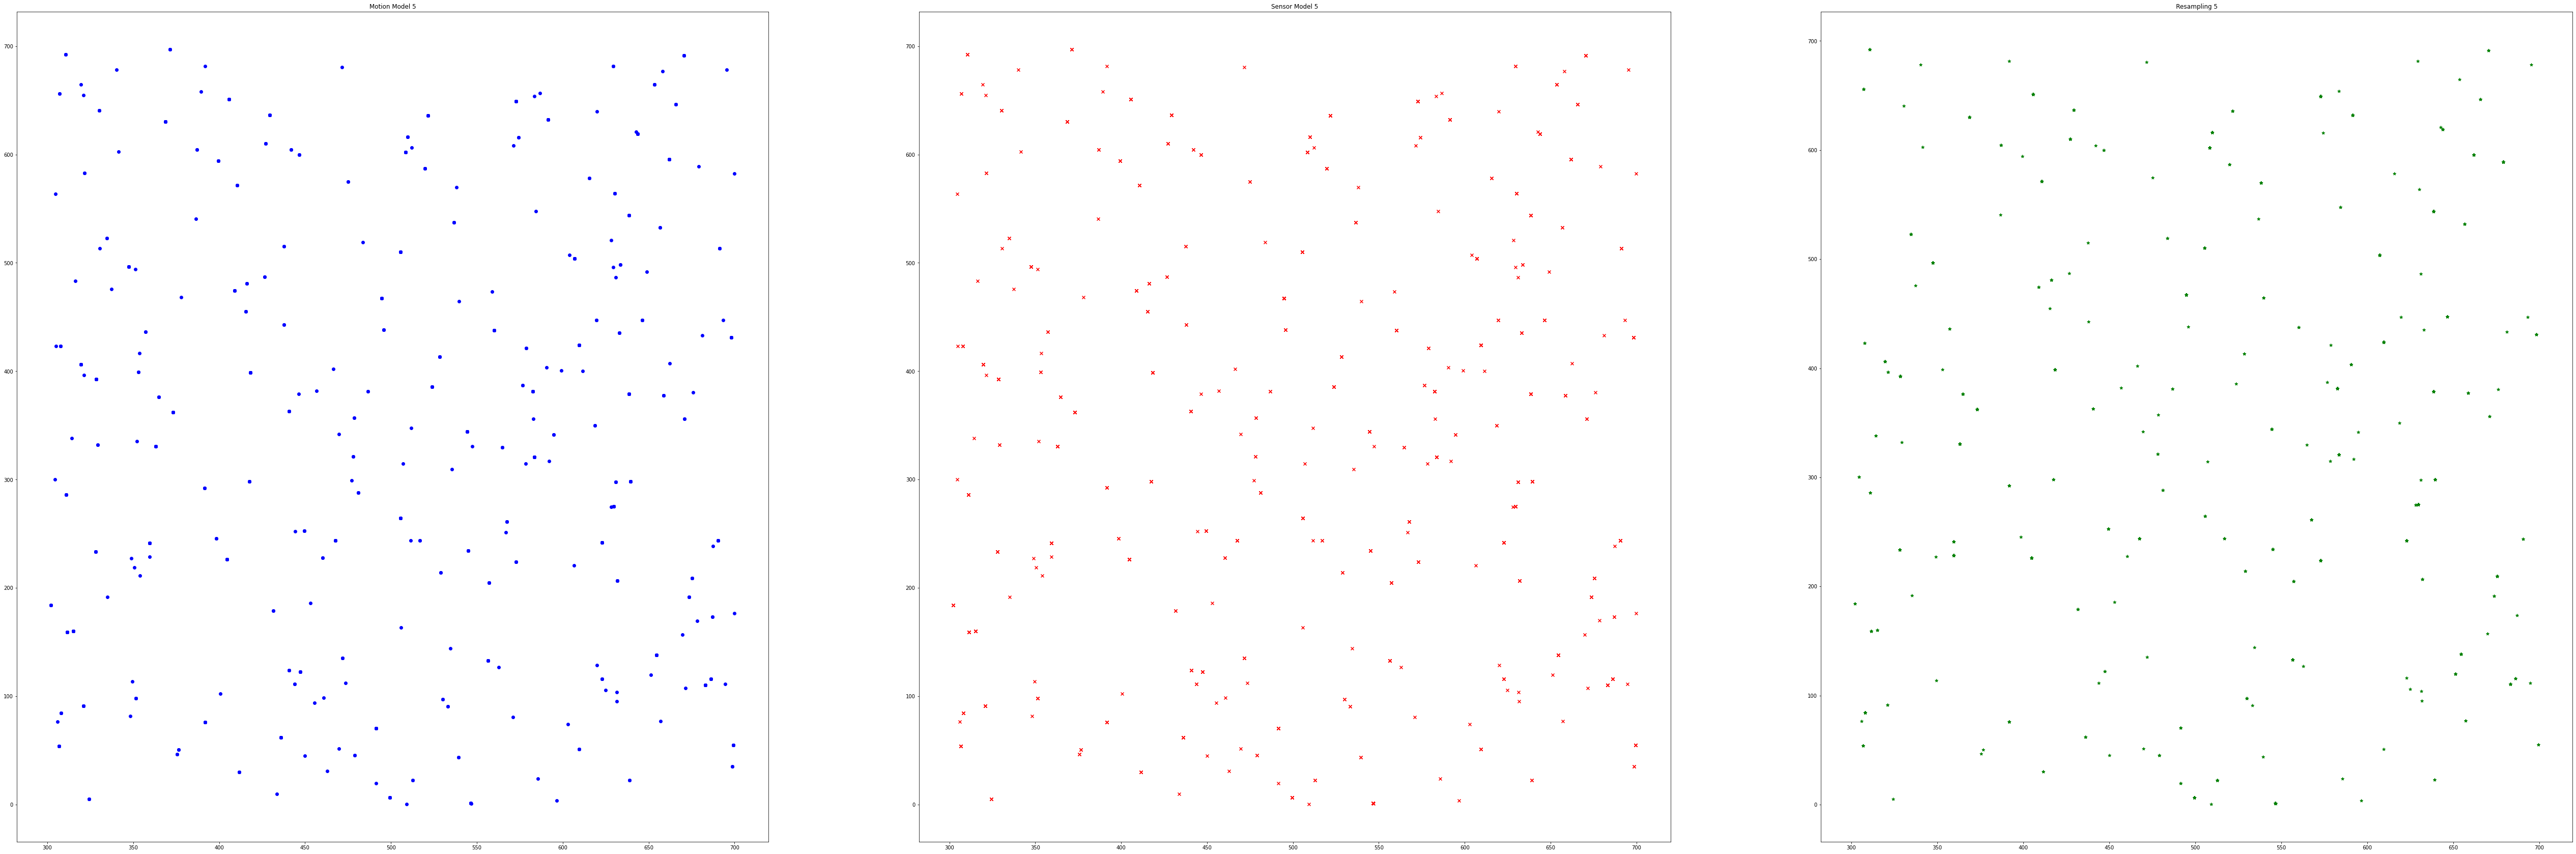

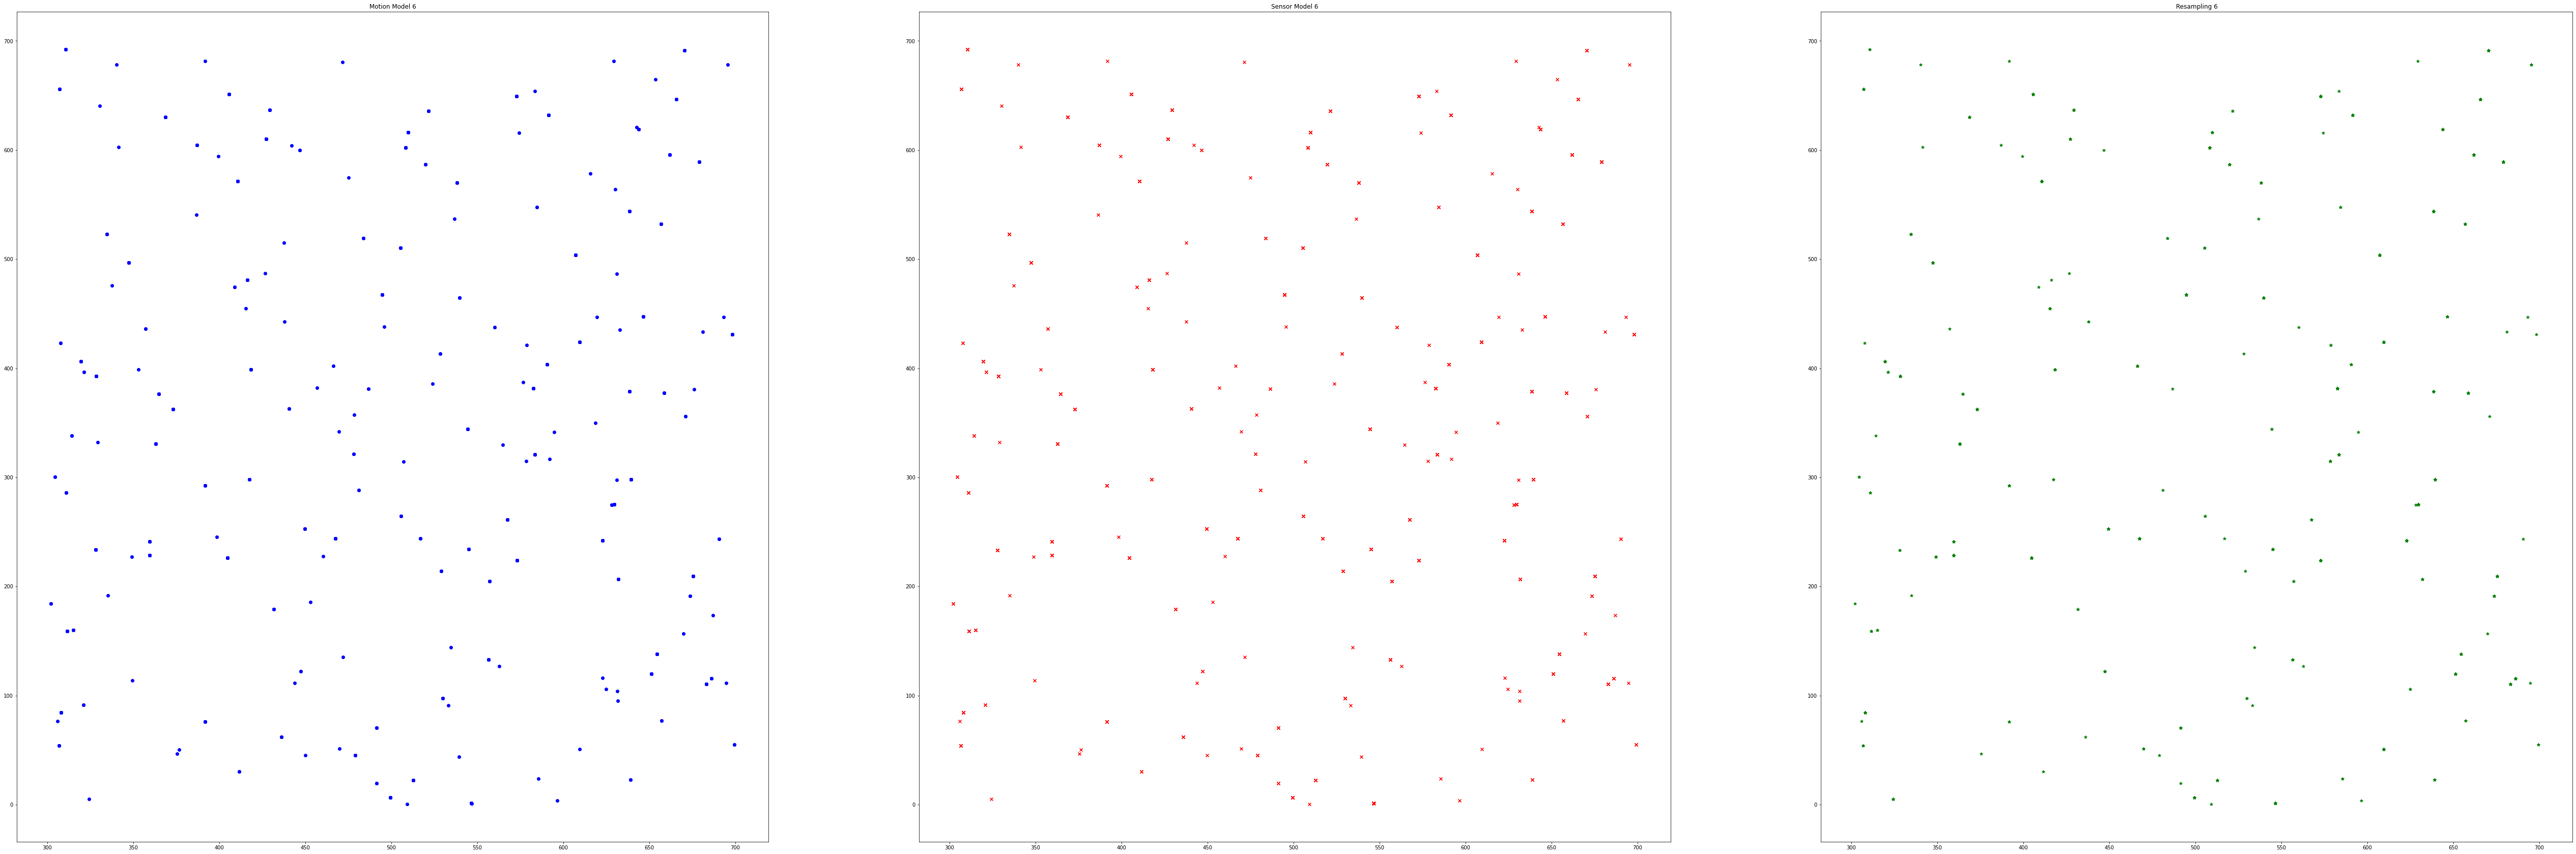

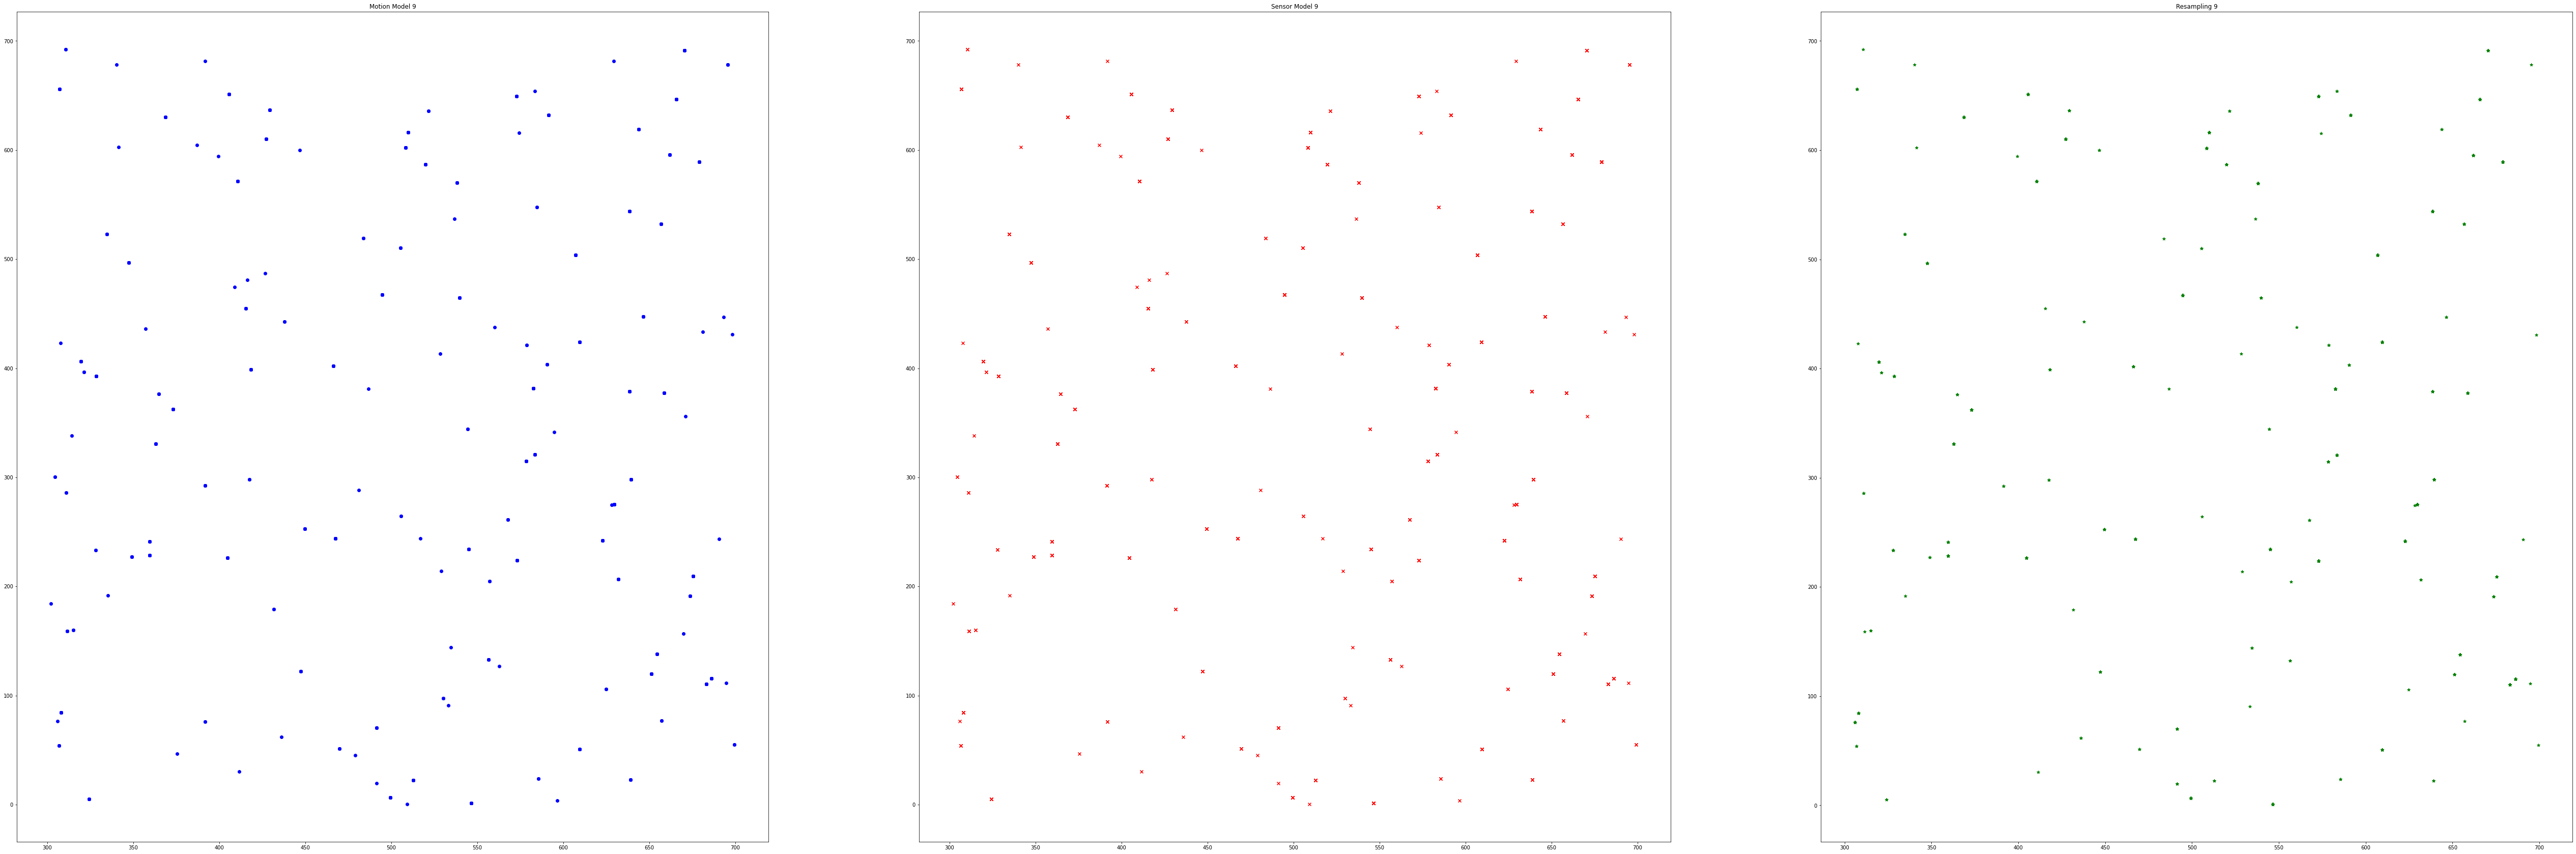

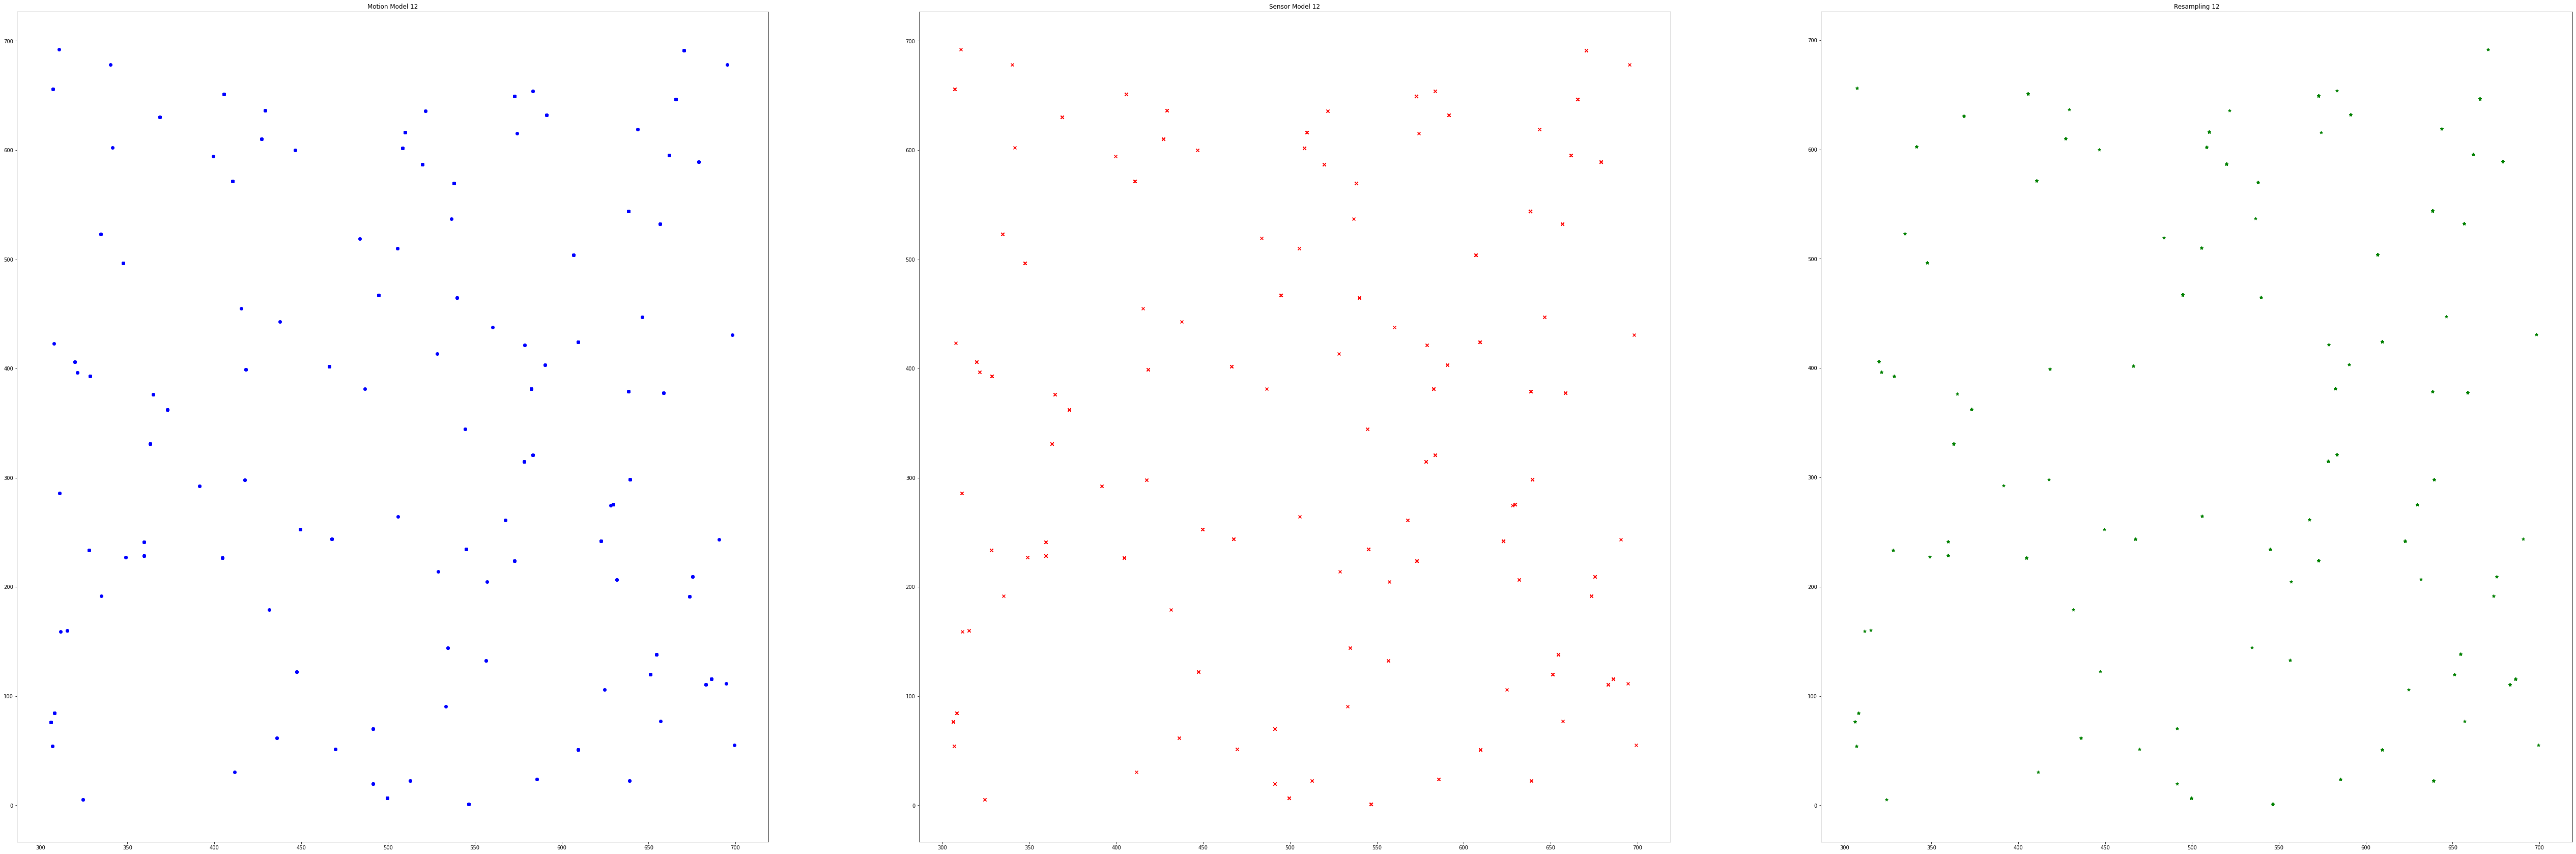

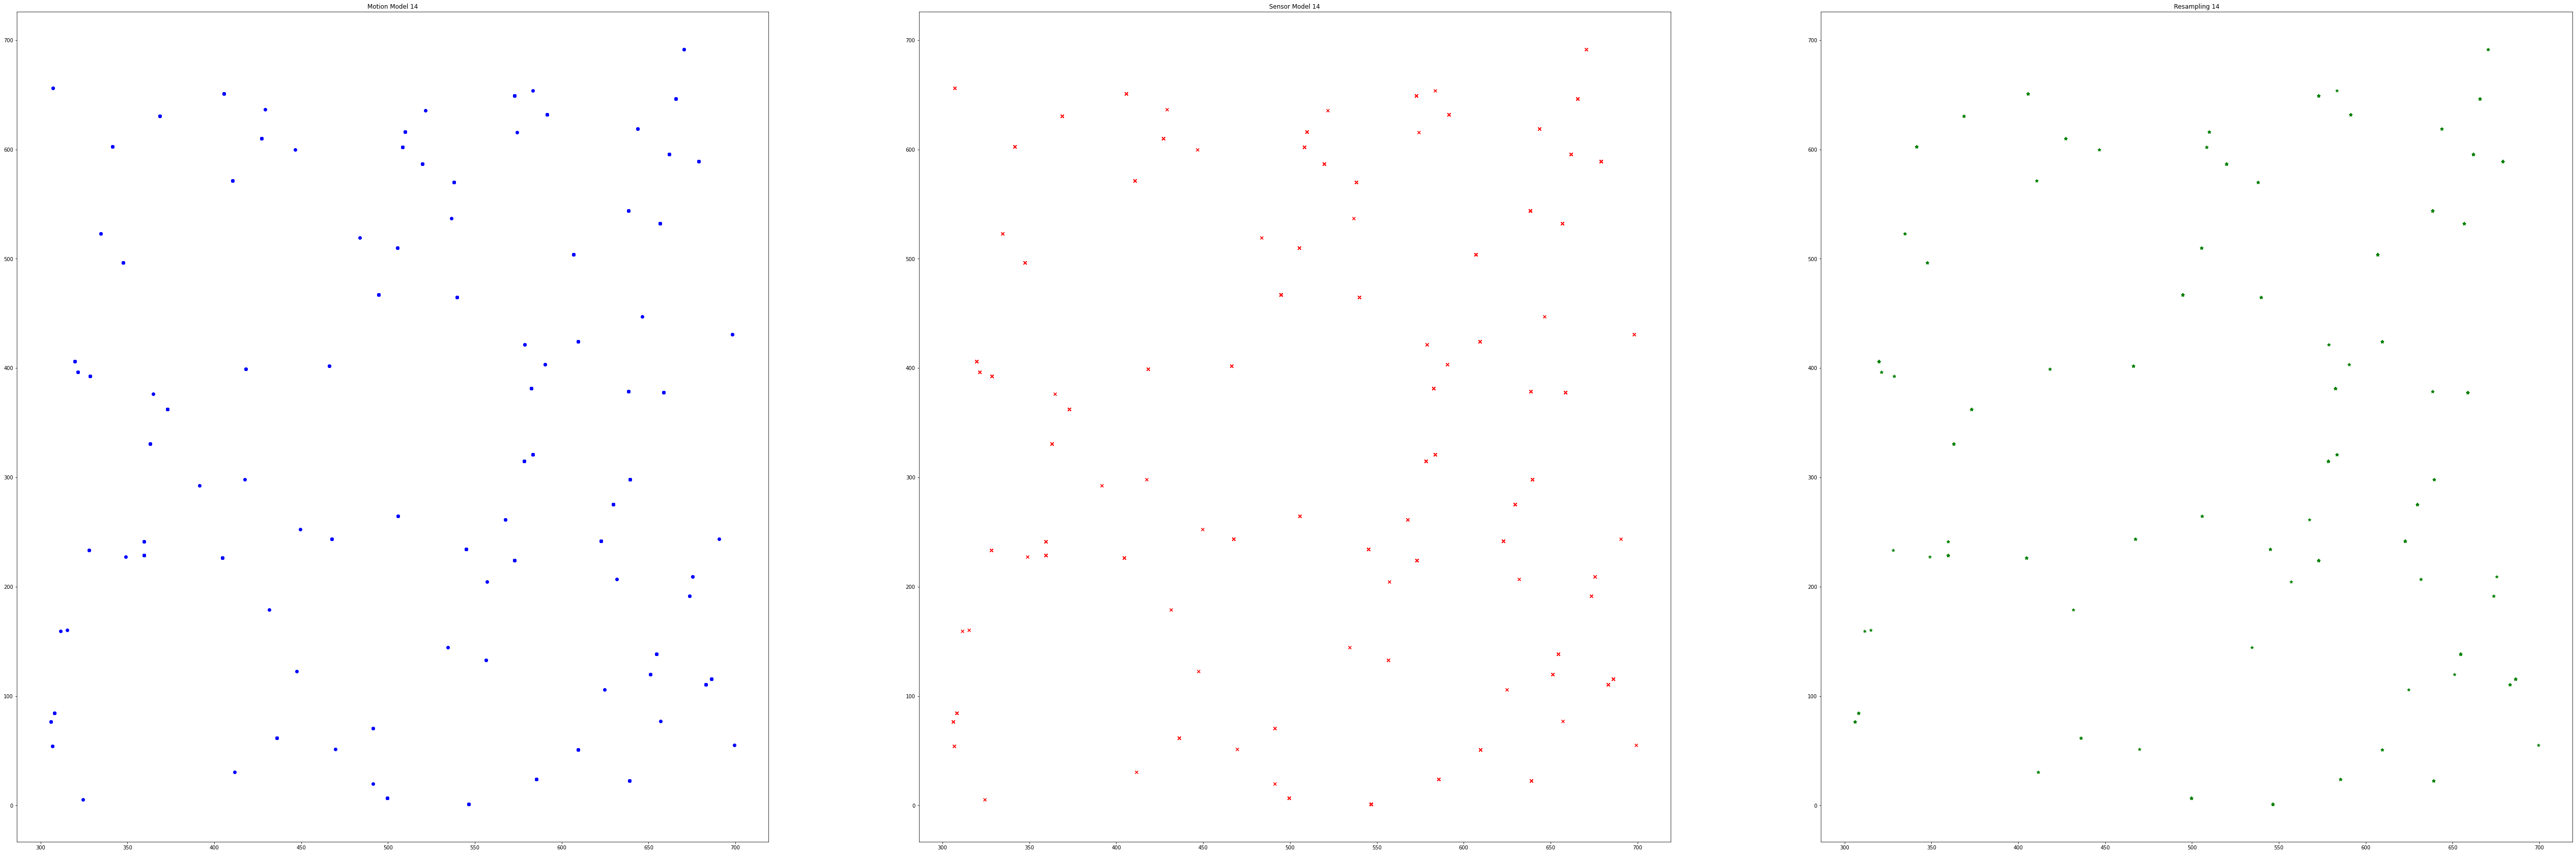

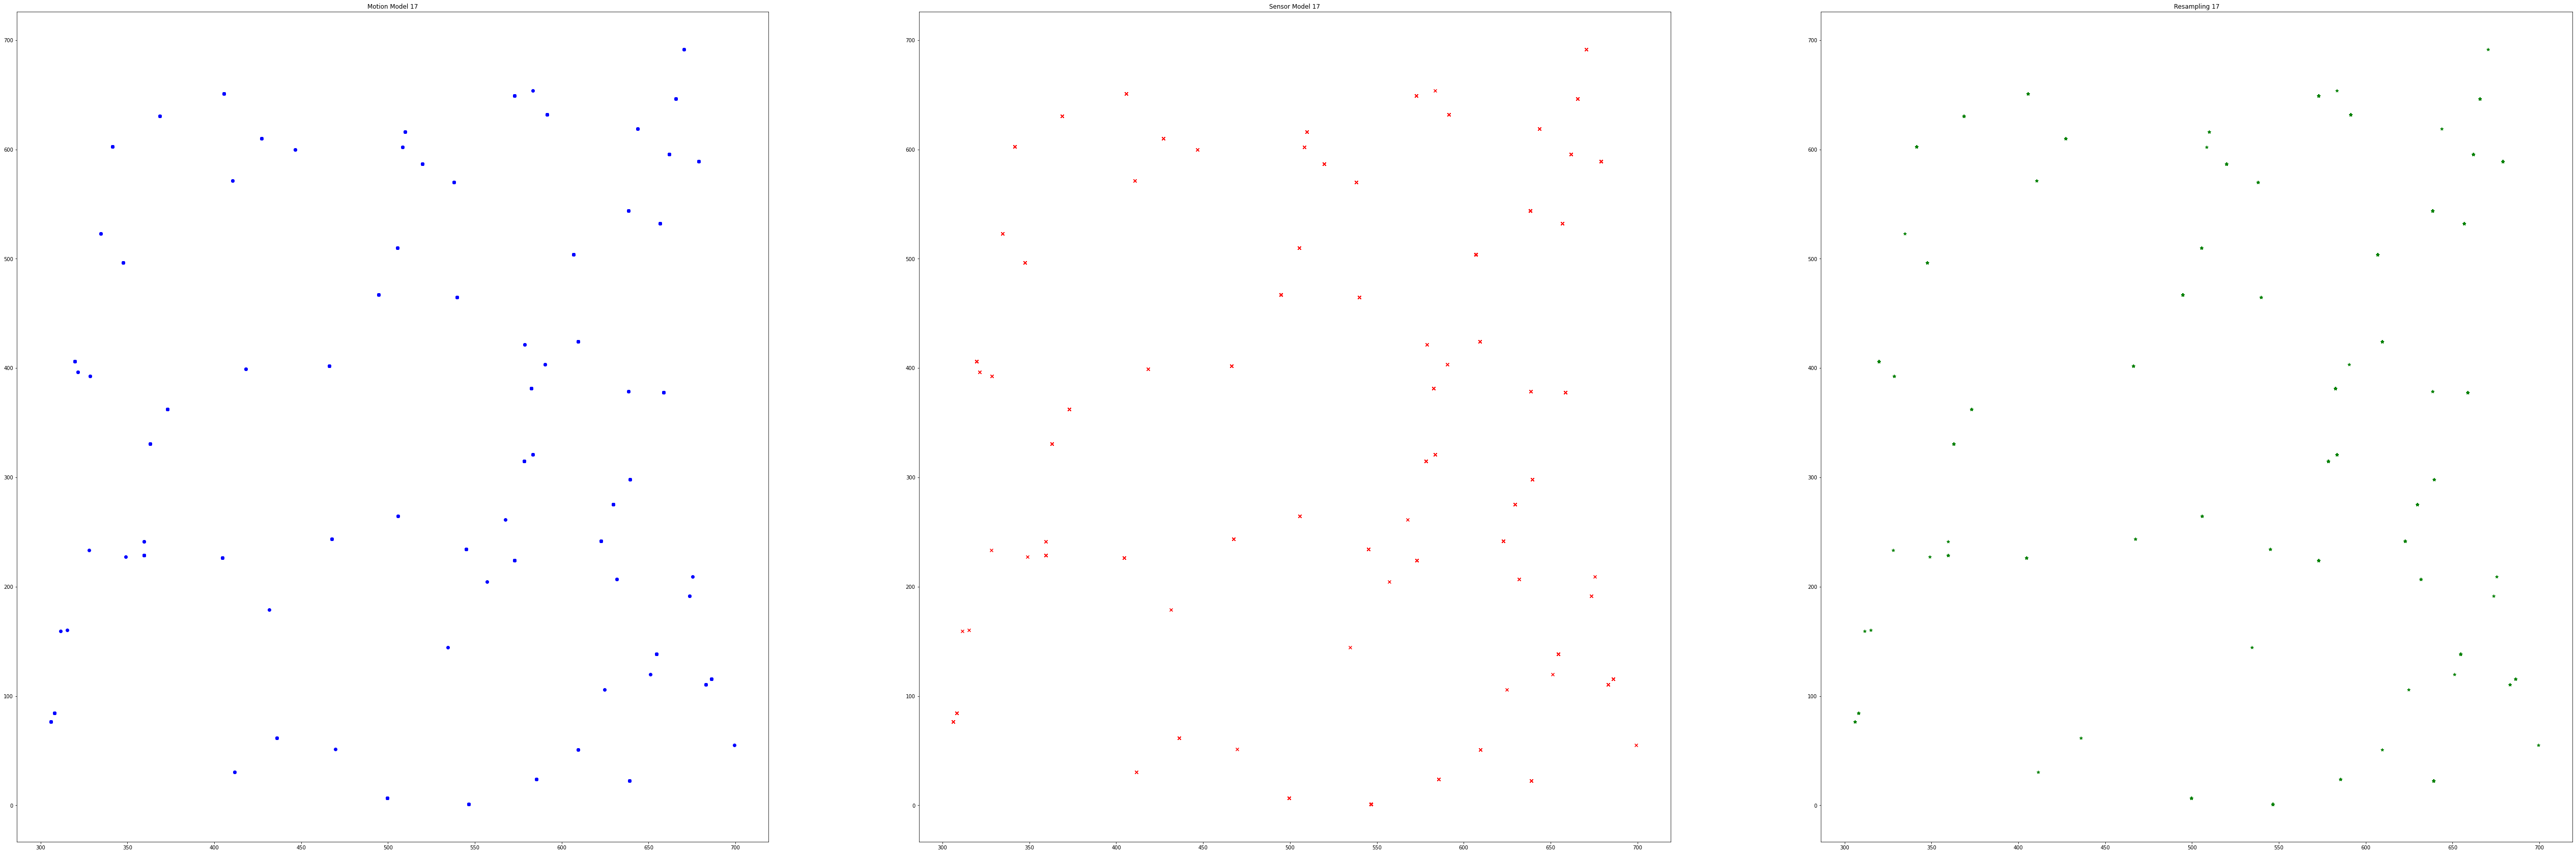

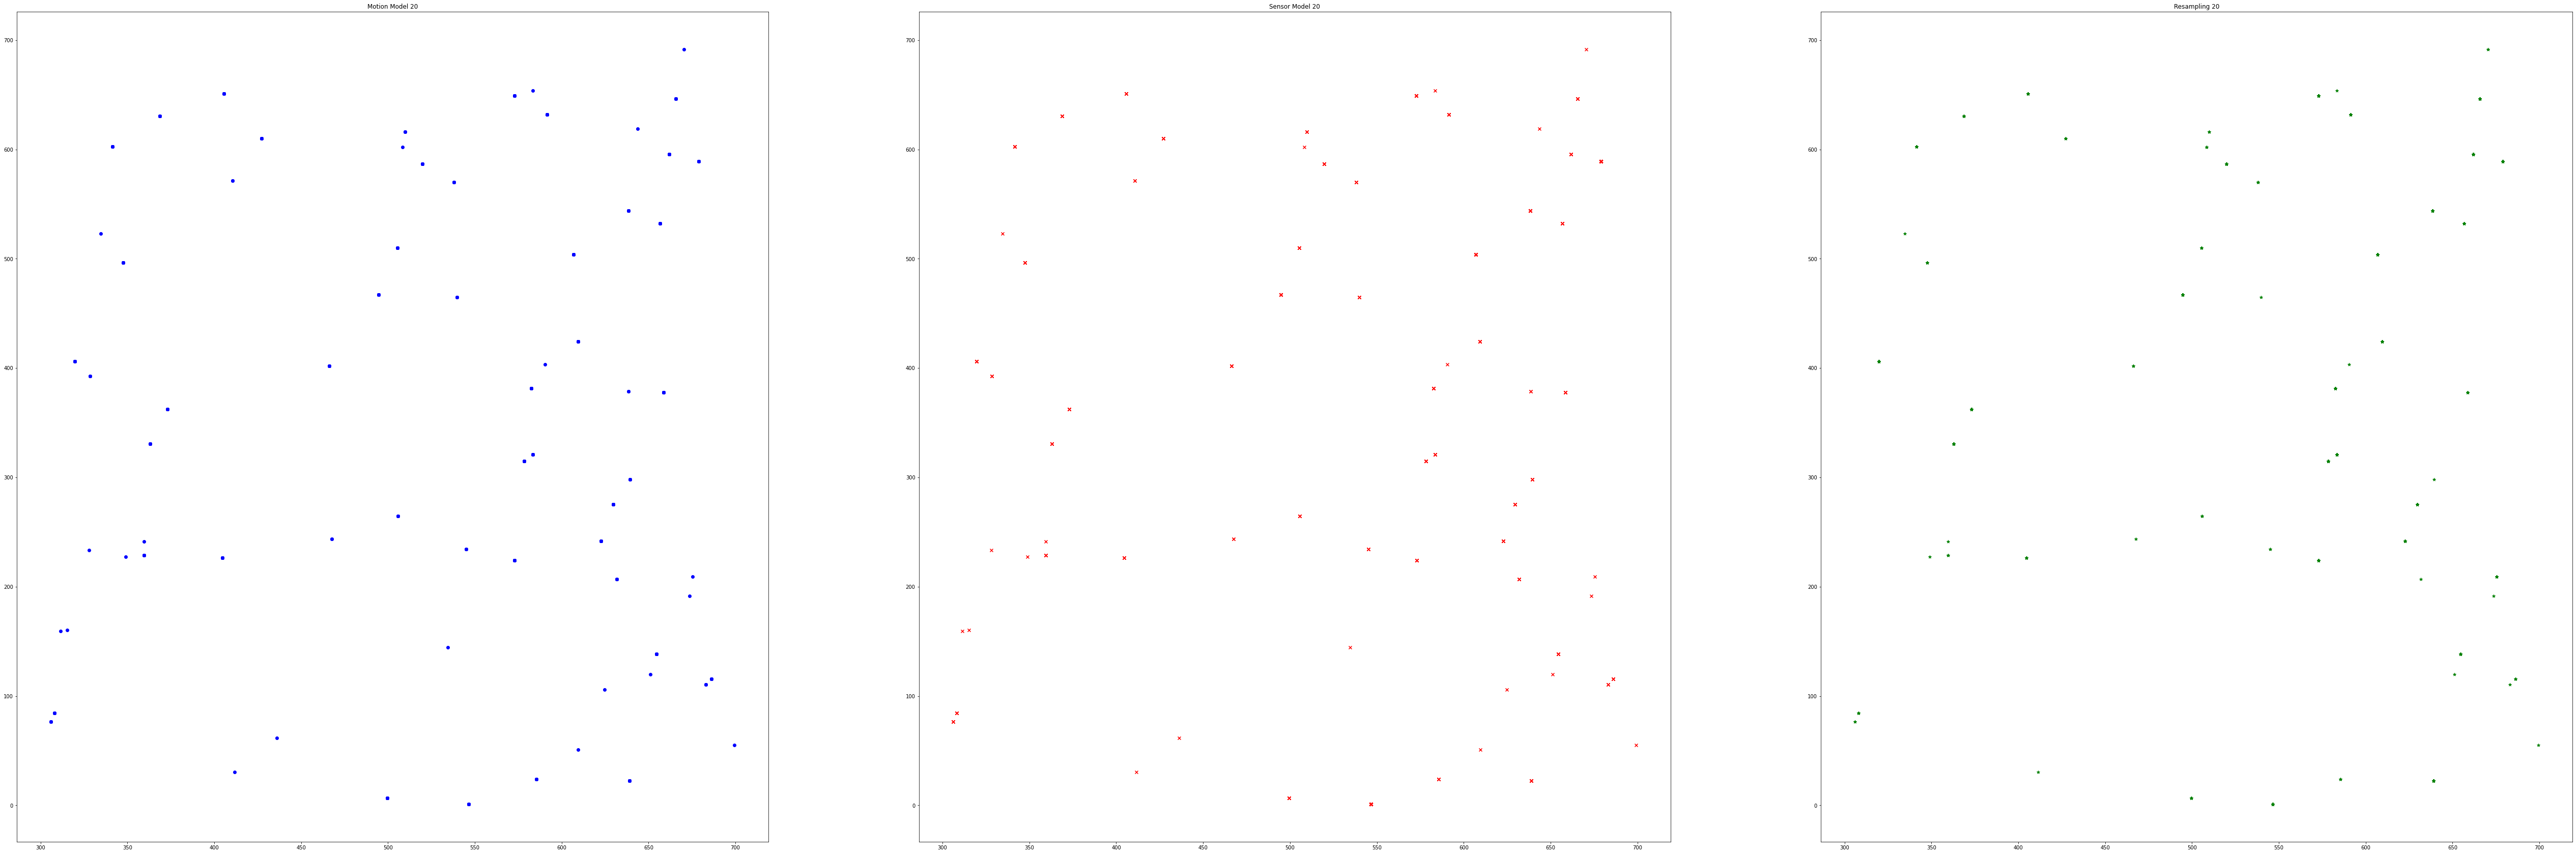

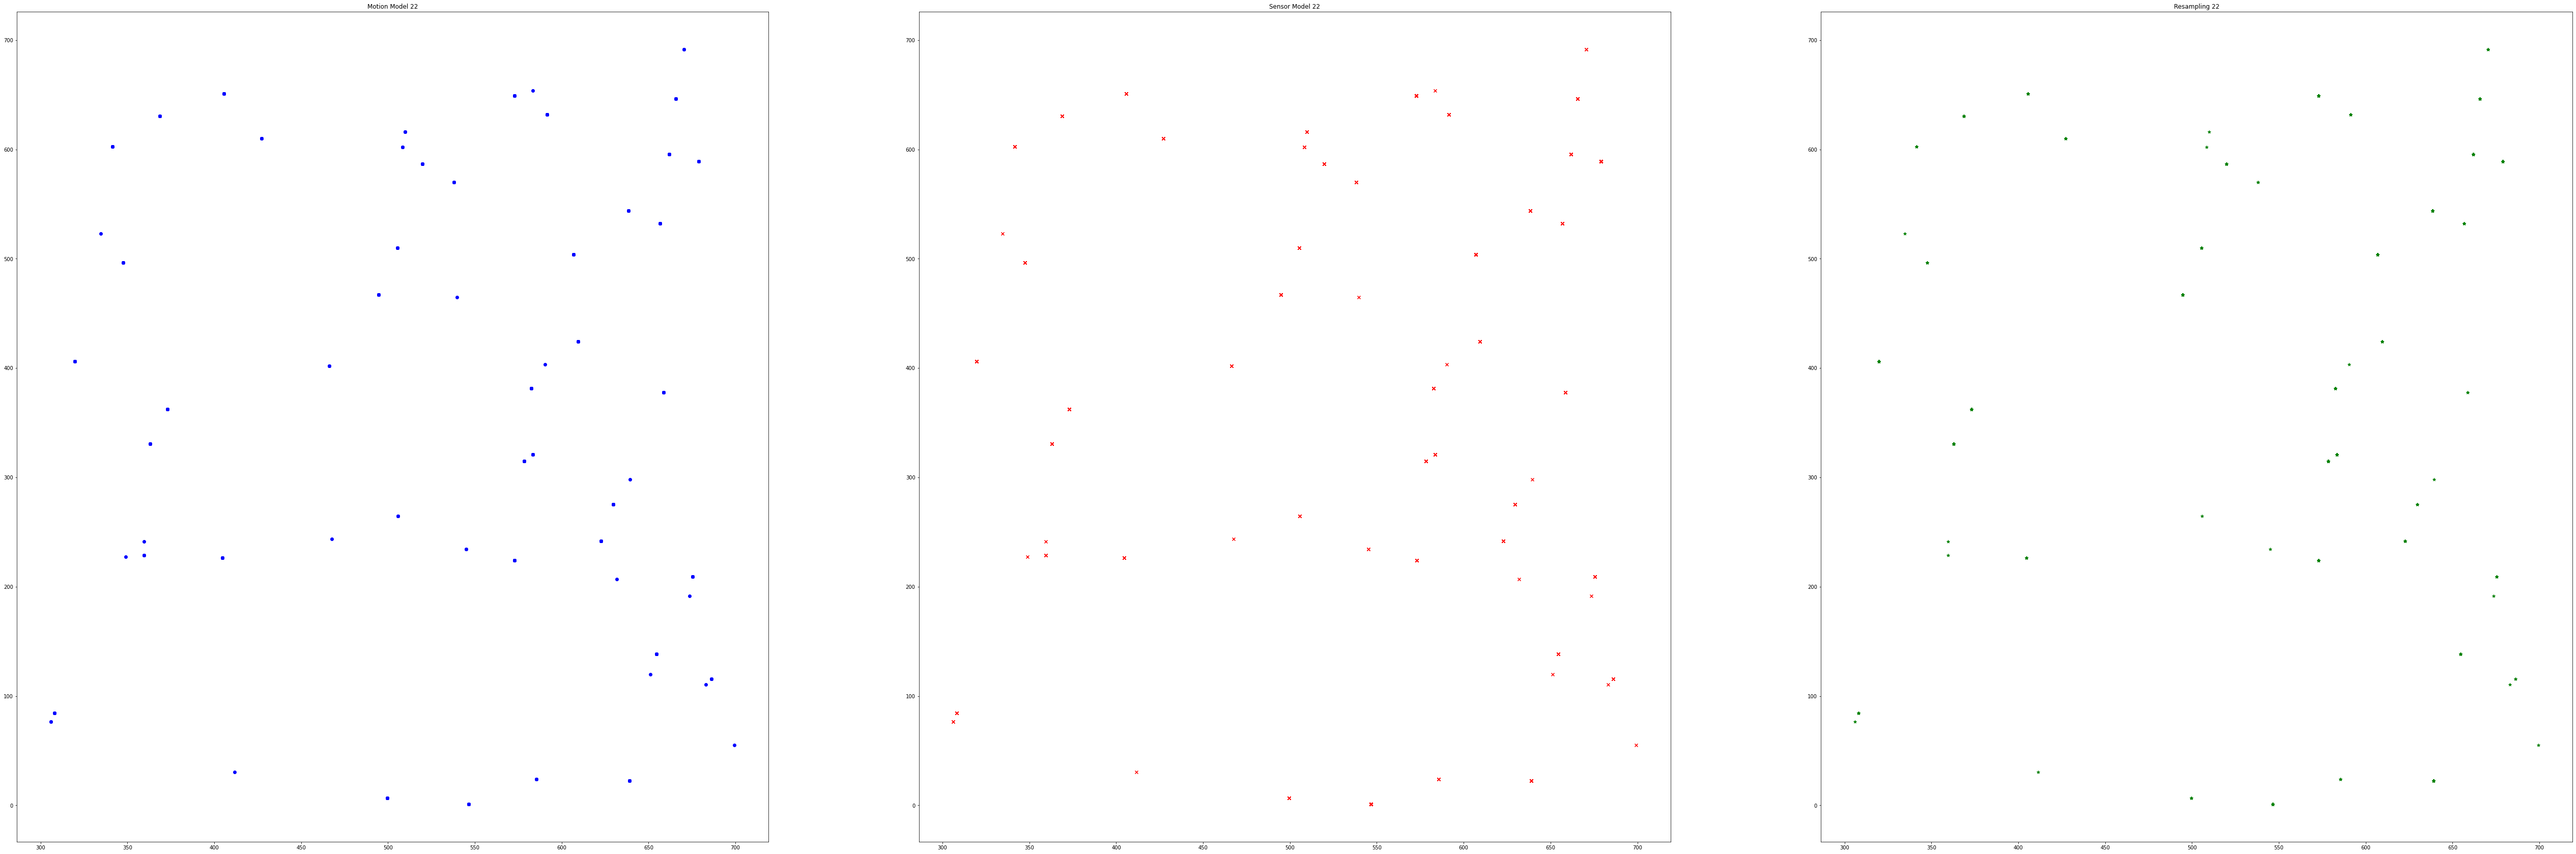

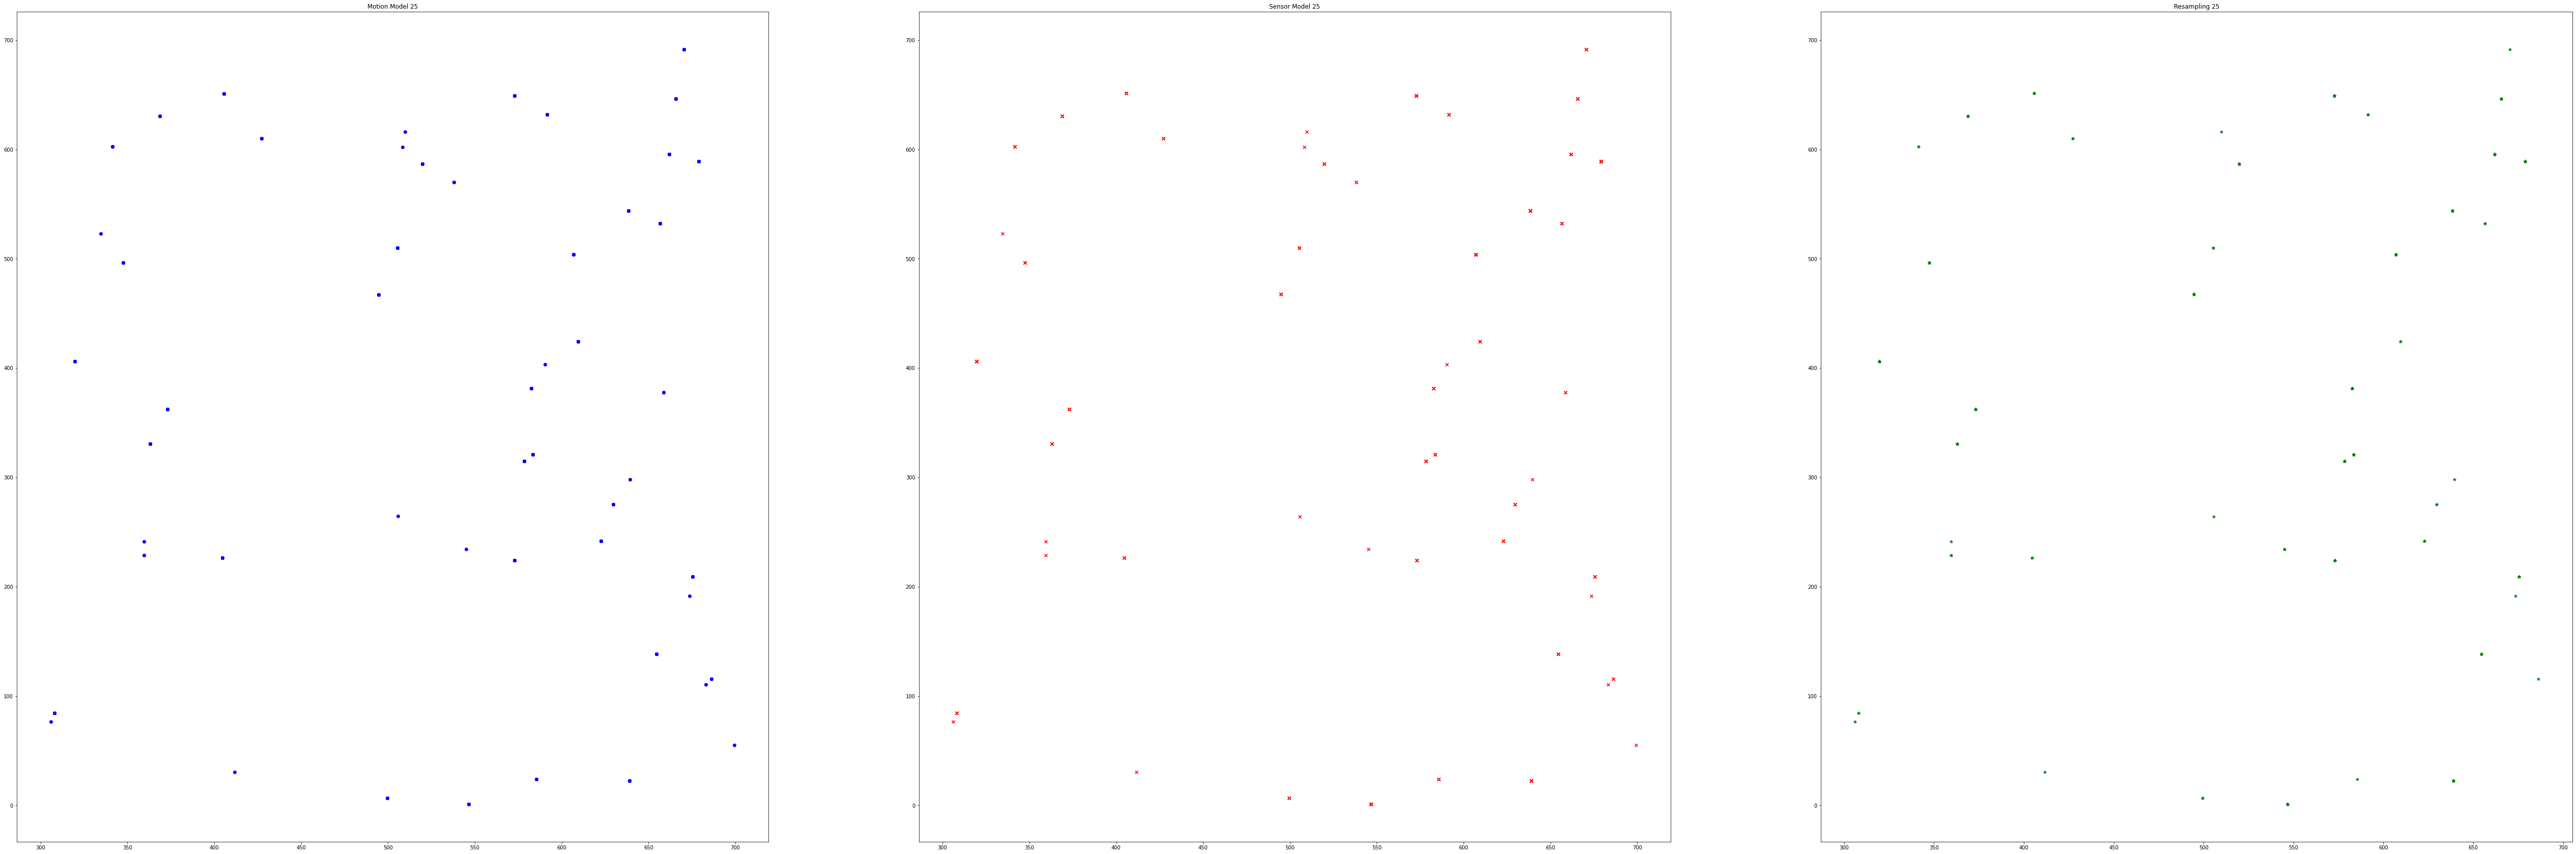

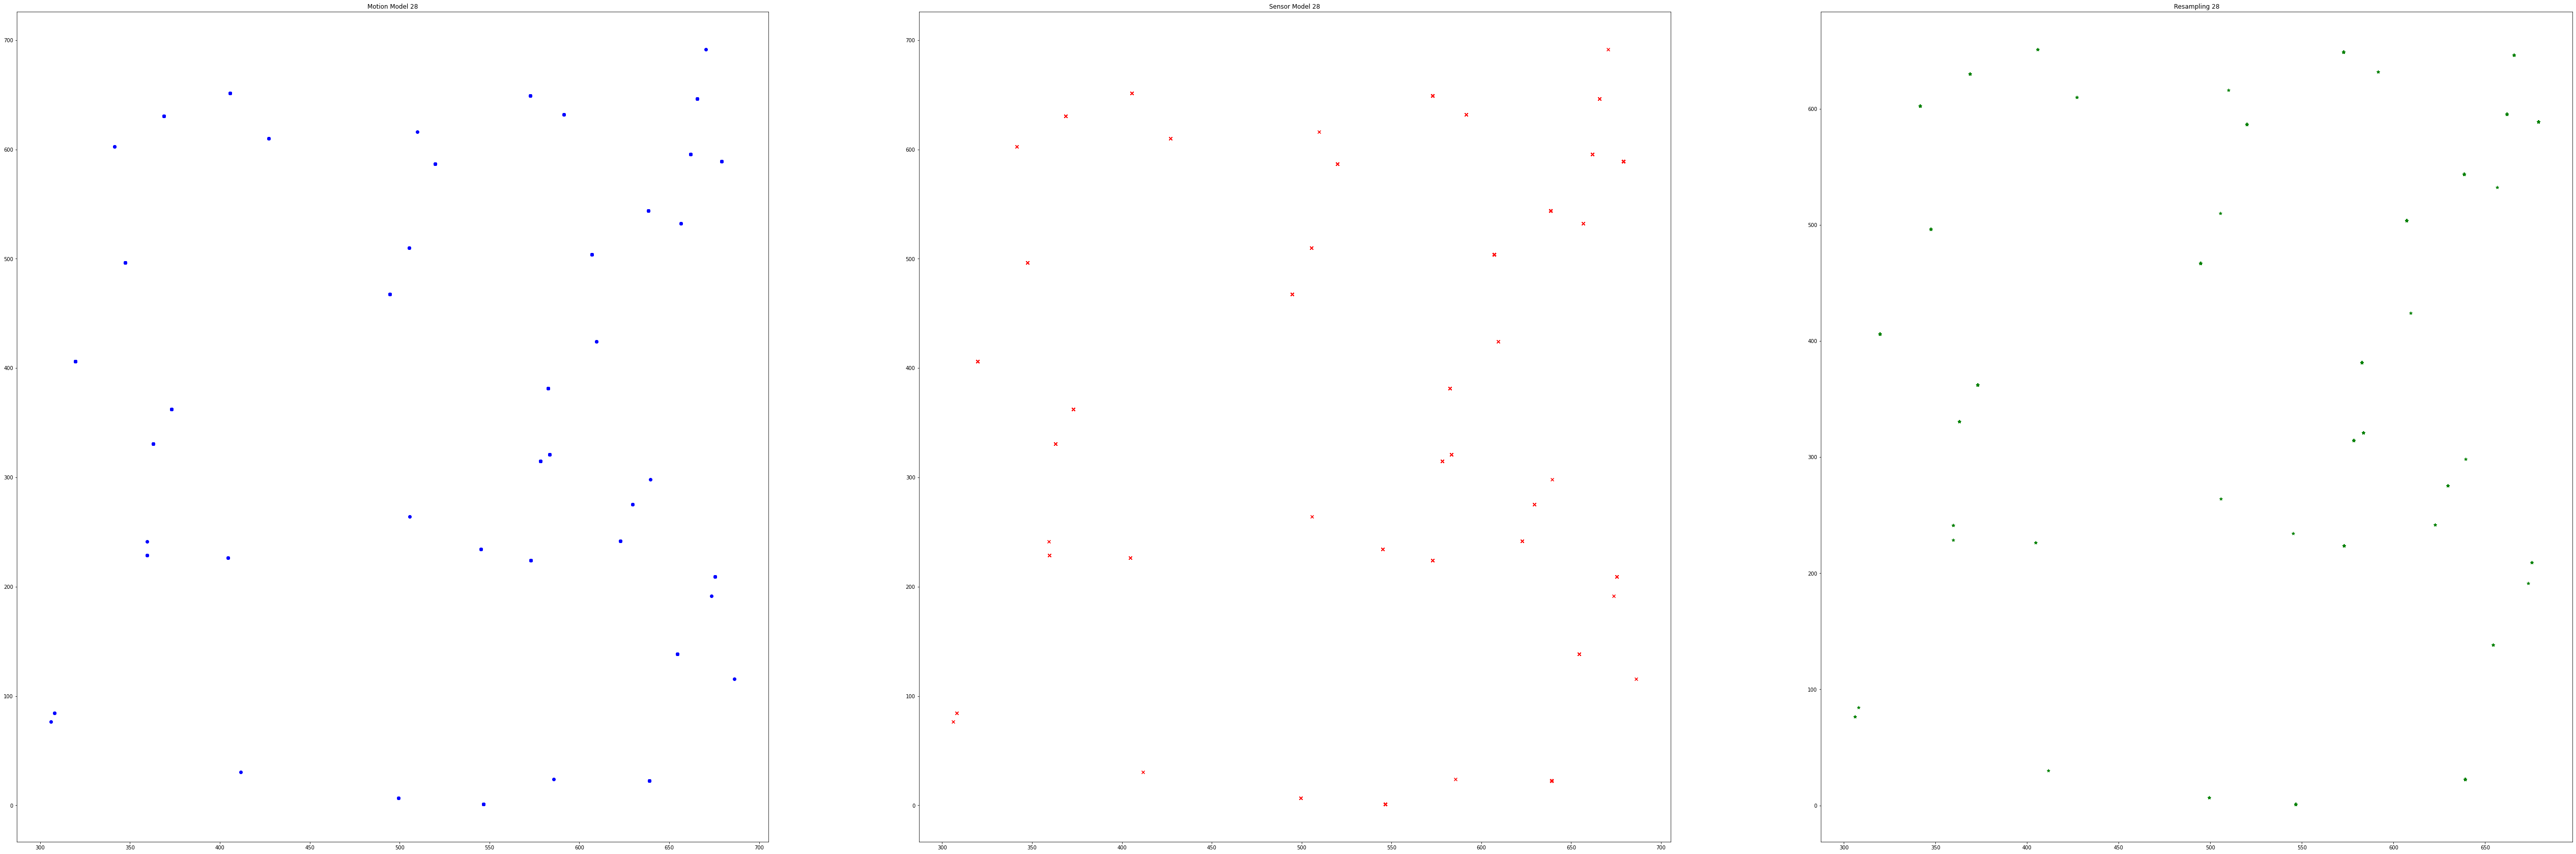

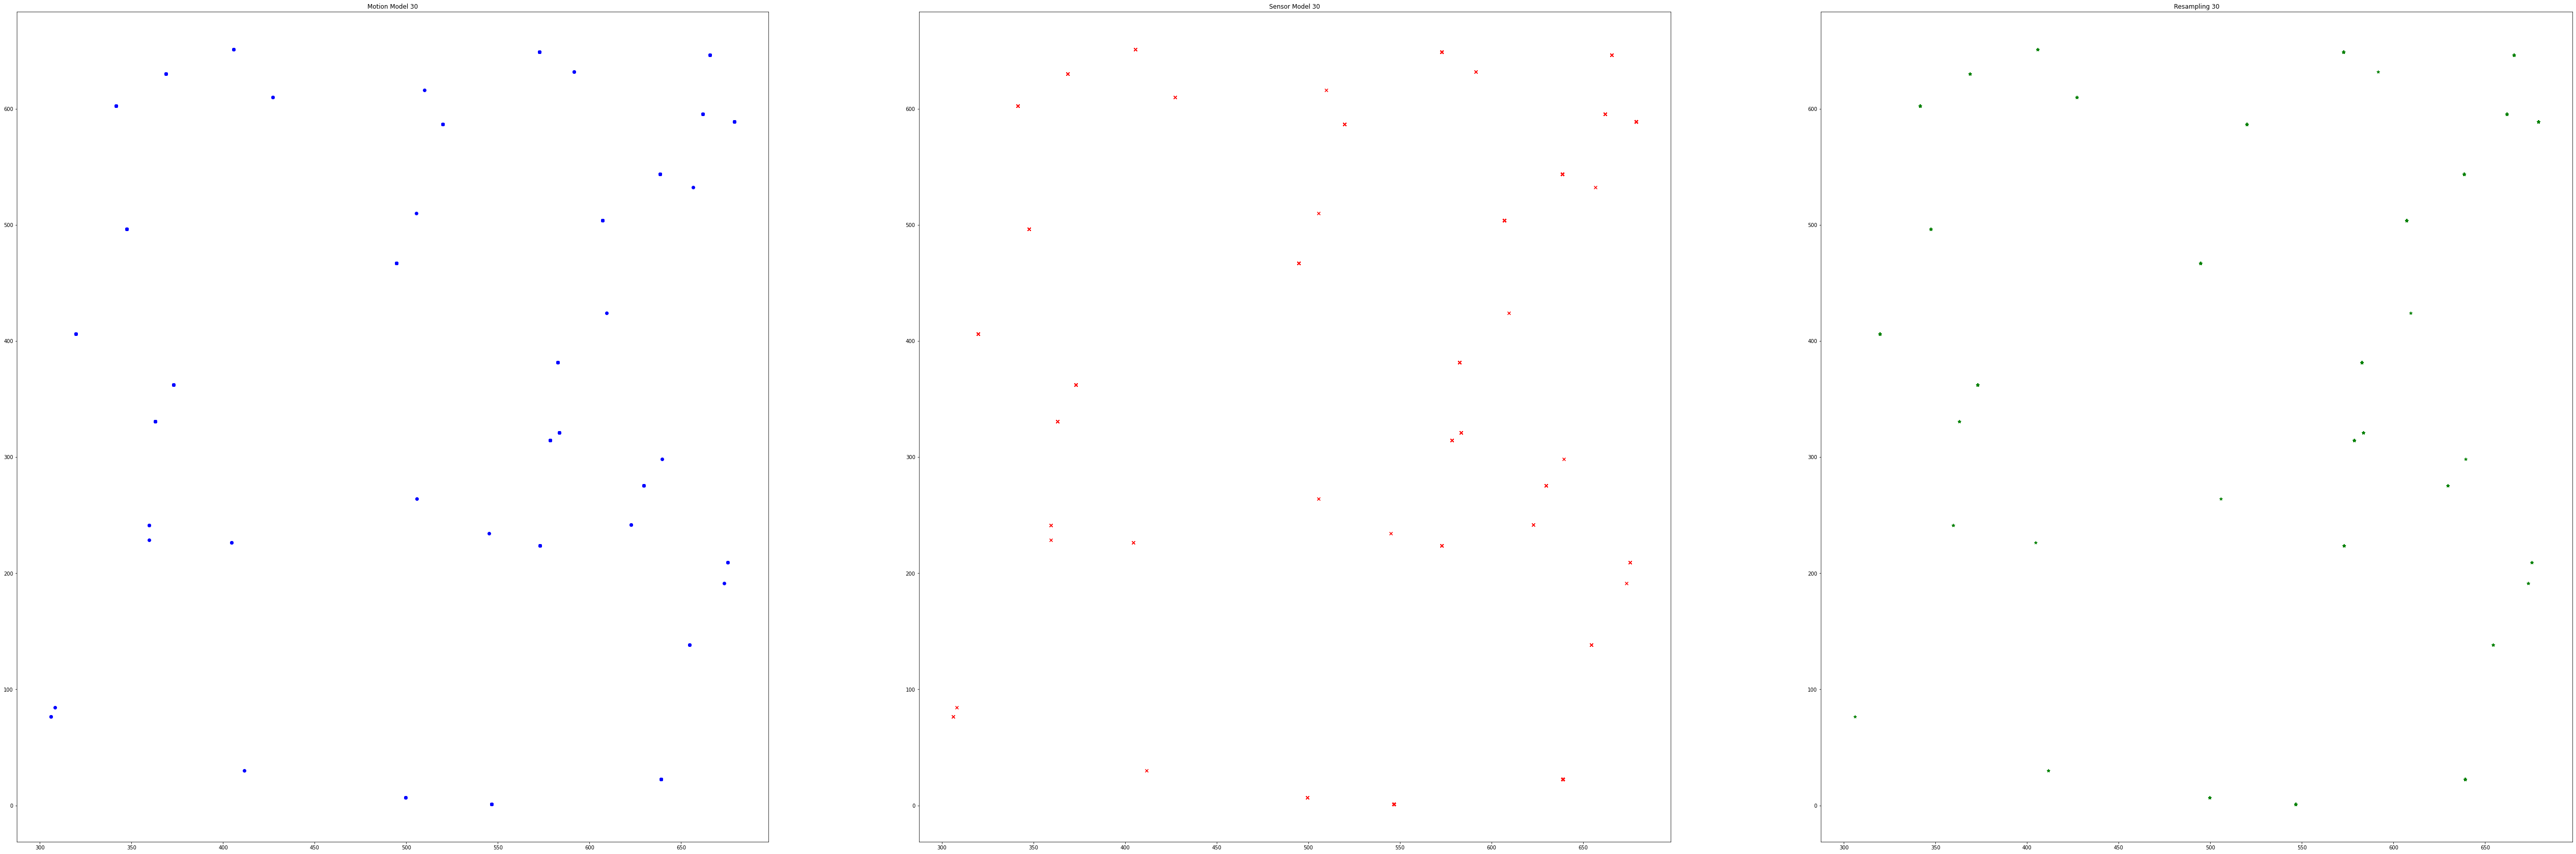

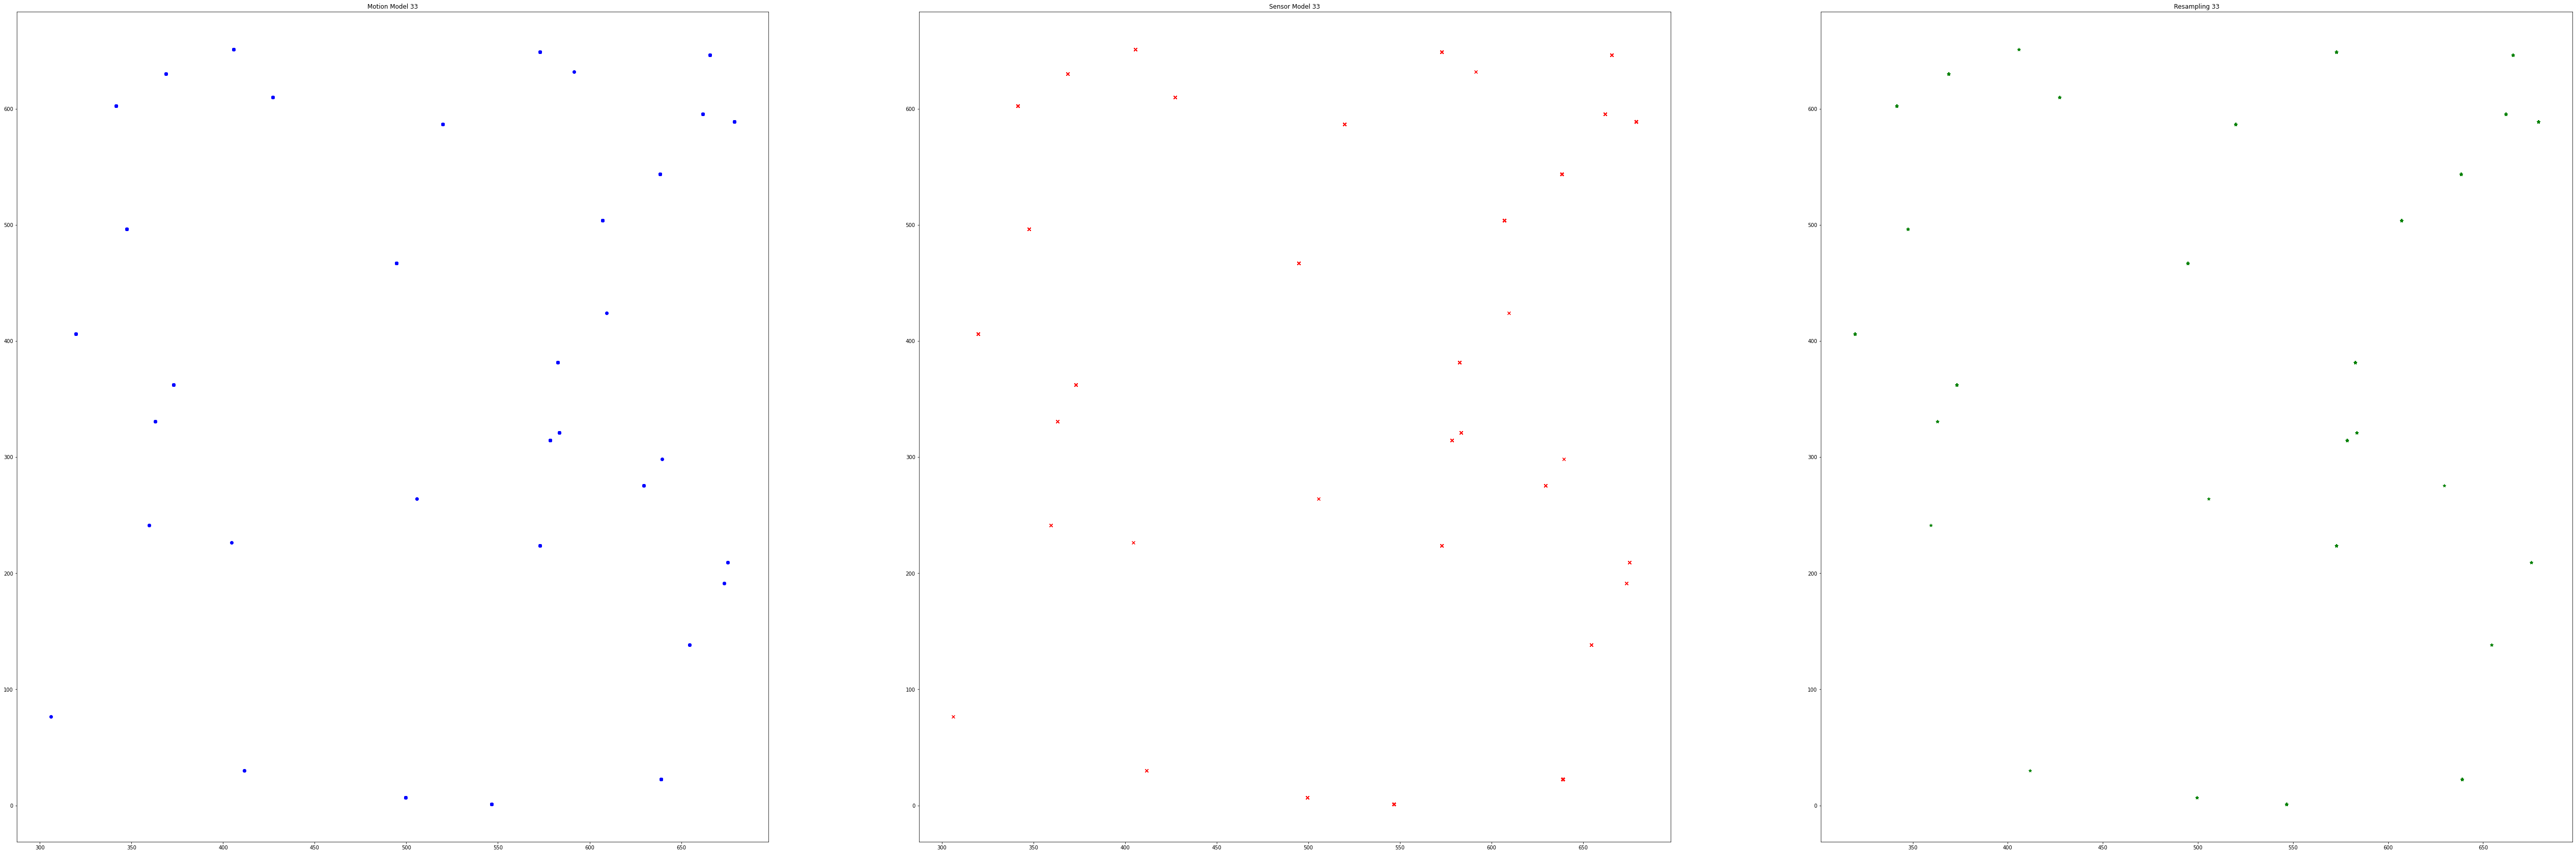

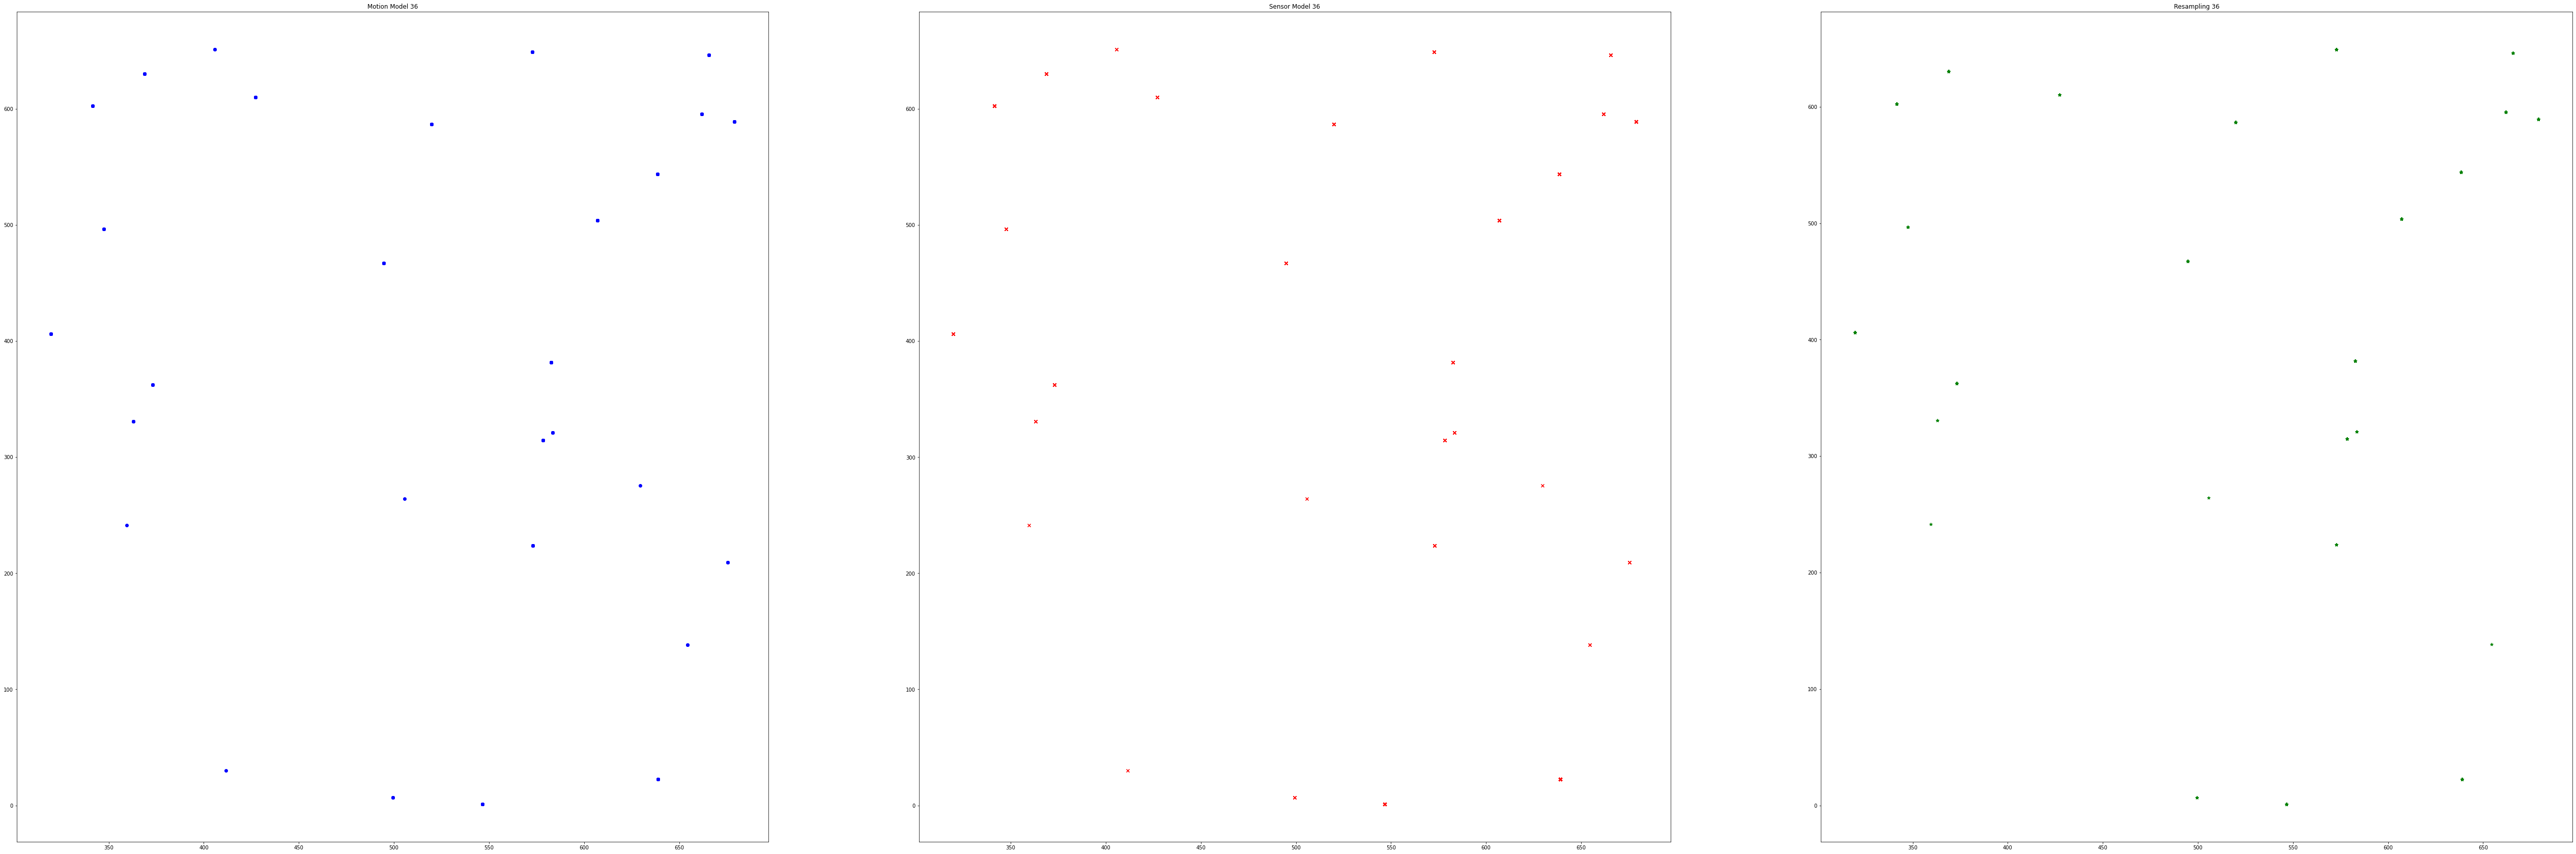

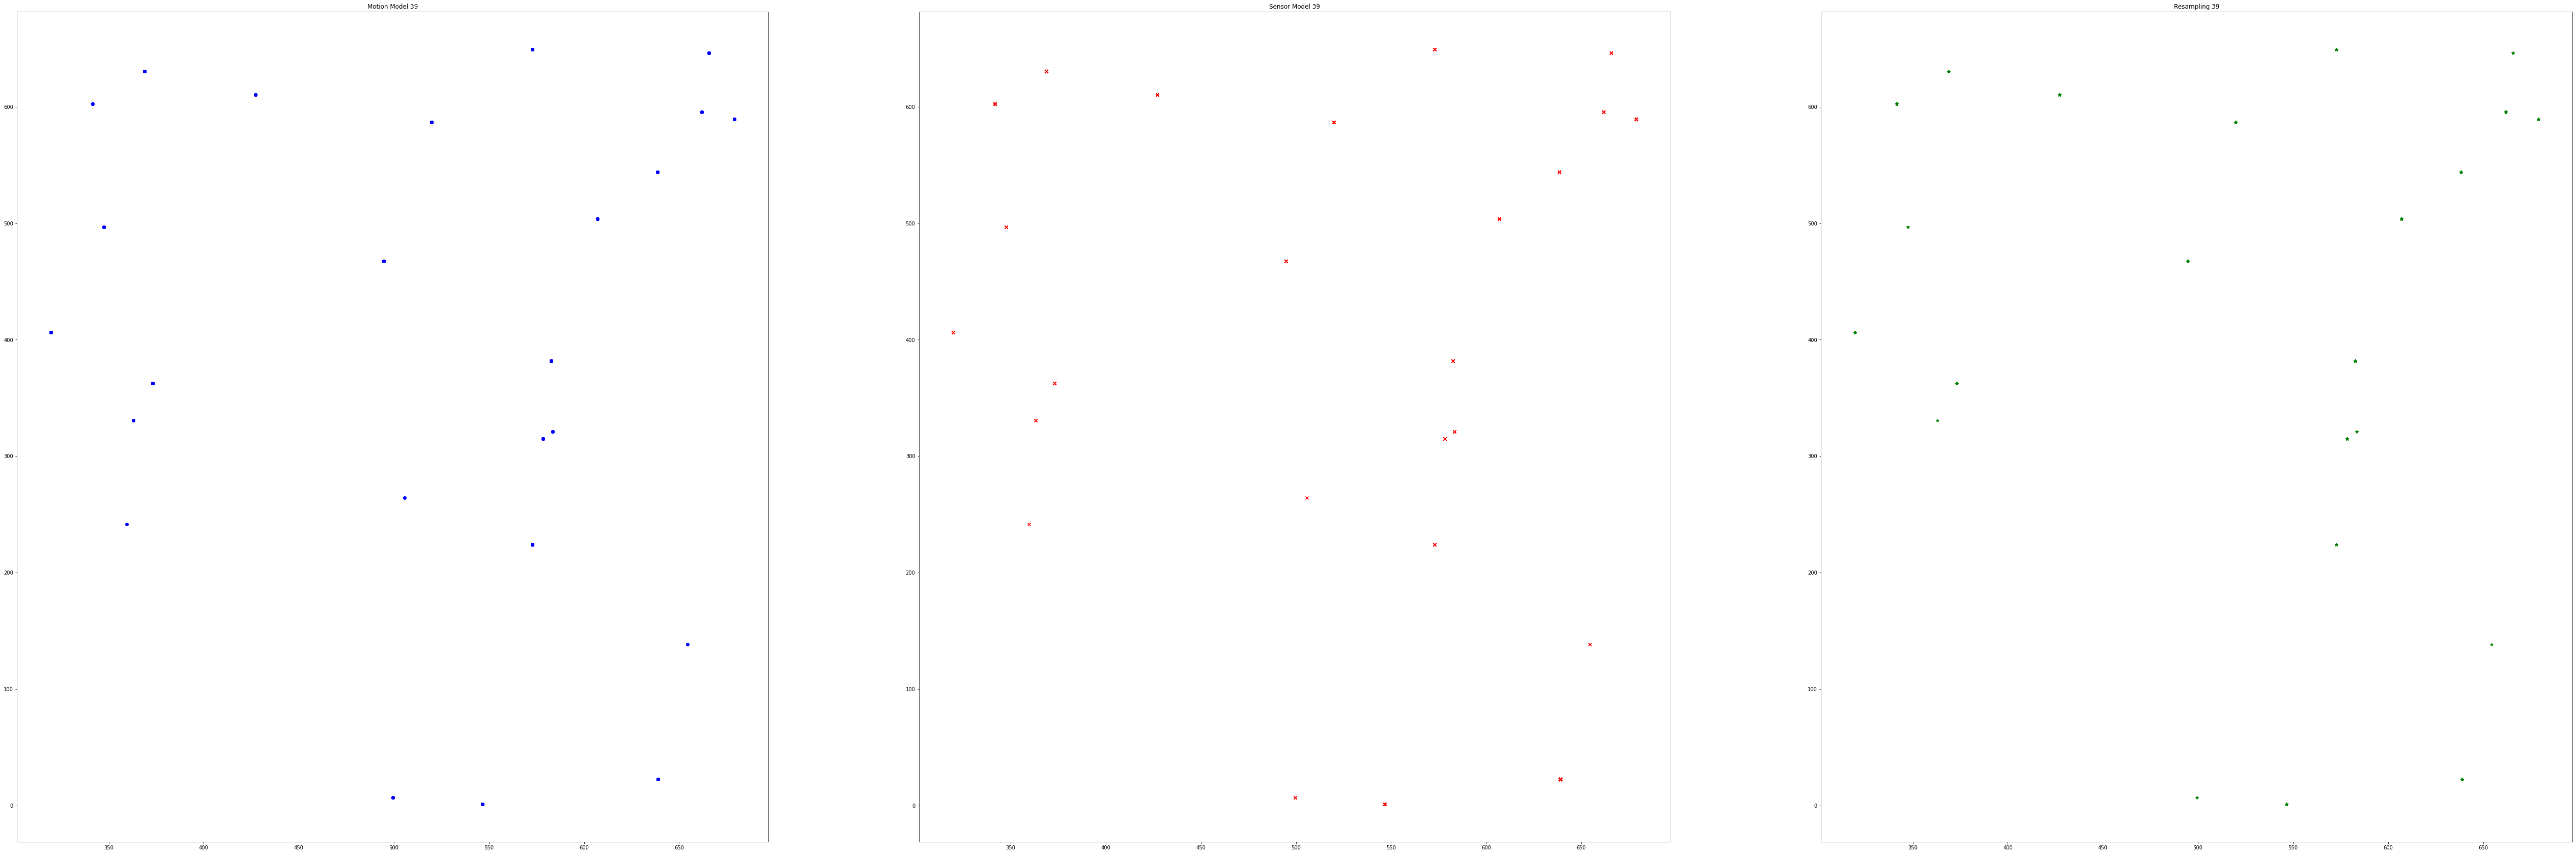

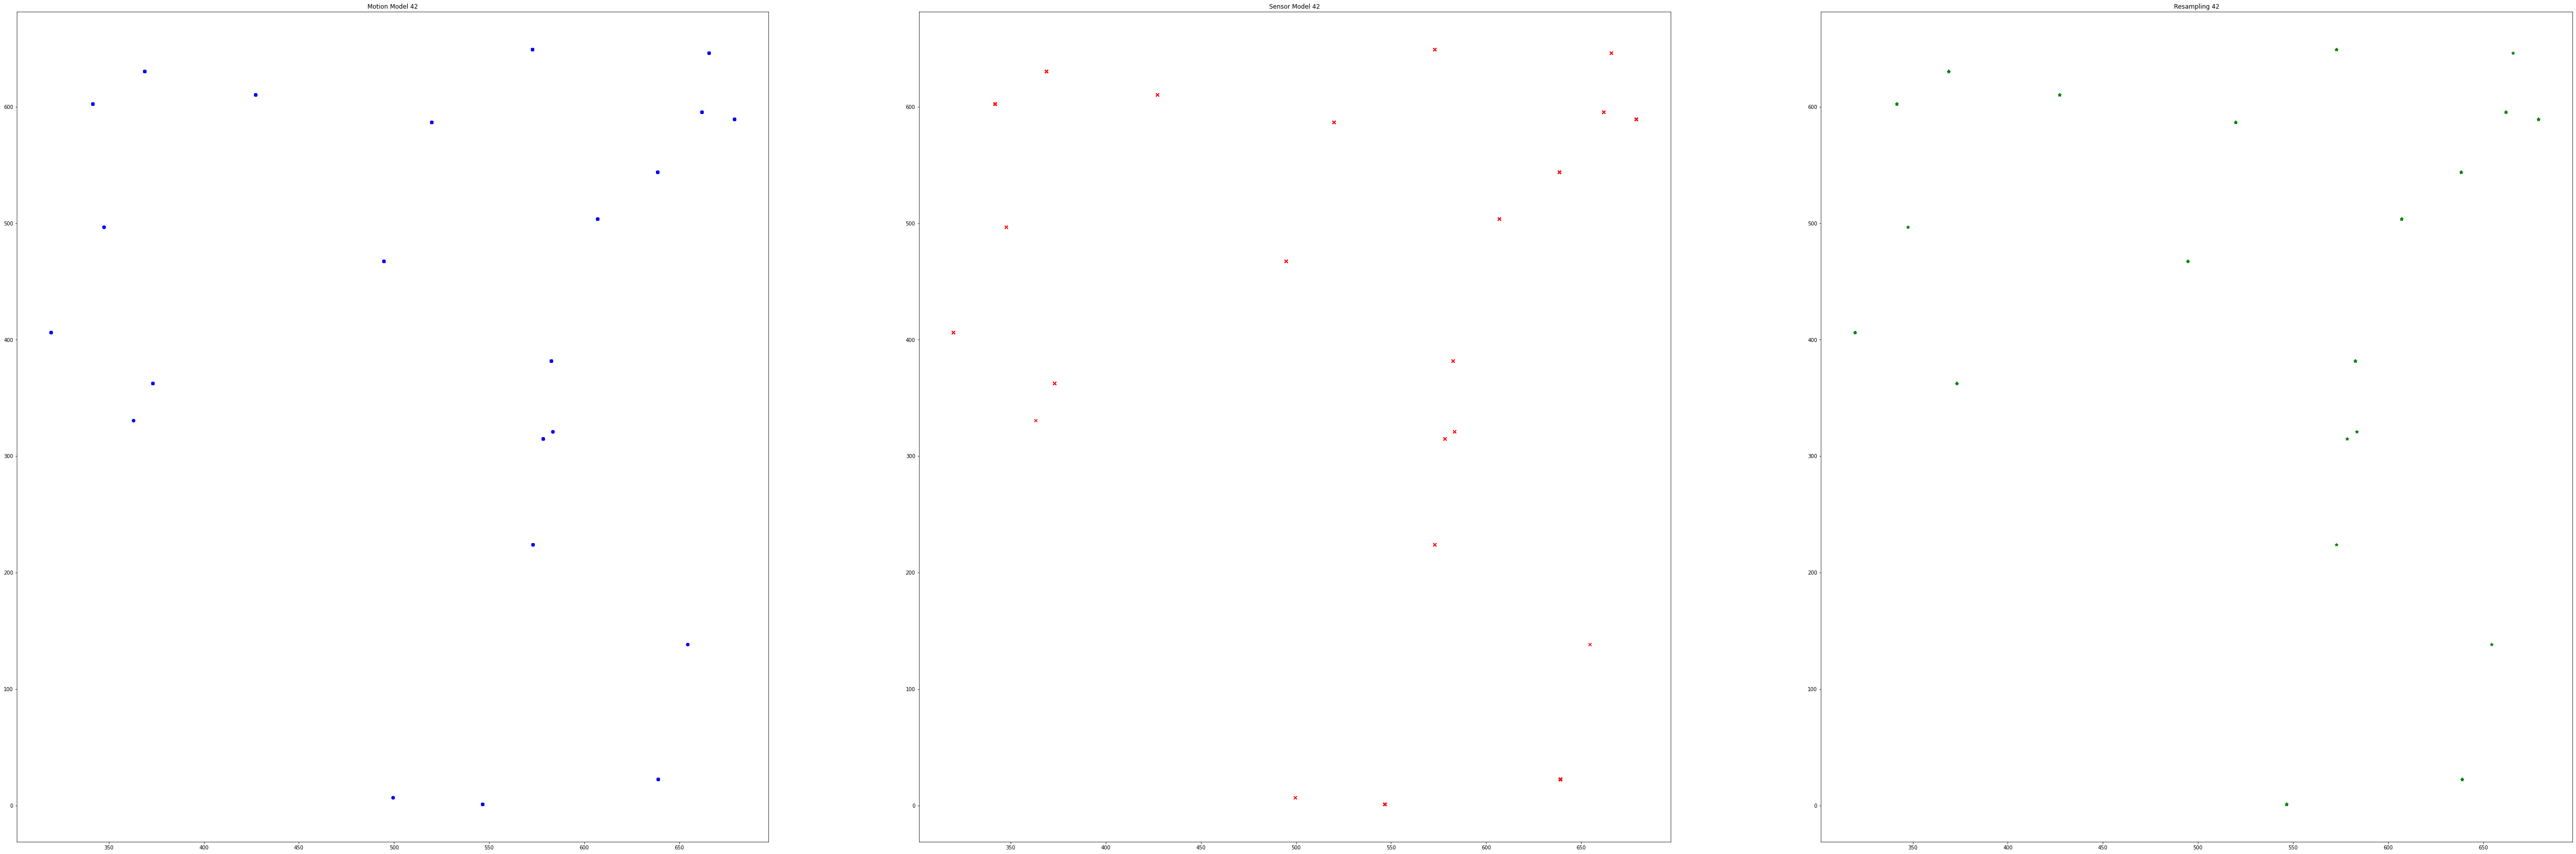

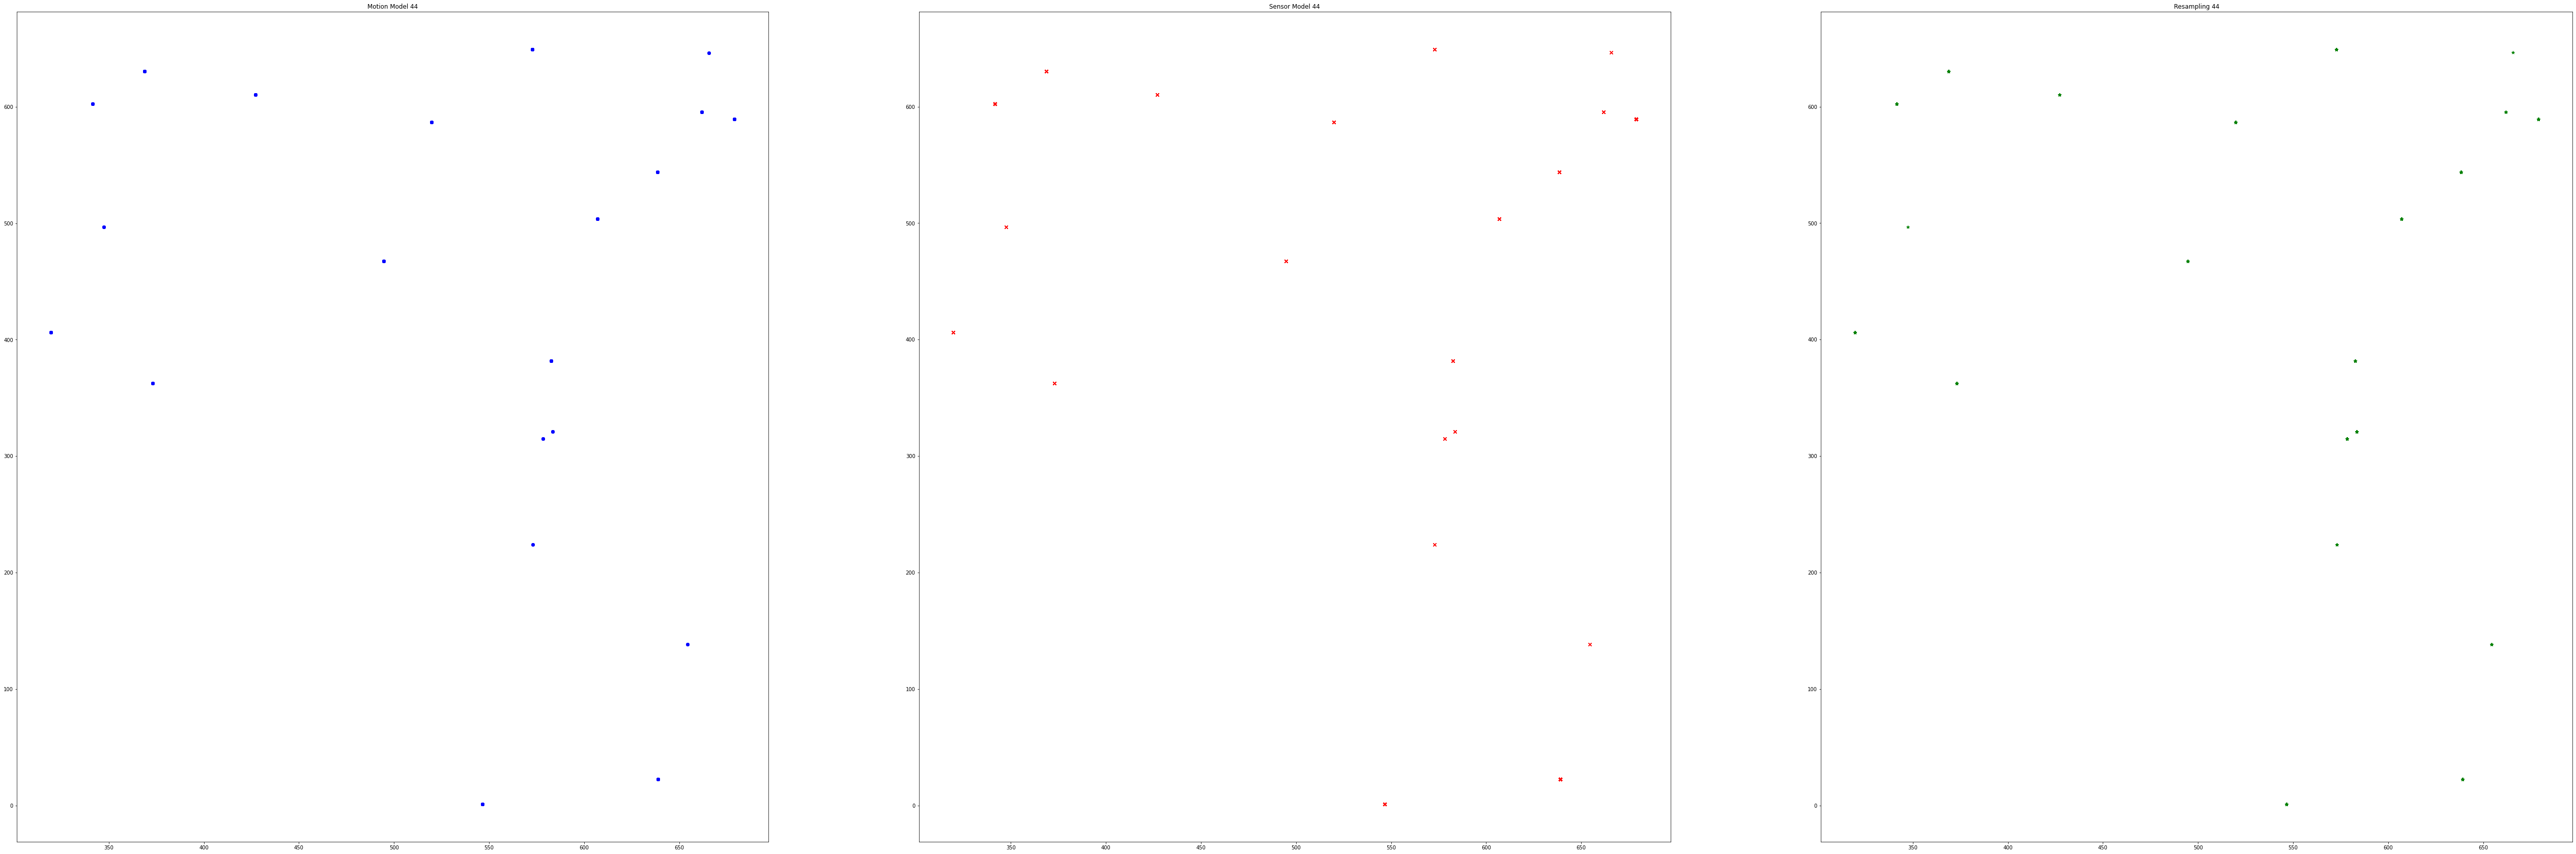

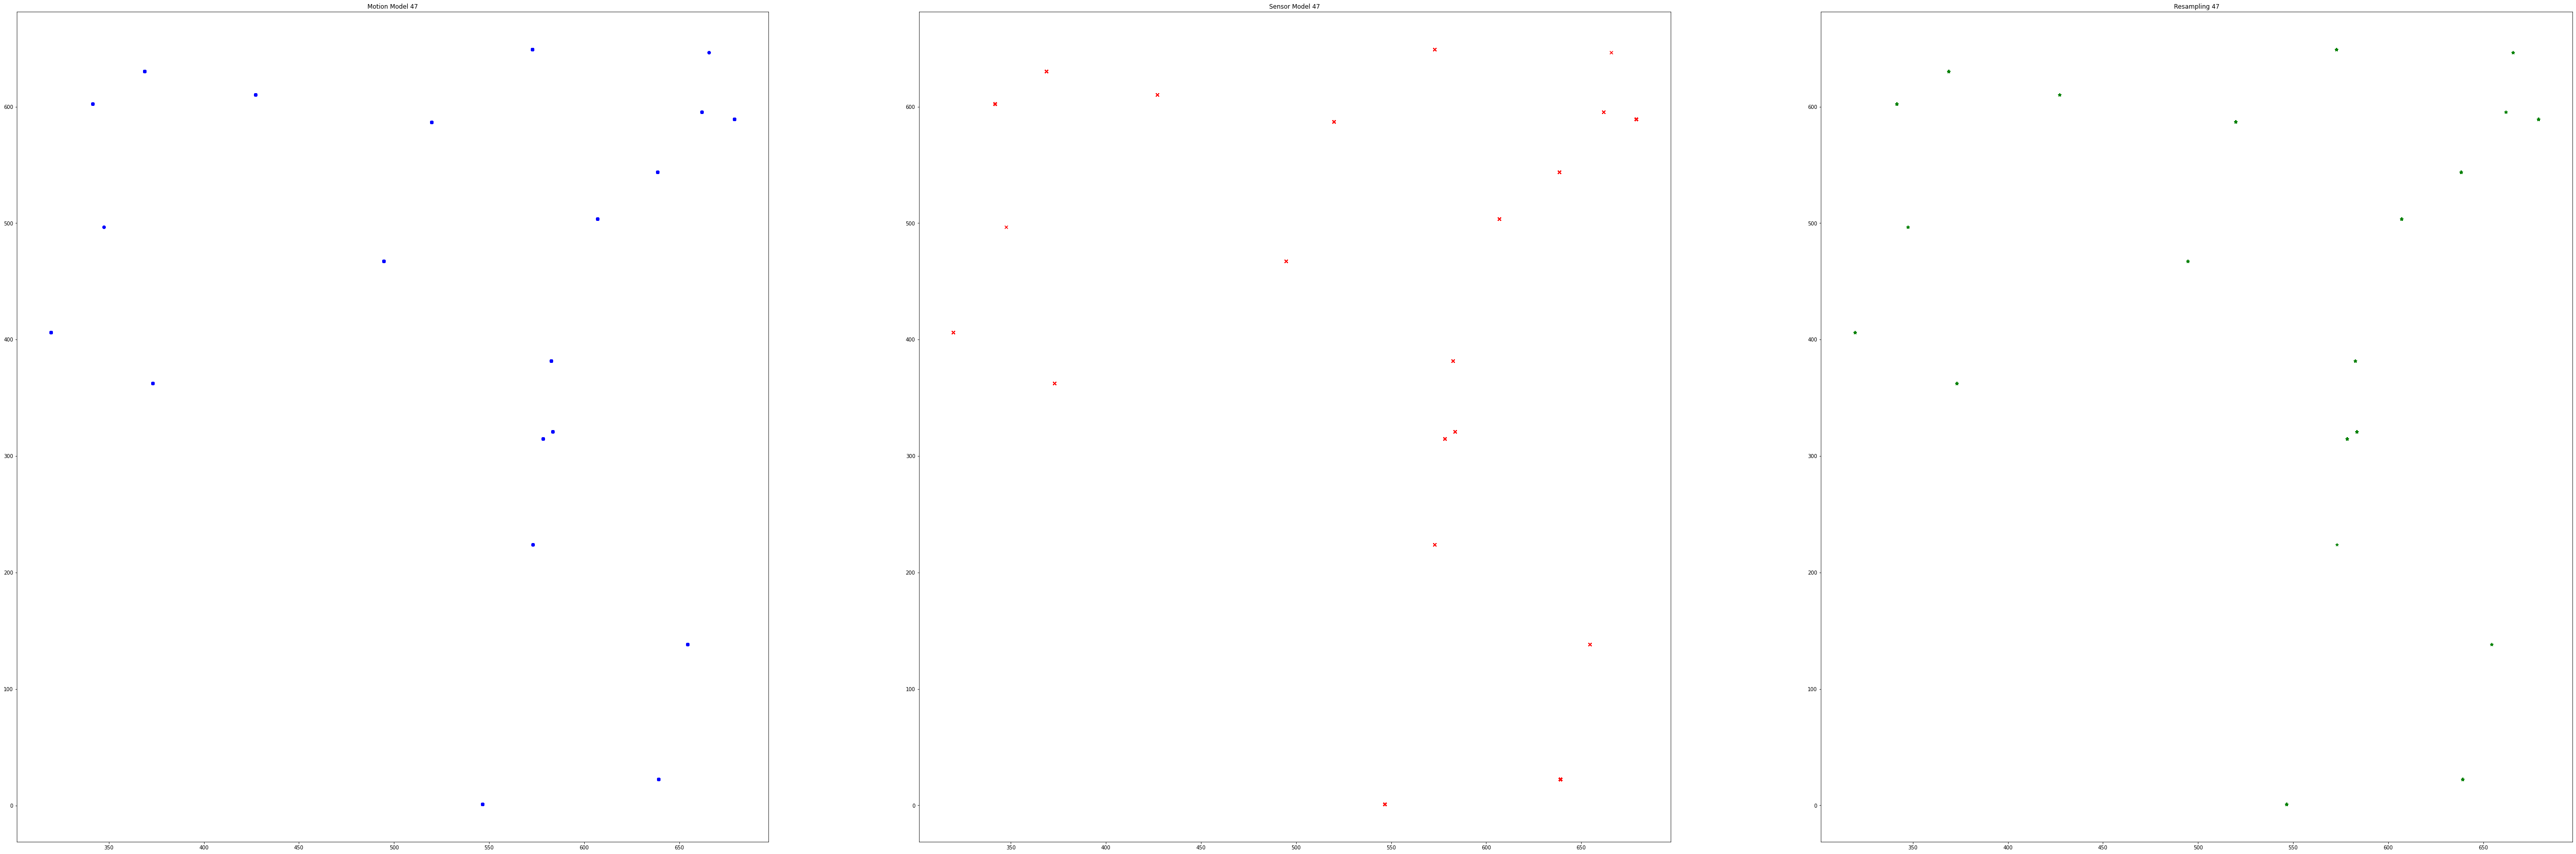

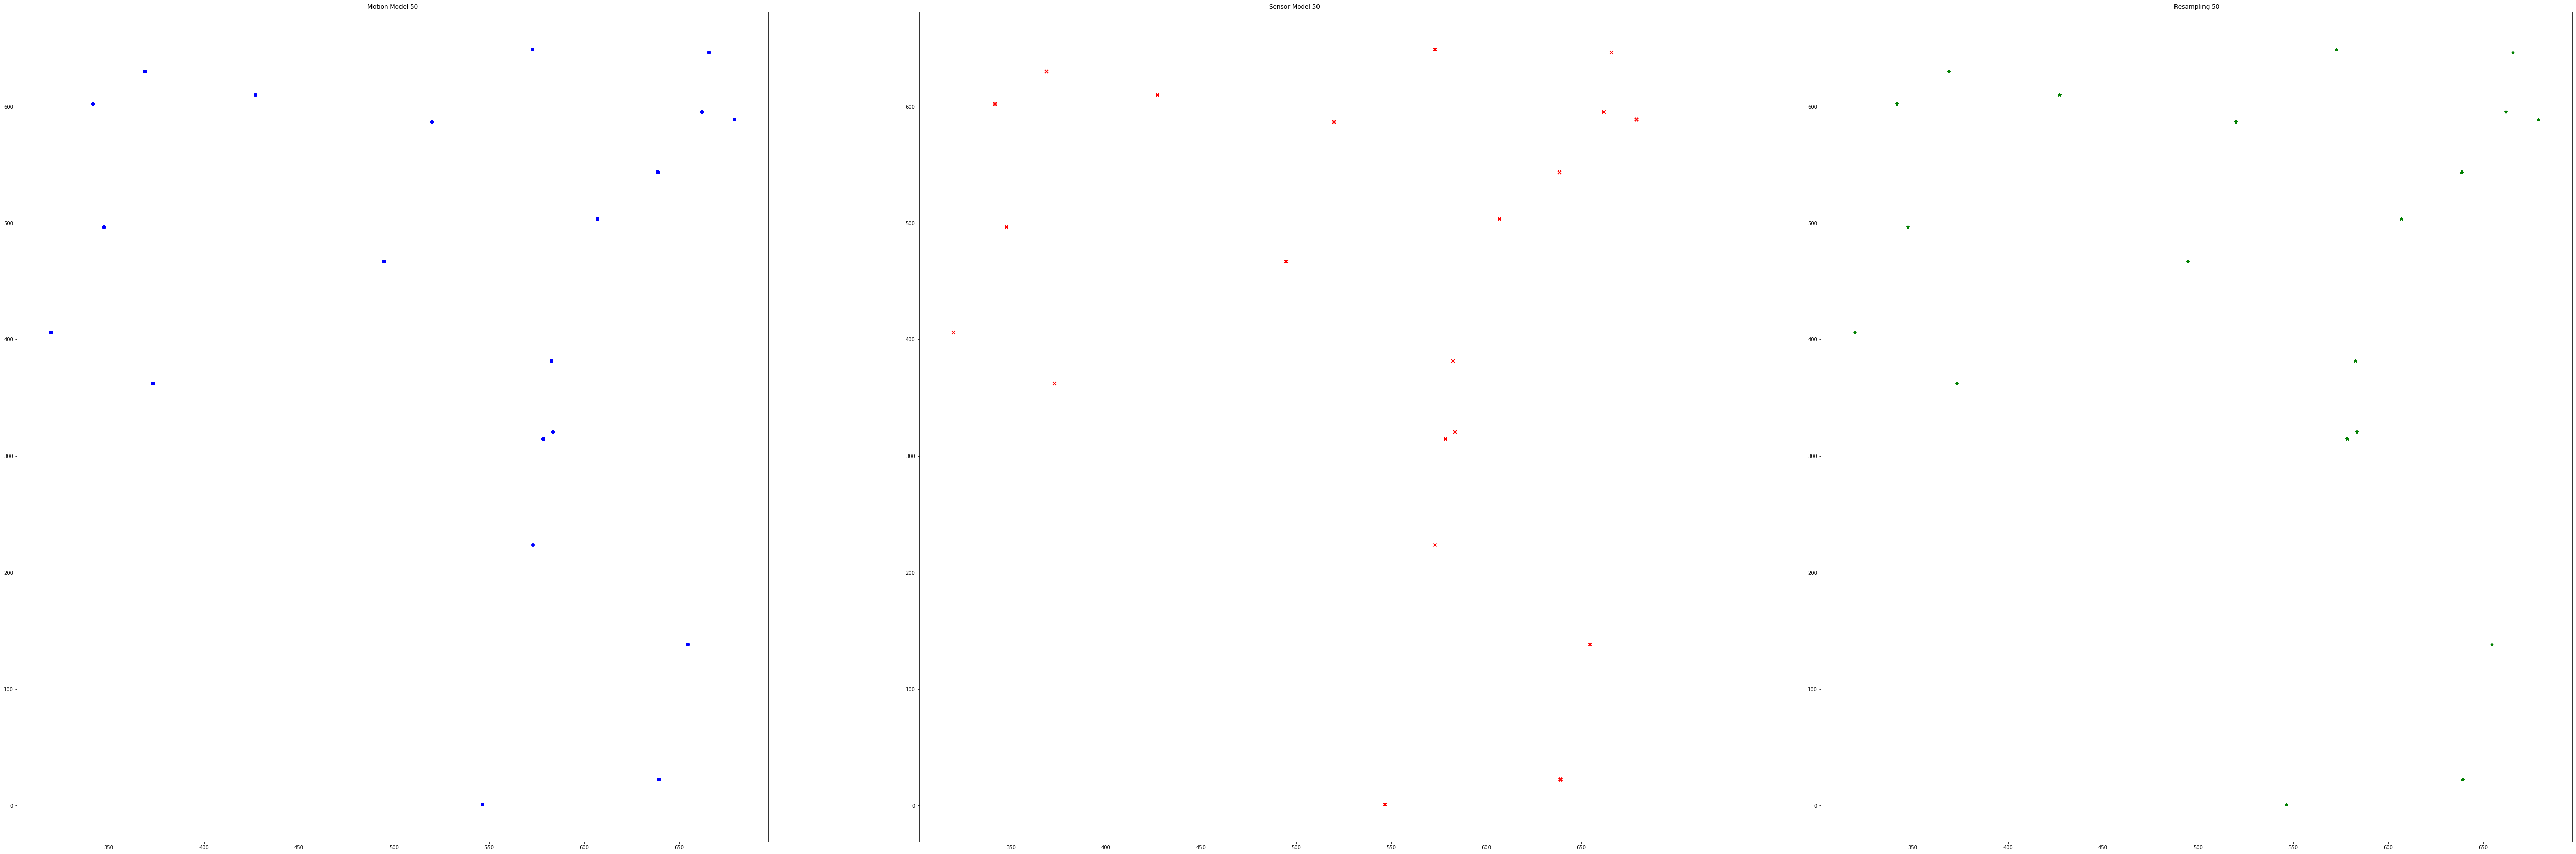

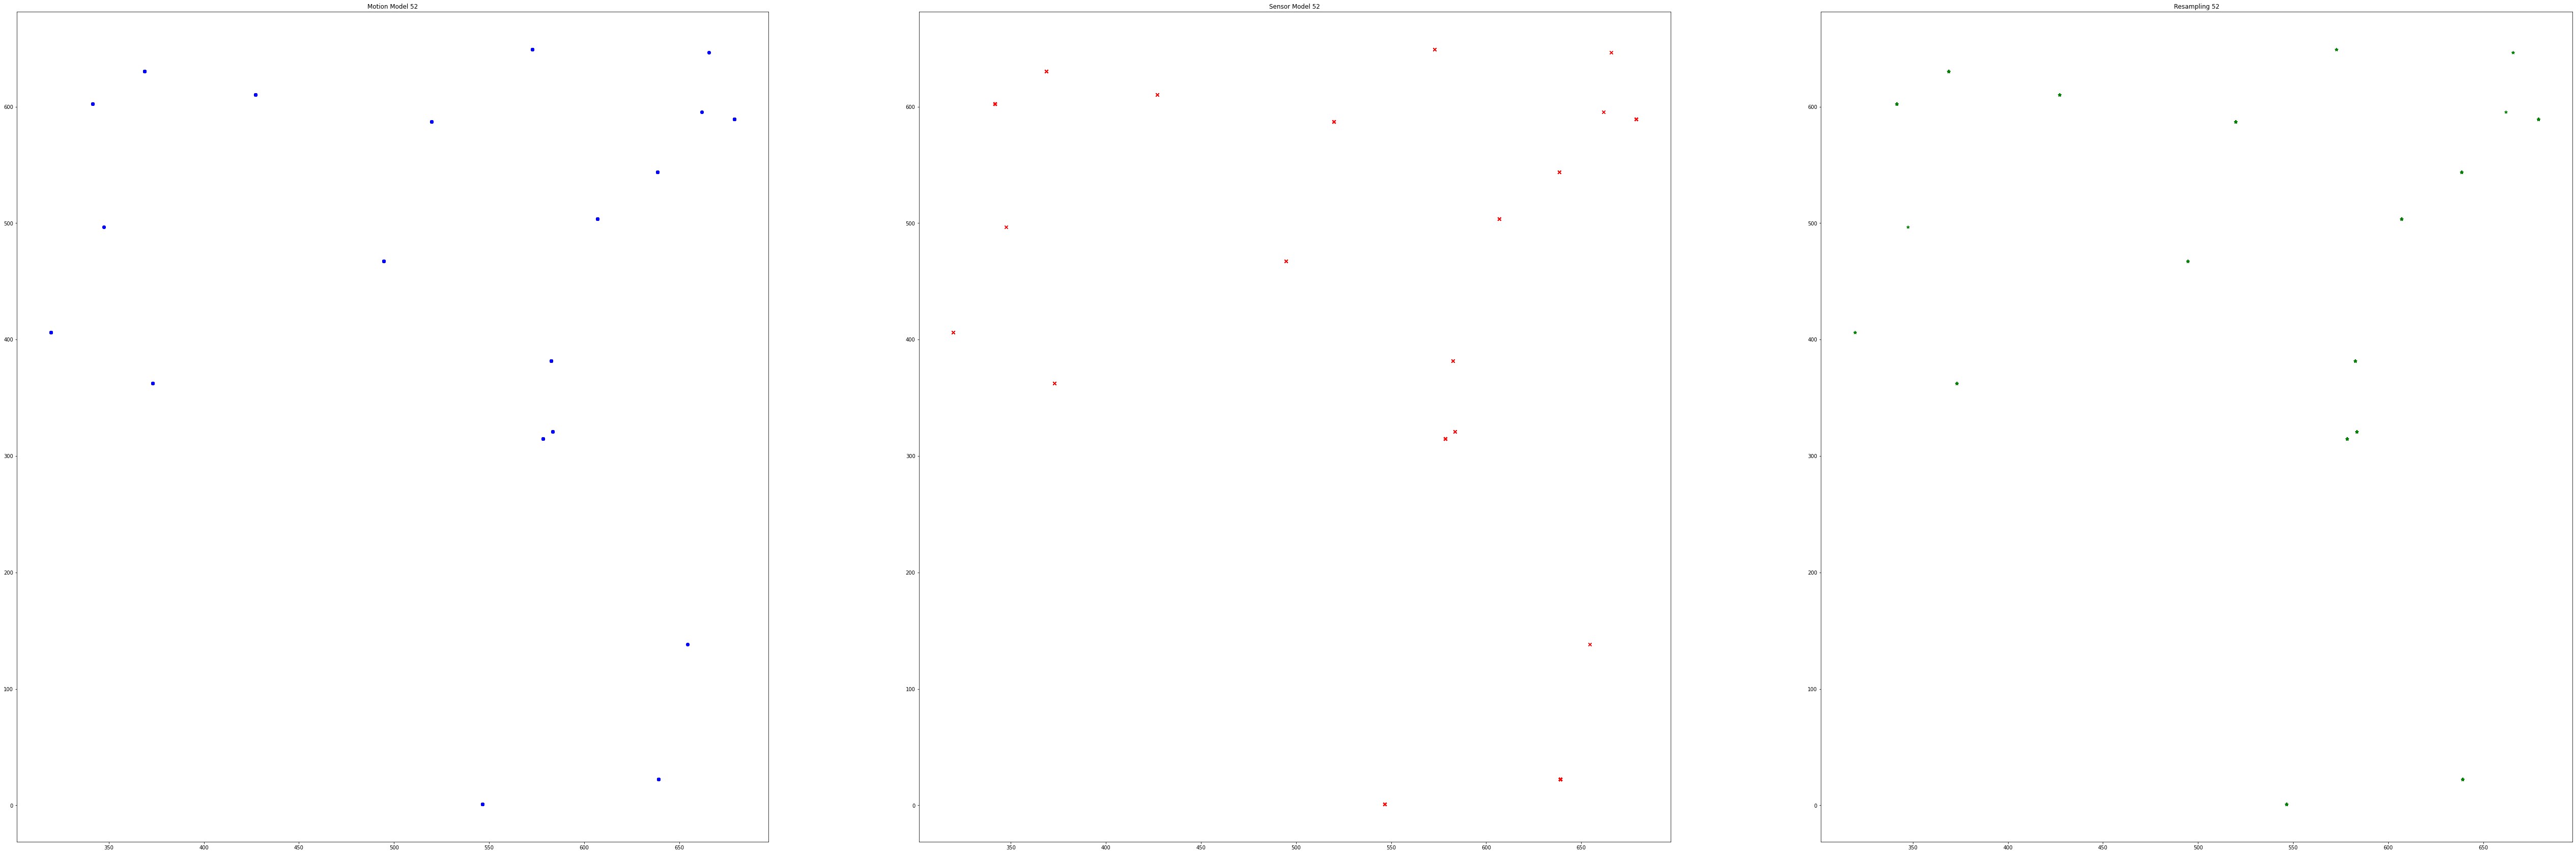

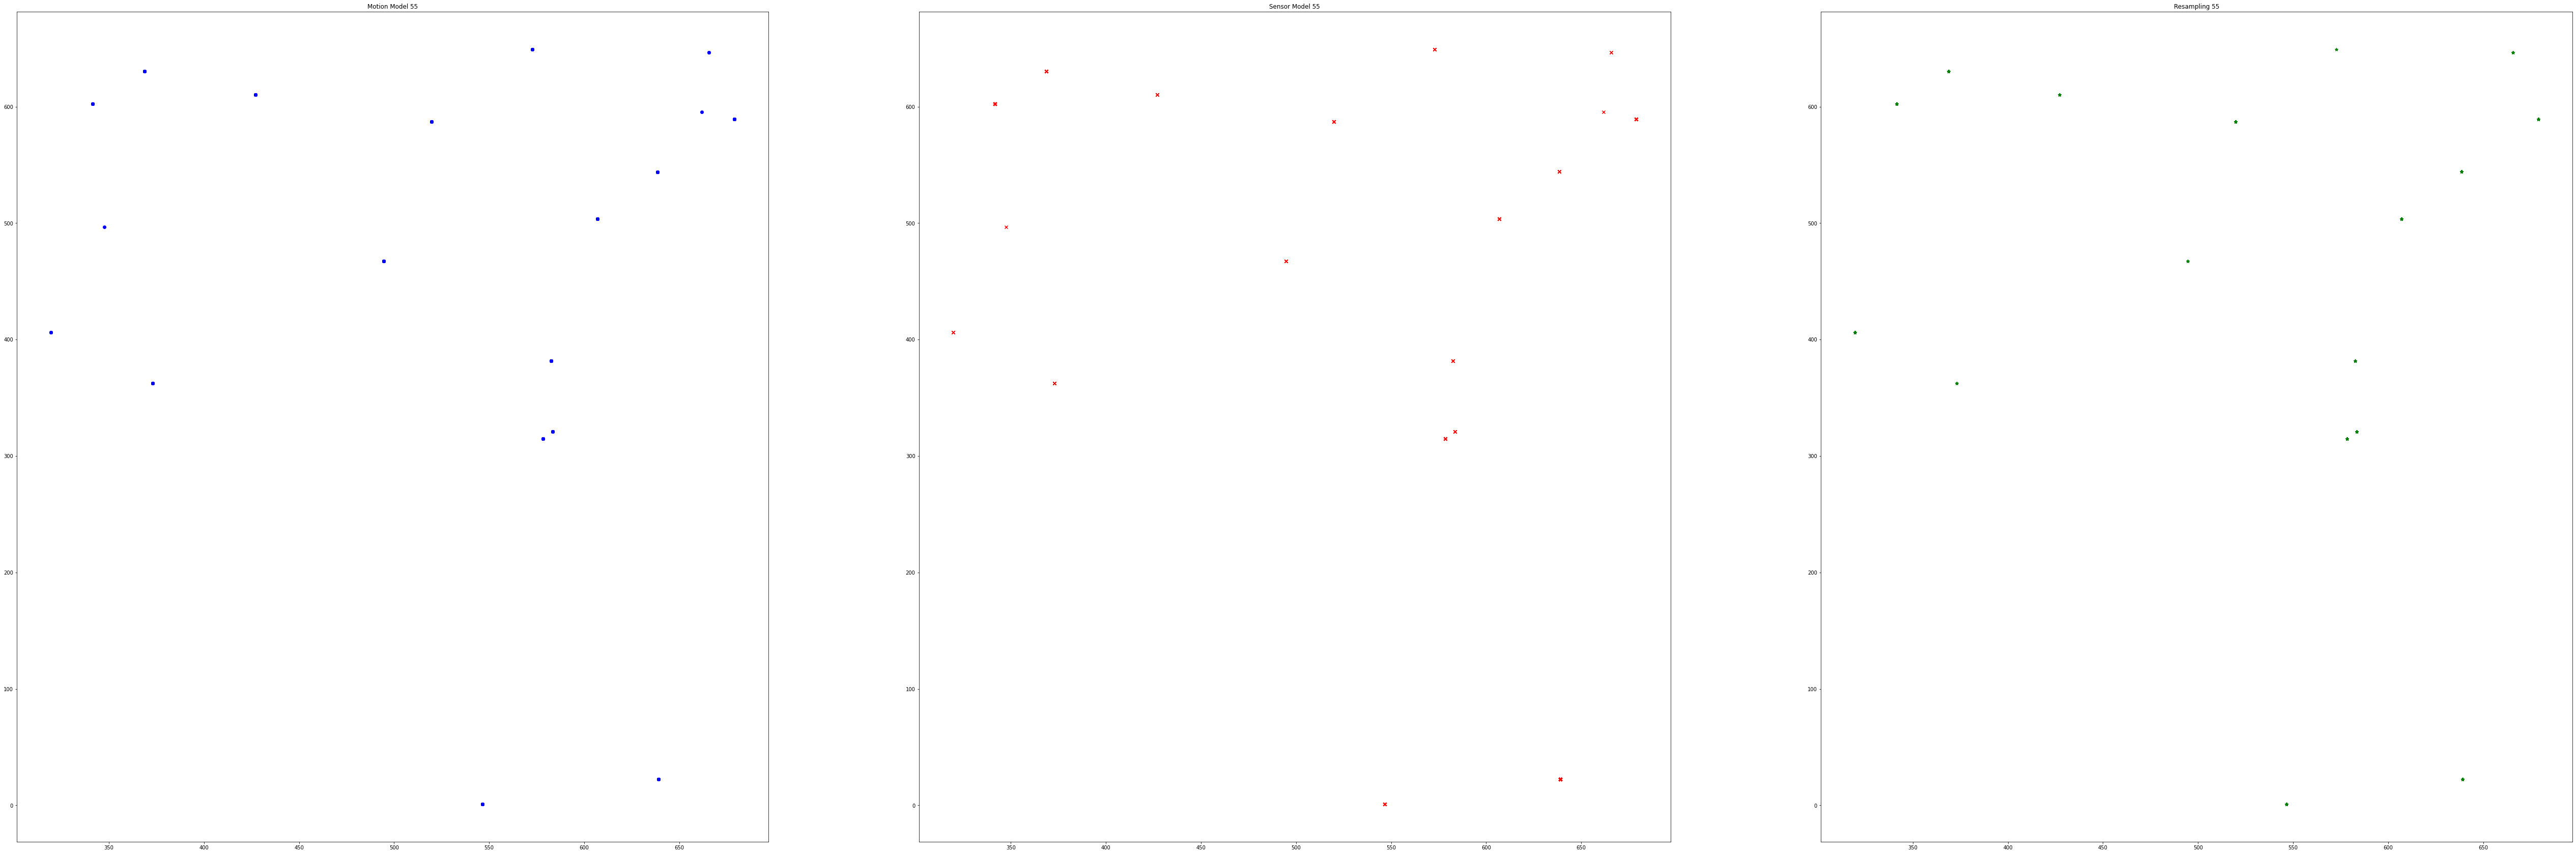

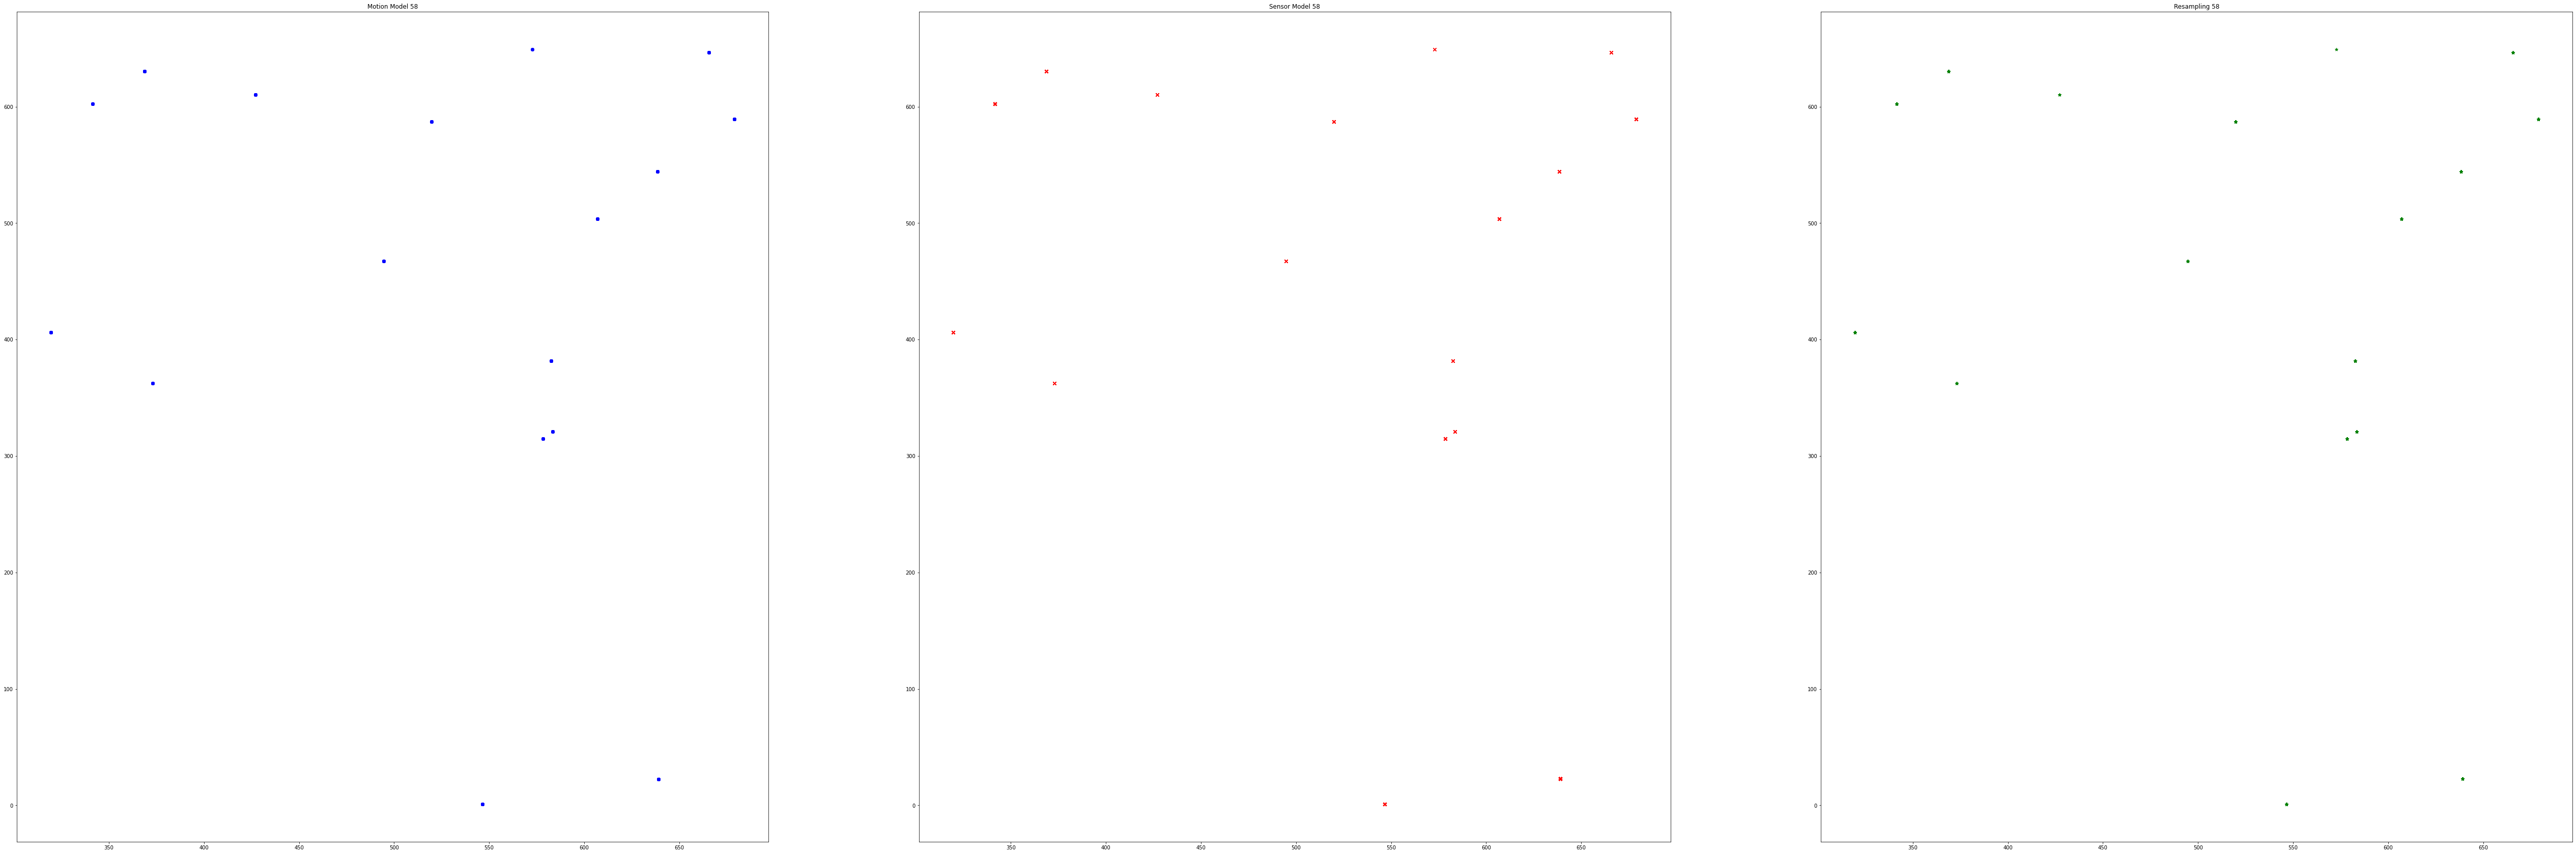

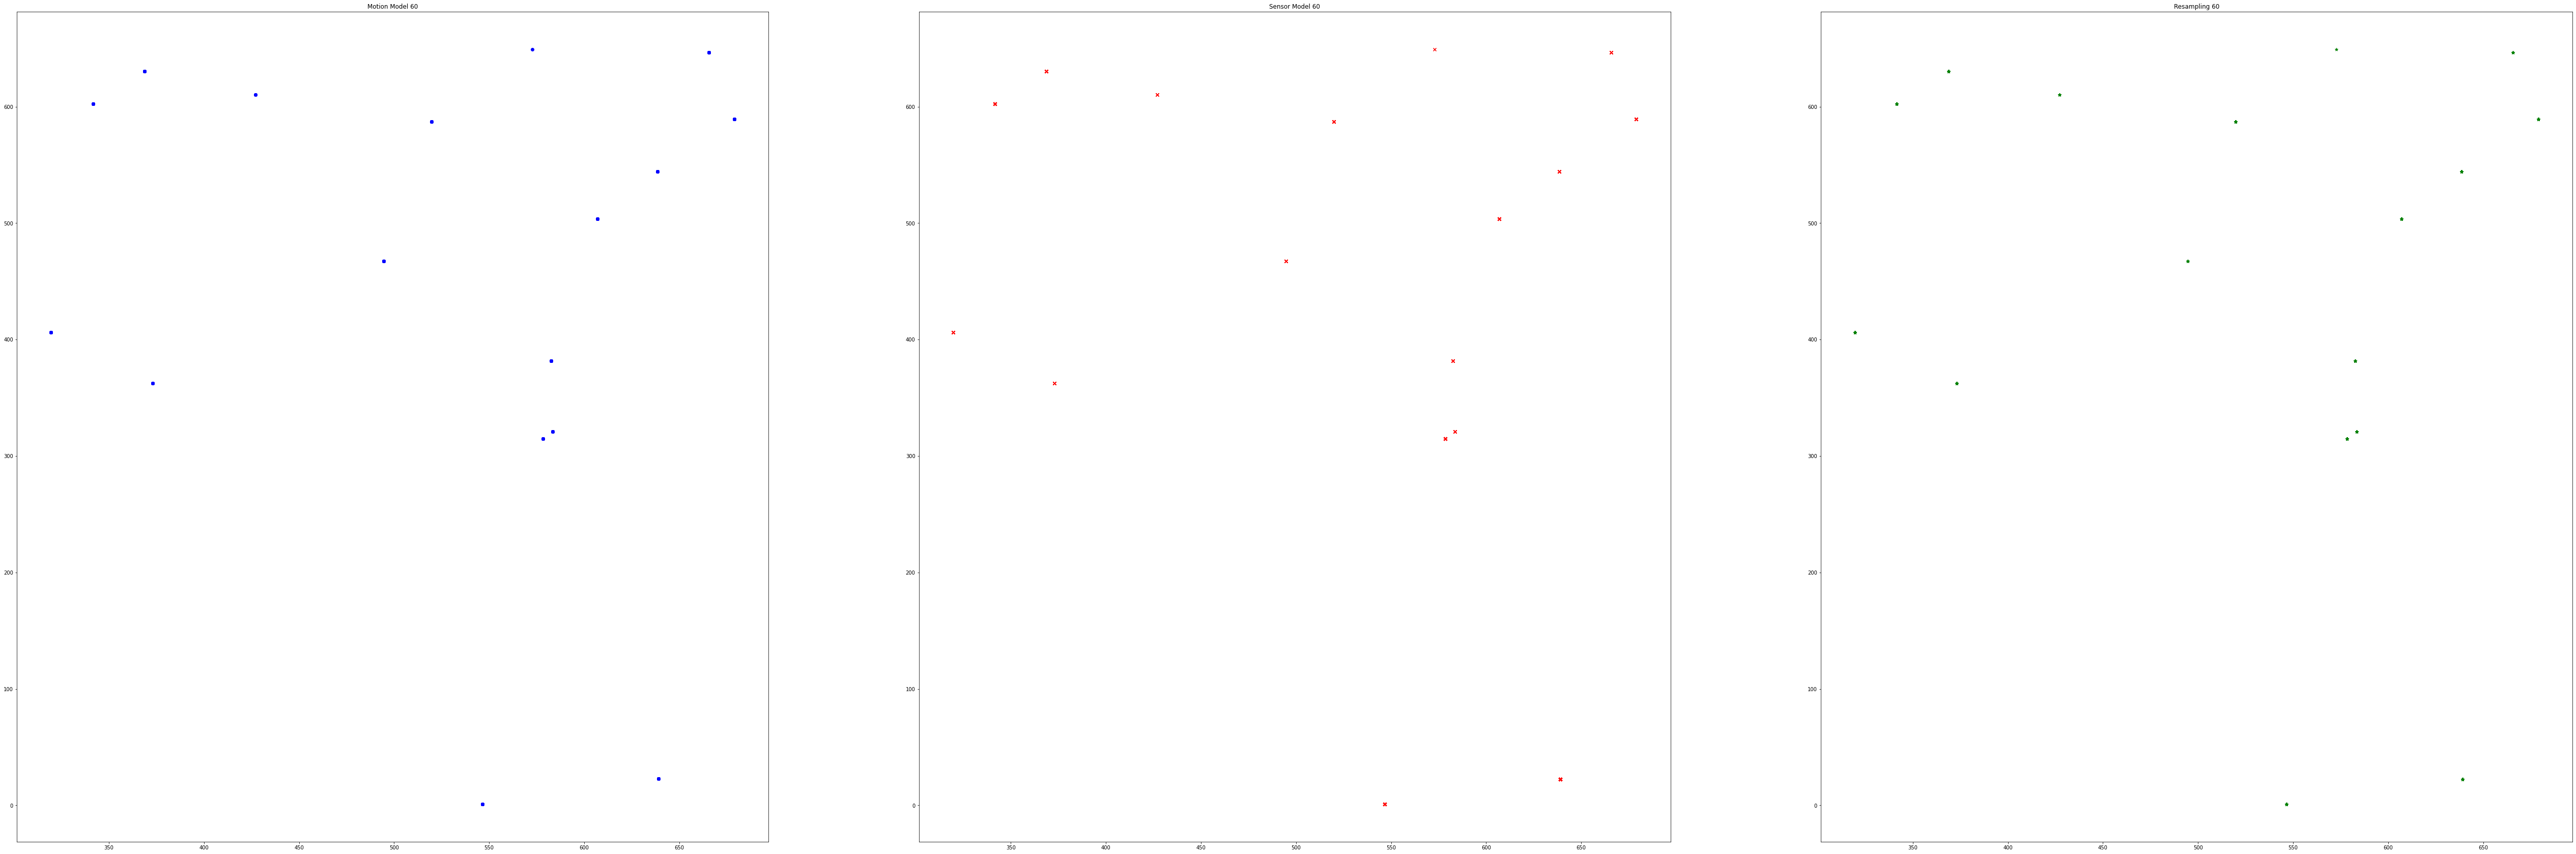

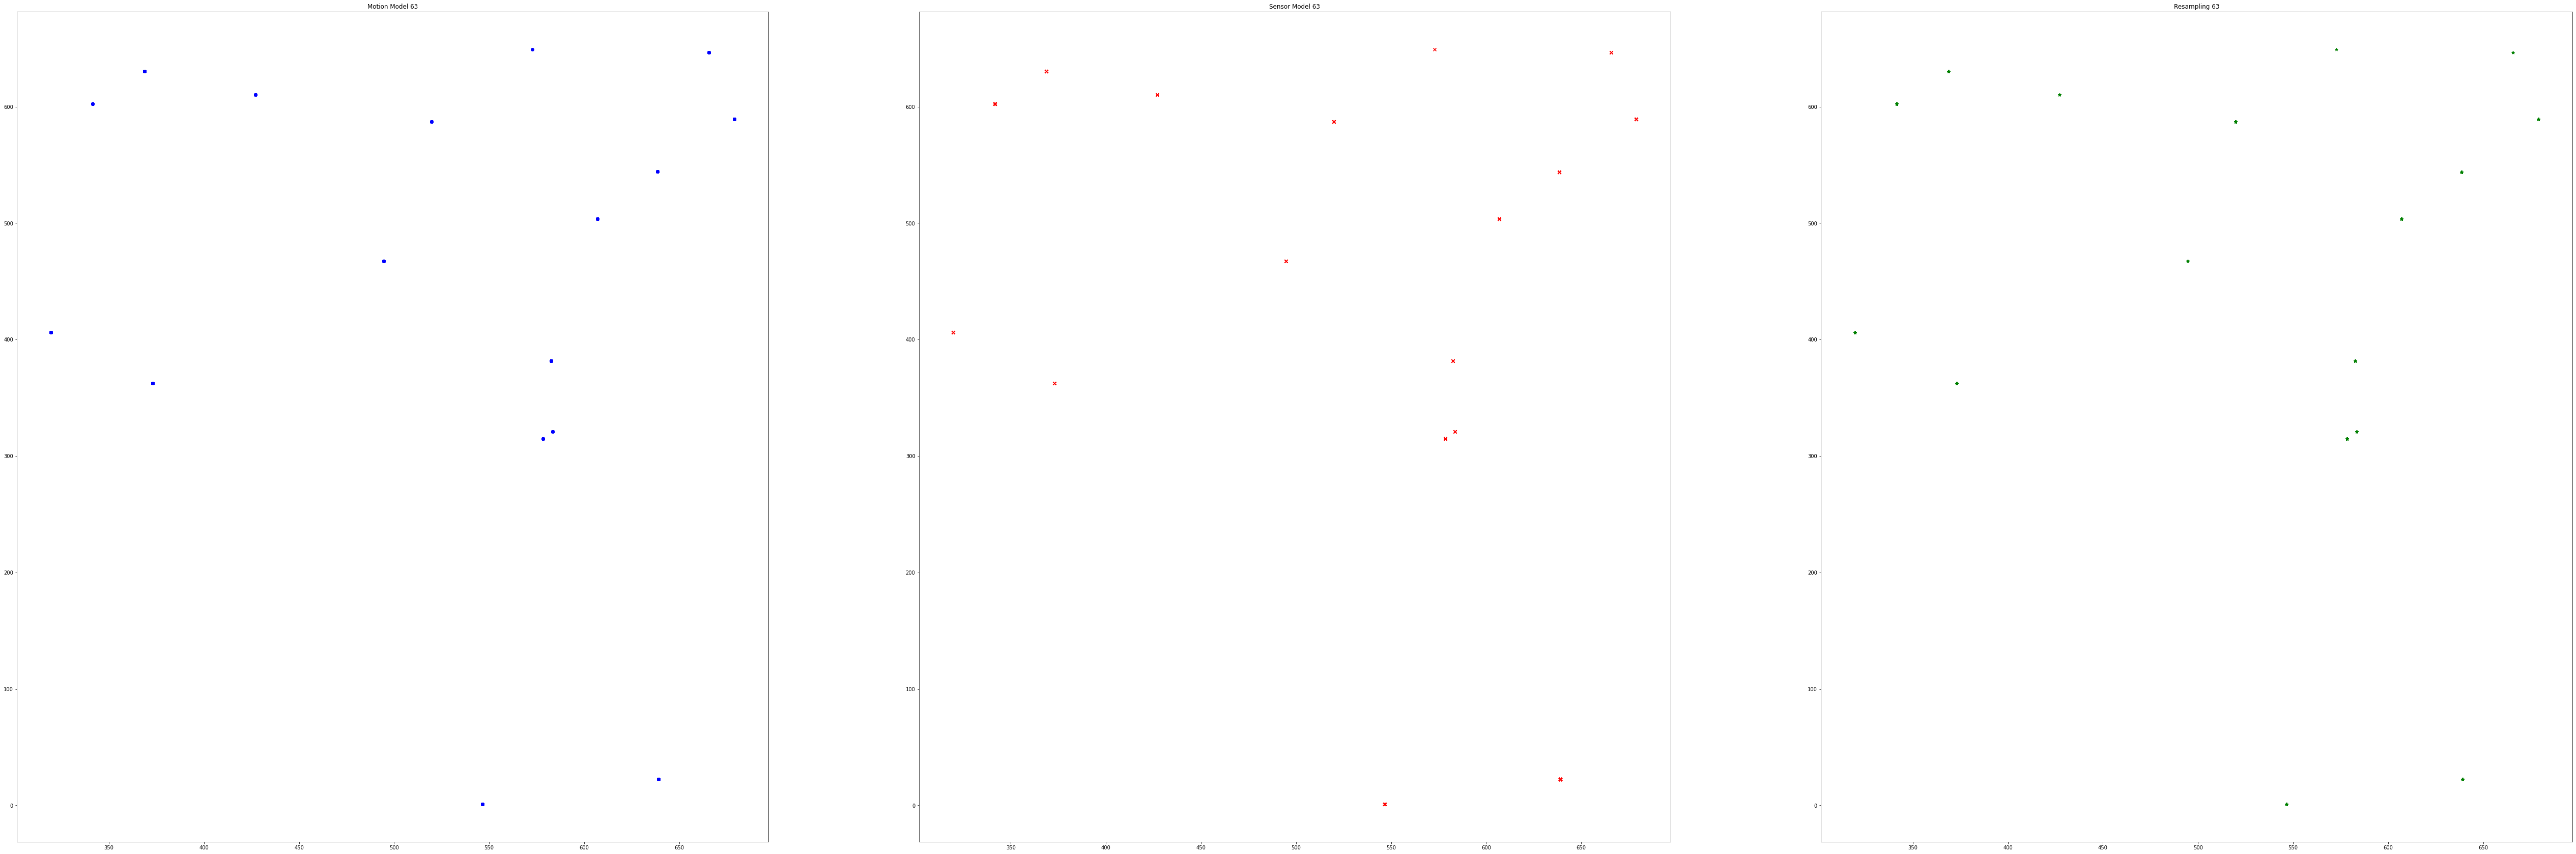

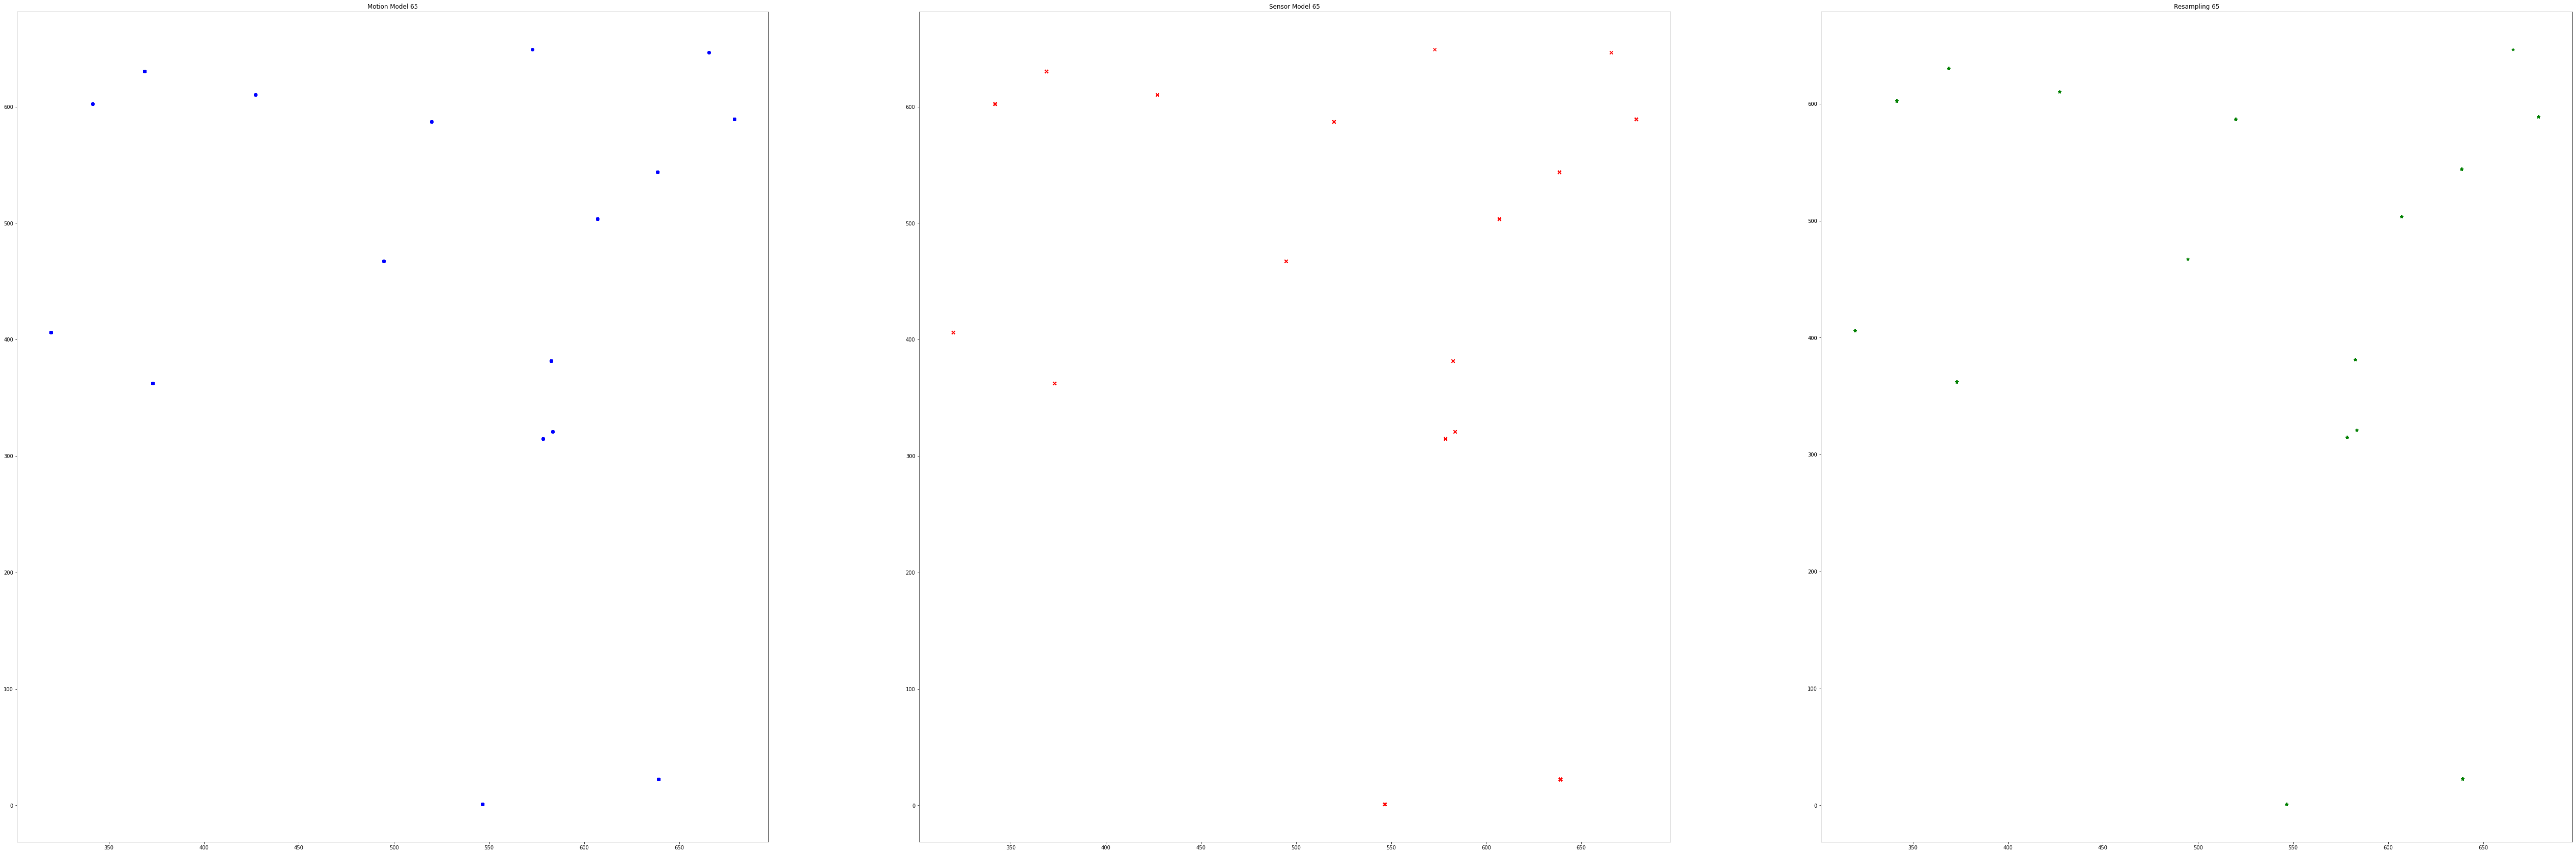

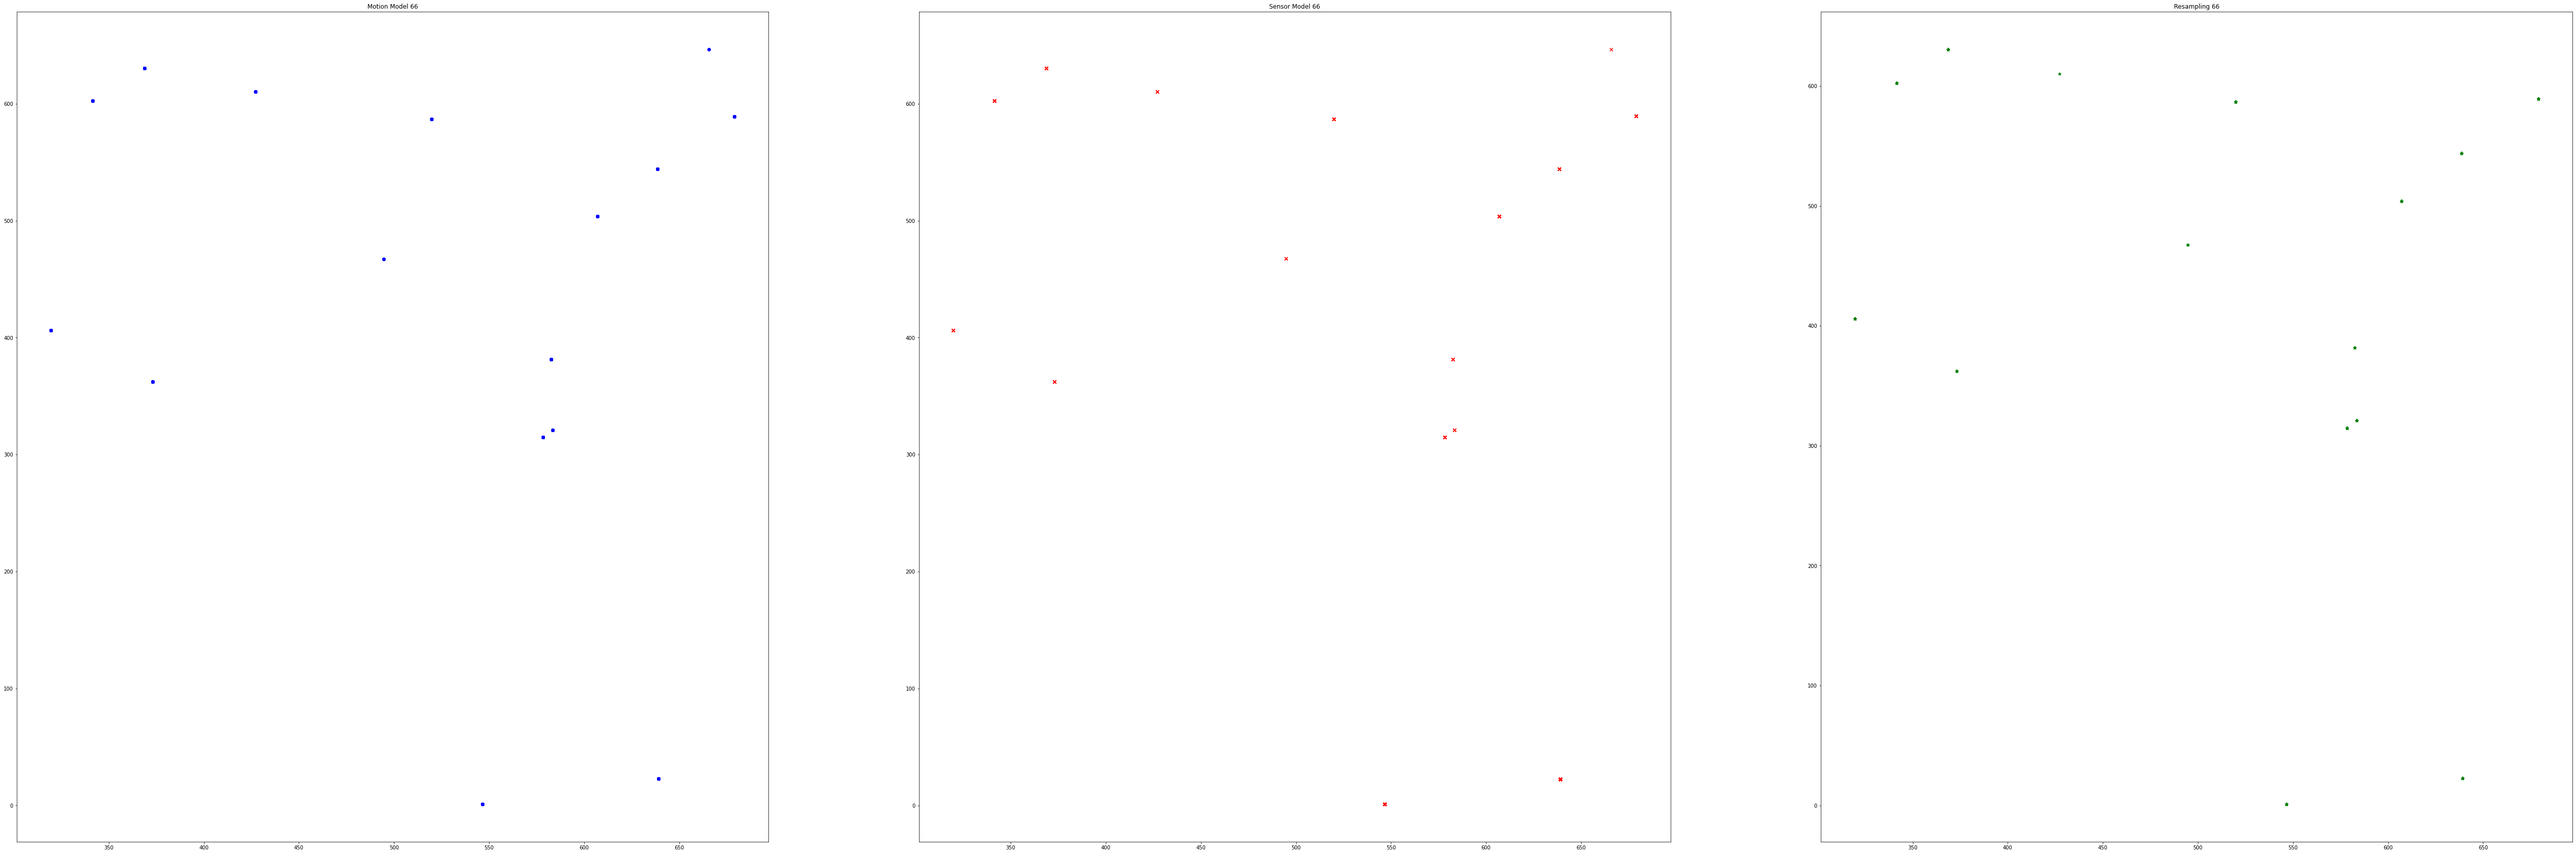

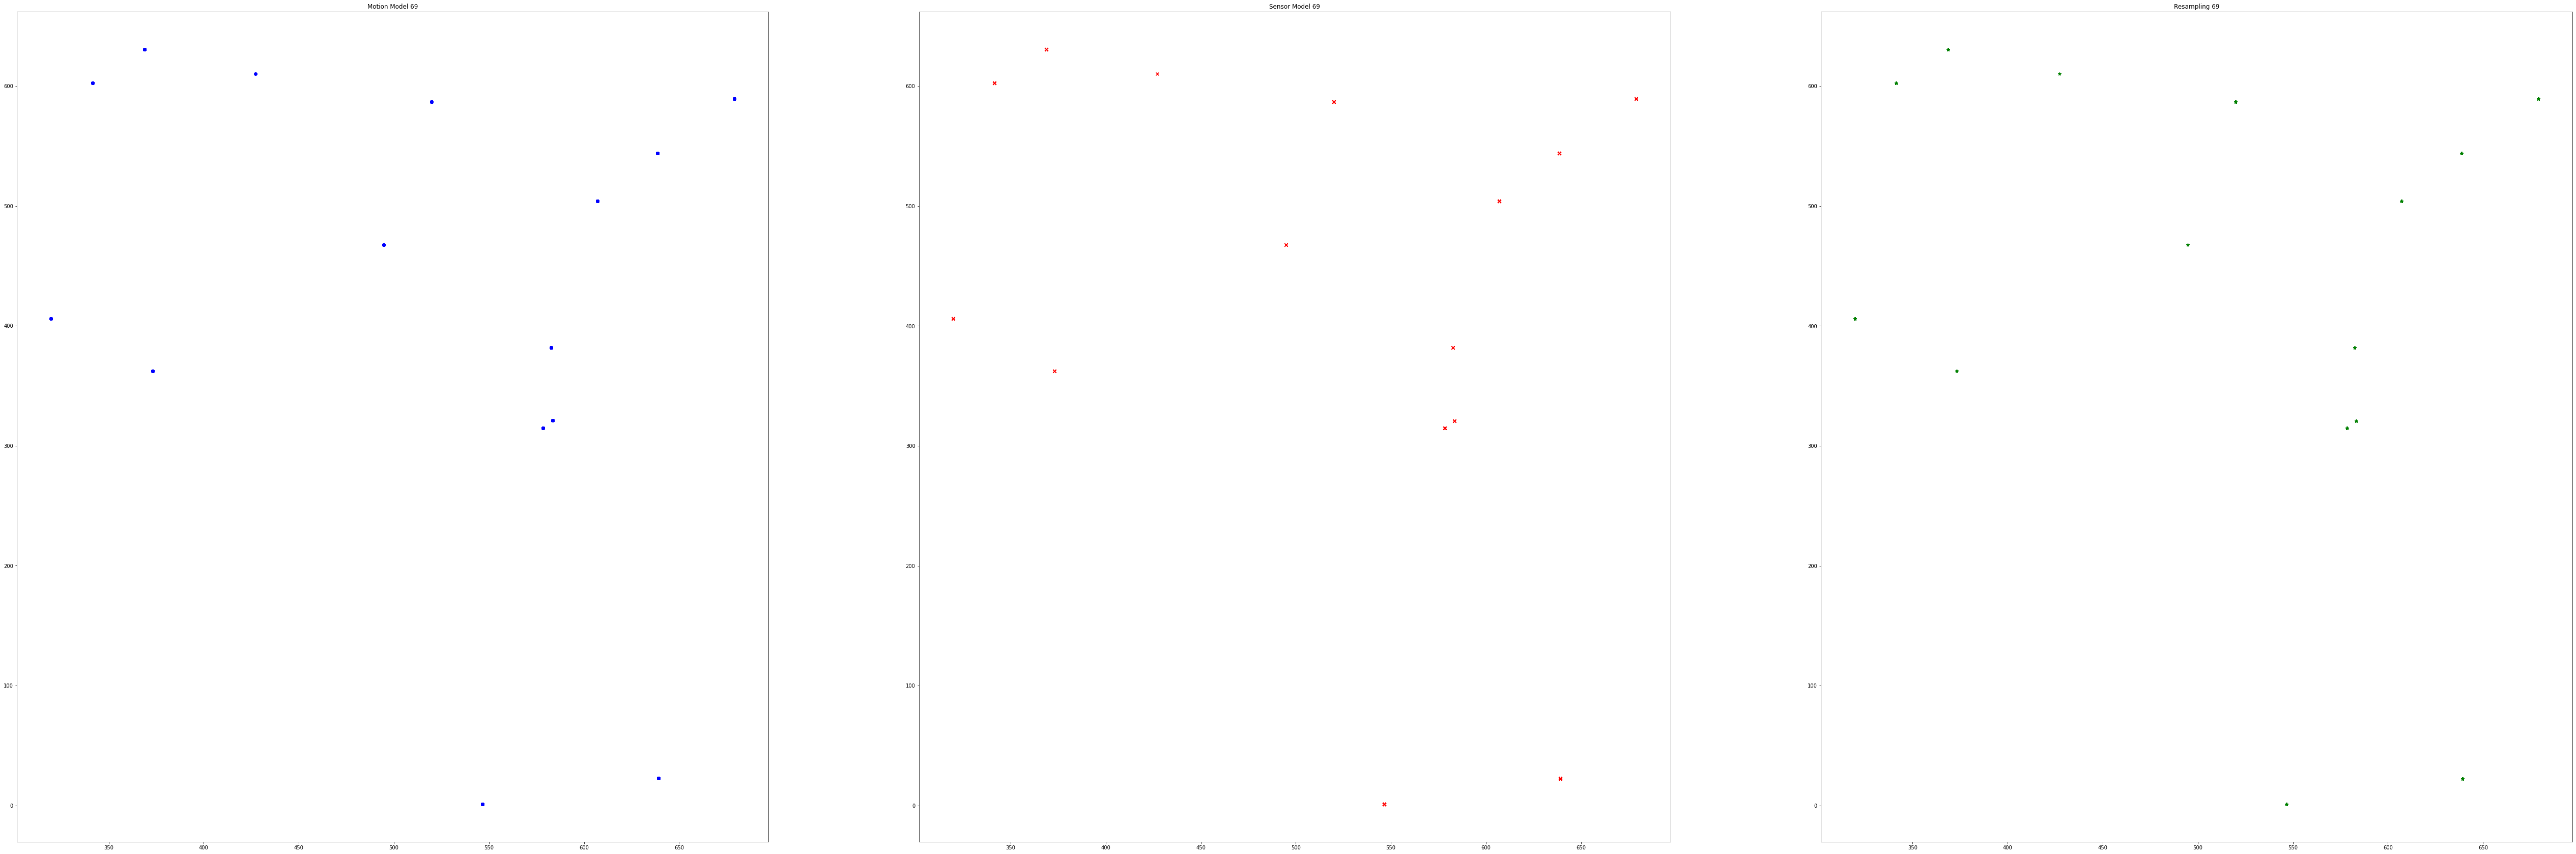

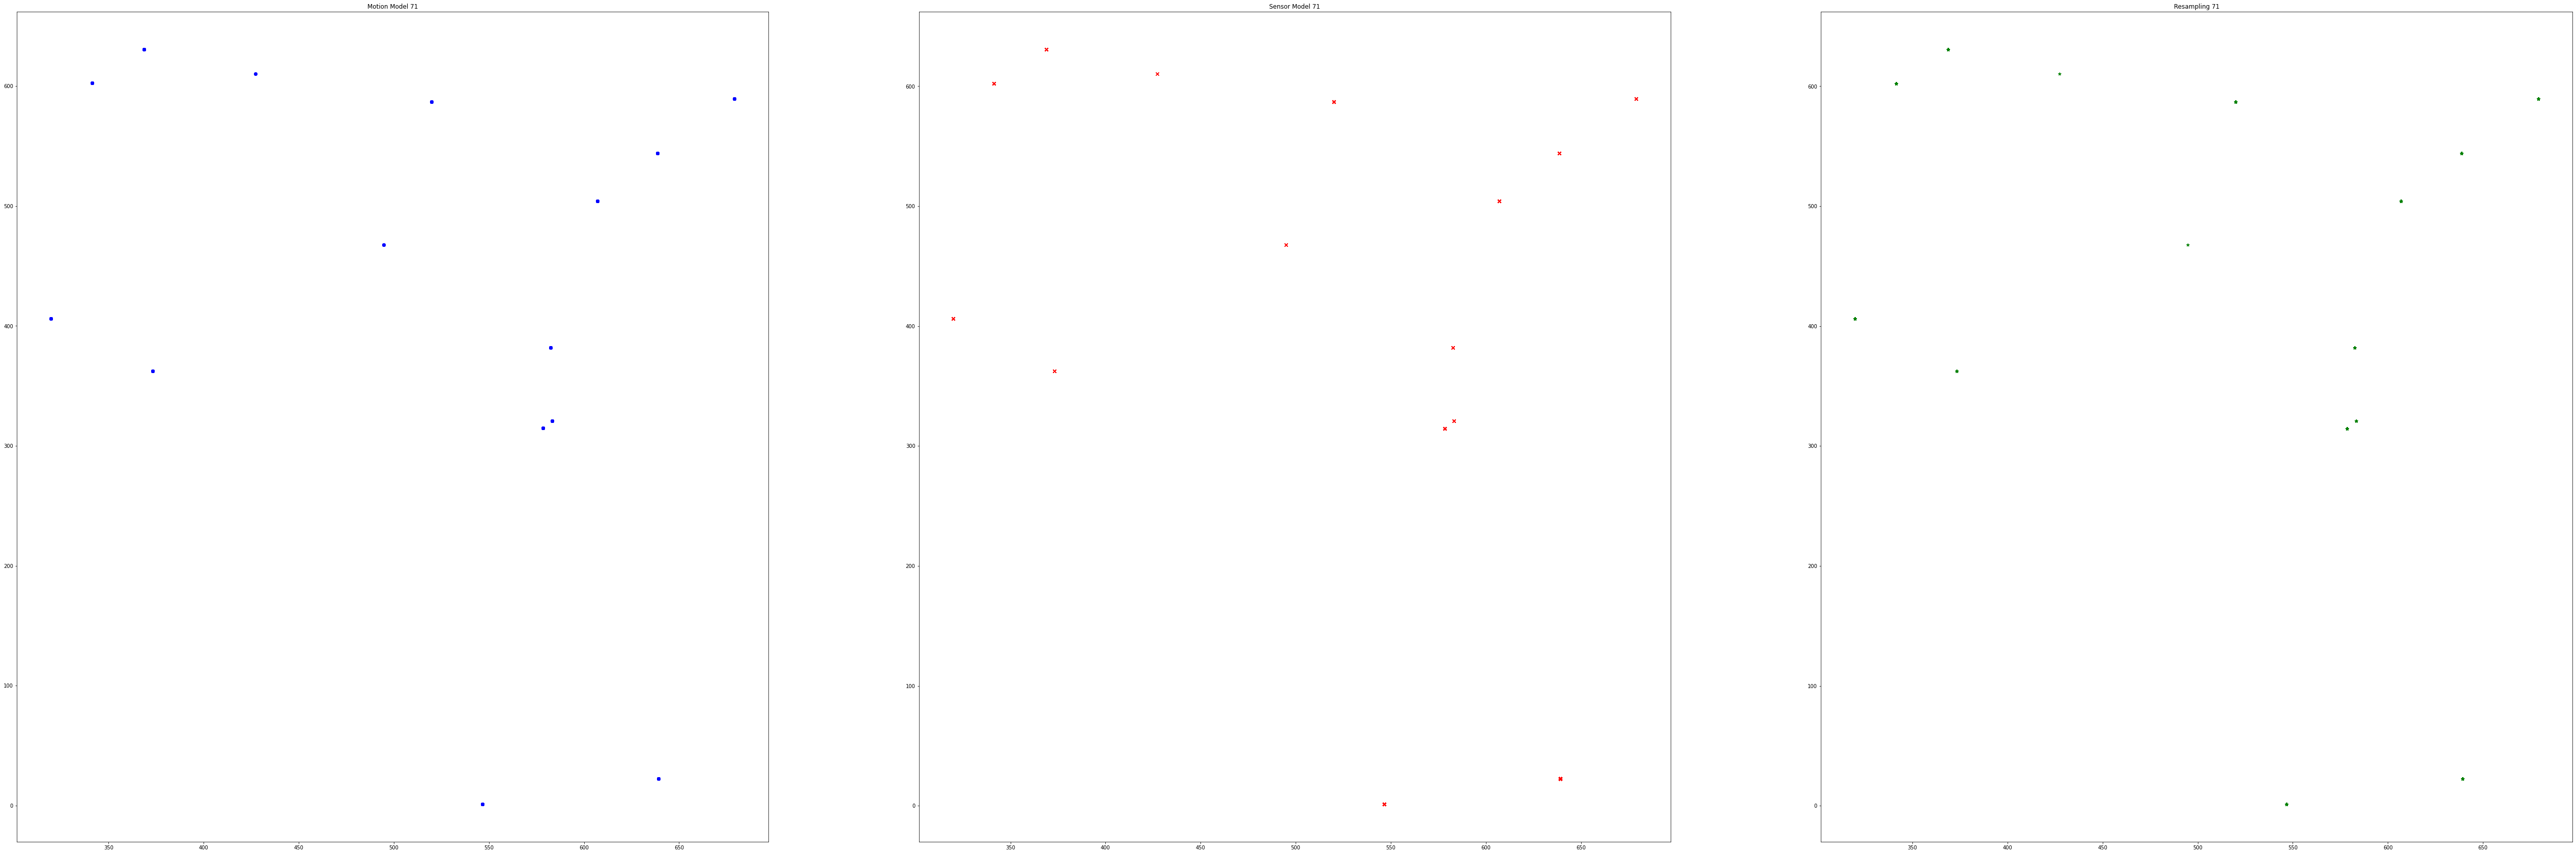

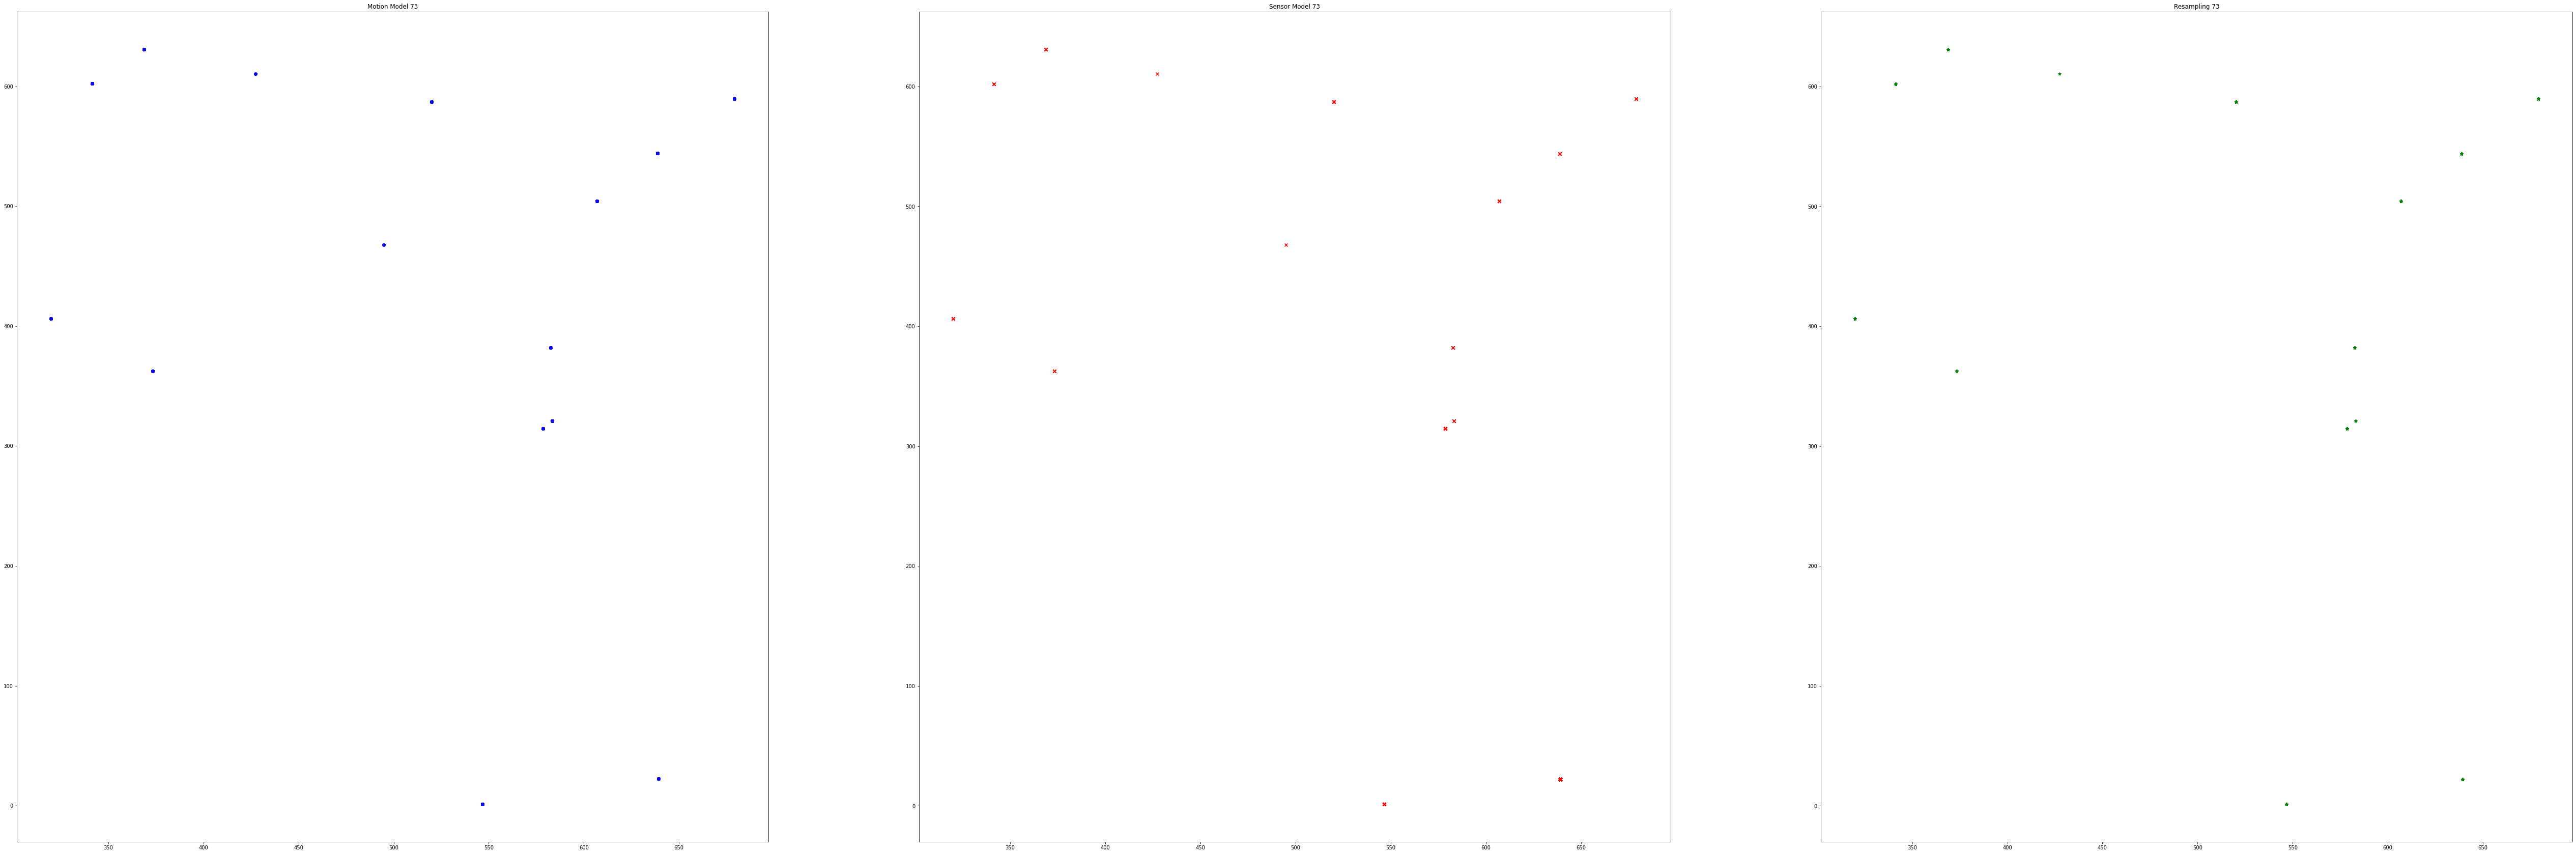

KeyboardInterrupt: 

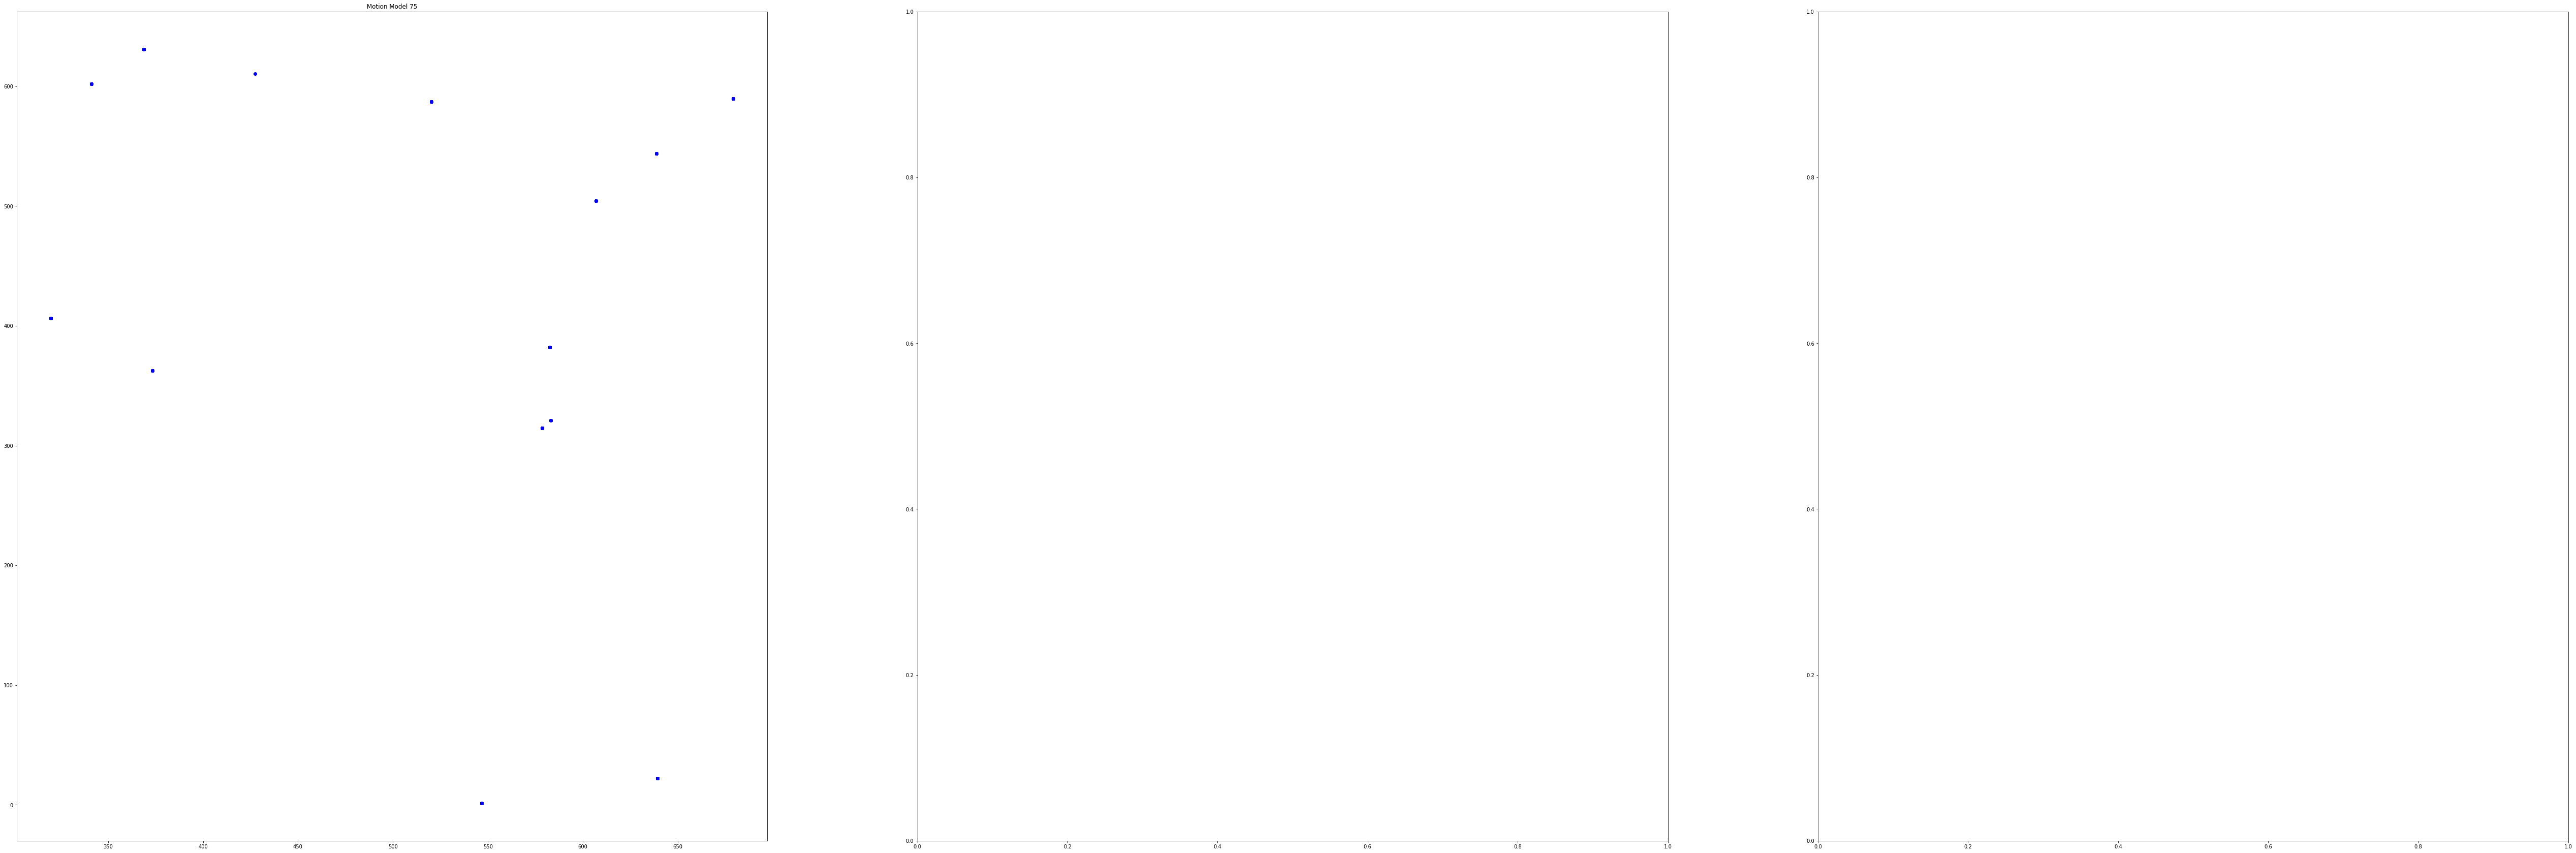

In [10]:
# * Monte Carlo Localization Algorithm : Main Loop
plot = '2d'
num_particles = 1000
X_bar = init_particles_random(num_particles, occupancy_map)

first_time_idx = True
plt.ion()
fig = plt.figure()
# for time_idx, line in enumerate(logfile):
#     meas_type = line[0]
#     meas_vals = np.fromstring(line[2:], dtype=np.float64, sep=" ")

#     # odometry reading [x, y, theta] in odometry frame
#     odometry_robot = meas_vals[0:3]
#     time_stamp = meas_vals[-1]

#     #! ignore pure odometry measurements for (faster debugging)
#     if ((time_stamp <= 0.0) | (meas_type == "O")):
#         continue

#     if meas_type == "L":
#         # [x, y, theta] coordinates of laser in odometry frame
#         odometry_laser = meas_vals[3:6]
#         # 180 range measurement values from single laser scan
#         ranges = meas_vals[6:-1]

#     if time_idx % 100 == 0:
#         print("Processing time step {} at time {}s".format(time_idx, time_stamp))

#     if first_time_idx:
#         u_t0 = odometry_robot
#         first_time_idx = False
#         continue

#     X_bar_new = np.zeros((num_particles, 4), dtype=np.float64)
#     u_t1 = odometry_robot

#     #* Motion Model
#     x_t0 = X_bar[:, 0:3]
#     x_t1 = motion_model.update(u_t0, u_t1, x_t0)
#     if plot == '3d':
#         fig = plt.figure(figsize=plt.figaspect(0.33))
#         ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#         ax1.set_title(f"Motion {time_idx}")
#         ax1.scatter(x_t0[:, 0] / 10.0, 
#                     x_t0[:, 1] / 10.0, 
#                     x_t0[:, 2] / 10.0, 
#                     c=x_t0[:, 2] / 10.0, cmap='viridis', linewidth=0.5 )
#     elif plot == '2d':
#         fig, axs = plt.subplots(1, 3, figsize=(90, 30))
#         axs[0].set_title(f"Motion Model {time_idx}")
#         axs[0].scatter(x_t0[:, 0] / 10.0, x_t0[:, 1] / 10.0, c="b", marker="o" )


    
#     #* Sensor Model
#     if meas_type == "L":
#         z_t = ranges
#         w_t = sensor_model.beam_range_finder_model(z_t, x_t1, time_idx)  # M x 1
#         X_bar_new = np.hstack((x_t1, w_t))  # M x 4
#     # else:
#     #     X_bar_new = np.hstack((x_t1, X_bar[:, 3]))
#     if plot == '3d':
#         ax2 = fig.add_subplot(1, 3, 2, projection='3d')
#         ax2.set_title(f"Sensor {time_idx}")
#         ax2.scatter(X_bar_new[:, 0] / 10.0, 
#                     X_bar_new[:, 1] / 10.0, 
#                     X_bar_new[:, 3] / 10.0, 
#                     c=X_bar_new[:, 3] / 10.0, cmap='viridis', linewidth=0.5 )
#     elif plot == '2d':
#         axs[1].set_title(f"Sensor Model {time_idx}")
#         axs[1].scatter(X_bar_new[:, 0] / 10.0, X_bar_new[:, 1] / 10.0, c="r", marker="x" )

#     X_bar = X_bar_new  # Update particles data
#     u_t0 = u_t1  # Update the previous state to current state
              


#     #* Resampling
#     X_bar = resampler.low_variance_sampler(X_bar)  # ? M x 4
#     if plot == '3d':
#         ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#         ax2.set_title(f"Resampling {time_idx}")
#         ax2.scatter(X_bar[:, 0] / 10.0, 
#                     X_bar[:, 1] / 10.0, 
#                     X_bar[:, 3] / 10.0, 
#                     c=X_bar[:, 3] / 10.0, cmap='viridis', linewidth=0.5 )
#     elif plot == '2d':
#         axs[2].set_title(f"Resampling {time_idx}")
#         axs[2].scatter(X_bar[:, 0] / 10.0, X_bar[:, 1] / 10.0, c="g", marker="*" )

#     plt.show()
# #     print("Number of Particles : ", X_bar.shape[0])
# # visualize_timestep(X_bar, time_idx, args.output)
